### Table of contents
- <a href='#sensitivityplot'> Making survey sensitivity plot </a>
- <a href='#trapnoiseimage'> Image noise map from TraP </a>
- <a href='#fluxandposition'> Flux and position uncertainty across survey</a>

In [9]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import datetime

from sourcefinder.accessors import open as open_accessor
from sourcefinder.accessors import sourcefinder_image_from_accessor

from astropy.io.fits.hdu.hdulist import HDUList
from astropy.time import Time
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky, AltAz, EarthLocation

from astropy.coordinates import AltAz, EarthLocation,SkyCoord, get_sun
from astropy.time import Time
from astropy import units as u
import astropy.io.fits as fits
import csv

import numpy
import sys
import os
import time
import glob

import tkp.db
import tkp.config
import logging

from scipy.stats import norm
import scipy as sp

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.axes as axes
import matplotlib

matplotlib.use('Agg')

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# import warnings
# warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:41: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/traitlets/config/application.py", line 

In [10]:
# file with Postgres user info in it
database_info = pd.read_csv("/home/kuiack/database_info.csv")

engine = str(database_info.engine.values[0])
host = str(database_info.host.values[0])
port = int(database_info.port.values[0])
user = str(database_info.user.values[0])
password = str(database_info.password.values[0])
query_loglevel = logging.WARNING

## Alternatively replace with 

# engine = "postgres"
# host = "your.host"
# port = portnum
# user = "username"
# password = "password"

In [11]:
def aperture_pixels(data,x,y,r,meshx,meshy):
    '''Return data (2D array) values which fall within a pixel distance r, of x and y locations. 
    Meshgrids required to number pixels.'''
    return data[np.where(np.sqrt((meshx-x)**2+(meshy-y)**2.) <= r)]

def aperture_bool(x,y,r,meshx,meshy):
    '''Return bool array (2D array) values which fall within a pixel distance r, of x and y locations. 
    Meshgrids required to number pixels.'''
    return (np.sqrt((meshx-x)**2+(meshy-y)**2.) <= r)



In [12]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 1.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def cart2pol(x, y):
    """
     Cartesian to Polar coordinate conversion, for distance measure around celestial pole.
    """
    r = np.sqrt( x**2. + y**2)
    theta = np.arctan(y/x )
    
    if (y >= 0) and (x >= 0):
        return r, theta 
    elif ((y > 0) and (x < 0)) or ((y < 0) and (x < 0)):
        return r, theta+np.pi
    elif ((y < 0) and (x > 0)):
        return r, theta+(2*np.pi)


def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr[i].dec.value),
                np.deg2rad(sr[i].ra.value))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr[i].flux))
            x.append(float(flux))
            w.append(float(sr[i].flux.error))
        else:
            continue
            
    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1]


def process(image_file):
    '''
    Perform an initial quality control filtering step on the incoming image stream. Images
    which are not rejected are then flux calibrated using a reference catalogue.
    '''
    
    print "running process"

    lofarfrequencyOffset = 0.0
    lofarBW = 195312.5
    
    ref_cat = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
    
    fitsimg = fits.open(image_file)[0]
    
    t = Time(fitsimg.header['DATE-OBS'])
    frq = fitsimg.header['RESTFRQ']
    bw = fitsimg.header['RESTBW']


    # Initial quality condition. 
    if np.nanstd(fitsimg.data[0,0,:,:]) < 1e4:

        # Source find 
        configuration = {
            "back_size_x": 64,
            "back_size_y": 64,
            "margin": 0,
            "radius": 400}

        img_HDU = fits.HDUList(fitsimg)
        imagedata = sourcefinder_image_from_accessor(open_accessor(fits.HDUList(fitsimg),
                                                                   plane=0),
                                                     **configuration)

        sr = imagedata.extract(det=5.0, anl=3.0,
                               labelled_data=None, labels=[],
                               force_beam=True)

        # Reference catalogue compare
        slope_cor, intercept_cor = compare_flux(sr,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])

        
  
        fields=[slope_cor, intercept_cor, len(sr)]
#         with open(r'/home/kuiack/fit_results.csv', 'a') as f:
#             writer = csv.writer(f)
#             writer.writerow(fields)


        # Slope set to 1e9 if line fit fails
        if slope_cor < 1e8:
            return slope_cor, intercept_cor
#             filename = '%s.fits' % (datetime.fromtimestamp(t.unix).strftime('%Y-%m-%dT%H:%M:%S')+ \
#                             "-S"+str(round((frq-lofarfrequencyOffset)/lofarBW,1))+ \
#                             "-B"+str(int(np.ceil(bw /lofarBW))))

#             fitsimg.data[0,0,:,:] = (fitsimg.data[0,0,:,:]-intercept_cor)/slope_cor
#             fitsimg.writeto(cfg.outdir+filename,overwrite=True)
#             os.remove(cfg.indir+cfg.fitsfile)
        else:
            print "bad fit"
            np.nan, np.nan
            return
    else:
        print "bad image"
        return np.nan, np.nan

In [13]:
def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.
    
    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.       
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.
    
    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    
    Examples
    --------
    >>> a = np.arange(9).reshape(3,3)
    >>> rolling_window(a, (2,2))
    array([[[[0, 1],
             [3, 4]],
            [[1, 2],
             [4, 5]]],
           [[[3, 4],
             [6, 7]],
            [[4, 5],
             [7, 8]]]])
    
    Or to create non-overlapping windows, but only along the first dimension:
    >>> rolling_window(a, (2,0), asteps=(2,1))
    array([[[0, 3],
            [1, 4],
            [2, 5]]])
    
    Note that the 0 is discared, so that the output dimension is 3:
    >>> rolling_window(a, (2,0), asteps=(2,1)).shape
    (1, 3, 2)
    
    This is useful for example to calculate the maximum in all (overlapping)
    2x2 submatrixes:
    >>> rolling_window(a, (2,2)).max((2,3))
    array([[4, 5],
           [7, 8]])
           
    Or delay embedding (3D embedding with delay 2):
    >>> x = np.arange(10)
    >>> rolling_window(x, 3, wsteps=2)
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6],
           [3, 5, 7],
           [4, 6, 8],
           [5, 7, 9]])
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...
    
    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w
    
    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps
    
    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...
    
    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1
    
    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape
    
    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

In [14]:
import pymc3 as pm
from scipy.stats import norm

def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


    
def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skewnorm(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)


def delta(shape):
    return (shape/pm.math.sqrt(1.0+shape**2.))


def muz(shape):
    return pm.math.sqrt(2./np.pi)*delta(shape) 

def skewness(shape):
    return (4.- np.pi)/2. * ((delta(shape)*pm.math.sqrt(2./np.pi))**3.)/(1.0-(2.0*delta(shape)**2.)/np.pi)**(3./2.)

def sigmaz(shape):
    return np.sqrt(1.-muz(shape)**2.)


def skew_mode(shape):
    return pm.math.sqrt(2.0/np.pi)*delta(shape) - \
        skewness(shape) * pm.math.sqrt(1.0 - (pm.math.sqrt(2.0/np.pi)*delta(shape))**2 )/2.0 - \
        (pm.math.sgn(shape) / 2.0) *( pm.math.exp (-(2.0*np.pi)/pm.math.abs_(shape)))


def sk_mode(loc,scale,shape):
    return loc + skew_mode(shape) * scale

def fit_lightcurve(y, draws=500, chains=4, njobs=4):
    with pm.Model() as model:

        (mu, sigma) = norm.fit(y)

        loc = pm.Normal("loc",mu, sigma)
        scale = pm.HalfNormal("scale", sigma)
        skew = pm.Normal("skew", 0, 5)
        mode = pm.Deterministic("mode",sk_mode(loc,scale,skew))
        _y = pm.SkewNormal("y_dist",mu=loc, sd=scale,alpha=skew, observed=y)
        trace = pm.sample(draws=draws, chains=chains, njobs=njobs)
    mode = pm.summary(trace)[pm.summary(trace).index == "mode"]["mean"].values[0]
    mode_err = pm.summary(trace)[pm.summary(trace).index == "mode"]["sd"].values[0]
    sigma = pm.summary(trace)[pm.summary(trace).index == "scale"]["mean"].values[0]
    sigma_err = pm.summary(trace)[pm.summary(trace).index == "scale"]["sd"].values[0]
    return mode, mode_err, sigma, sigma_err


In [38]:
# Load AARTFAAC catalogue 
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
# ateam source location
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),
         "decl":np.array([21.98,40.59,58.54,12.66])}

In [34]:
image = "/data/kuiack/survey/2019-03-04T22:13:48-S298.7-B8.fits"

In [35]:
meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),
                           np.linspace(0,1023,1024))

wcs = WCS(image)

c_x, c_y, n, nn =wcs.wcs_world2pix(10,90,1,1,1)

app_x = np.array(aperture_pixels(meshx,c_x, c_y,100,meshx,meshy), dtype=int)
app_y = np.array(aperture_pixels(meshy,c_x, c_y,100,meshx,meshy), dtype=int)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

In [39]:
for i in range(len(ateam["ra"])):

    c_y, c_x, n, nn =wcs.wcs_world2pix(ateam["ra"][i],ateam["decl"][i],1,1,1)
    print c_x, c_y

414.635371492 904.80804125
1007.03393527 386.019034502
957.545956439 653.762059349
317.00638333 138.408211553


In [40]:

data, header =fits.getdata(image, header=True)
img = np.copy(data[0,0,:,:])
wcs = WCS(image)

meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),
                           np.linspace(0,1023,1024))


# for i in range(len(aart)):

#     c_x, c_y, n, nn =wcs.wcs_world2pix(aart.loc[i].ra,aart.loc[i].decl,1,1,1)

#     app_x = np.array(aperture_pixels(meshx,c_x, c_y,3./header["CDELT2"],meshx,meshy), dtype=int)
#     app_y = np.array(aperture_pixels(meshy,c_x, c_y,3./header["CDELT2"],meshx,meshy), dtype=int)

#     img[(app_y,app_x)] = np.nan
    
    
# for i in range(len(ateam["ra"])):

#     c_x, c_y, n, nn =wcs.wcs_world2pix(ateam["ra"][i],ateam["decl"][i],1,1,1)

#     app_x = np.array(aperture_pixels(meshx,c_x, c_y,10./header["CDELT2"],meshx,meshy), dtype=int)
#     app_y = np.array(aperture_pixels(meshy,c_x, c_y,10./header["CDELT2"],meshx,meshy), dtype=int)

#     img[(app_y,app_x)] = np.nan
    
# outside_fov = aperture_bool(512, 512,400,meshx,meshy)

# img[~outside_fov] = np.nan

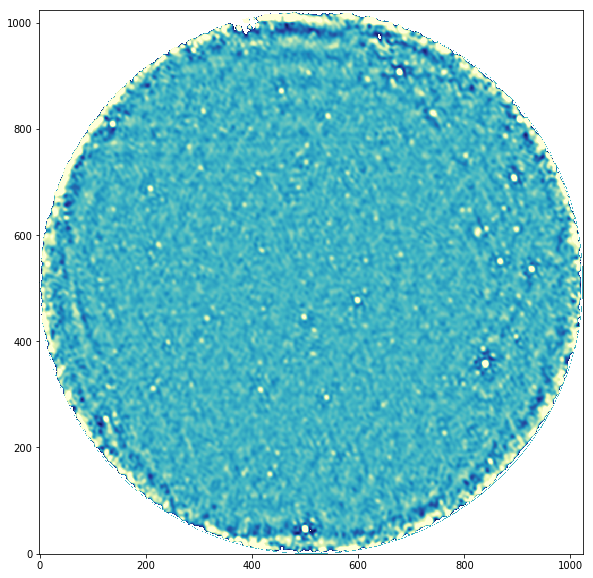

In [46]:
from astropy.visualization import ZScaleInterval

vmin, vmax = ZScaleInterval(contrast=0.2).get_limits(data[0,0,:,:])

plt.figure(figsize=(10,10))
plt.imshow(data[0,0,:,:], origin="lower", 
           vmin=vmin,vmax=vmax, cmap="YlGnBu_r")
# plt.figure(figsize=(10,10))
# plt.imshow(data[0,0,:,:], origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

In [47]:
im_ra,im_decl,n,nn = wcs.wcs_pix2world(meshx,meshy,1,1,1)

In [48]:
c1 = SkyCoord(np.ravel(im_ra)*u.deg, np.ravel(im_decl)*u.deg, frame='fk5')
c2 = SkyCoord(aart.ra.values*u.deg, aart.decl.values*u.deg, frame='fk5')

radius = 3.

# idx, d2d, d3d = c1.match_to_catalog_sky(c2)
# idx, d2d, d3d = c1.separation(c2)

# Match measurements from observation to AARTFAAC cat

# idx, d2d, d3d = match_coordinates_sky(c1,c2)
idx1, idx2, sep2d, dist3d = search_around_sky(c1,c2,radius*u.deg)



# print c1[d2d.deg < radius]

KeyboardInterrupt: 

In [ ]:
im_pix_x,im_pix_y,n,nn = wcs.wcs_world2pix(c1.ra[idx1],c1.dec[idx1],1,1,1)

In [ ]:
img = np.copy(data[0,0,:,:])

img[np.array(im_pix_y,dtype=int),
    np.array(im_pix_x,dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+2,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-2,0,1023),dtype=int)] = np.nan



radius = 10.

c3 = SkyCoord(ateam["ra"]*u.deg, ateam["decl"]*u.deg, frame='fk5')

idx1, idx2, sep2d, dist3d = search_around_sky(c1,c3,radius*u.deg)


im_pix_x,im_pix_y,n,nn = wcs.wcs_world2pix(c1.ra[idx1],c1.dec[idx1],1,1,1)

img[np.array(im_pix_y,dtype=int),
    np.array(im_pix_x,dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-1,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-1,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+2,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-2,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-2,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y+3,0,1023),dtype=int),
    np.array(np.clip(im_pix_x+3,0,1023),dtype=int)] = np.nan

img[np.array(np.clip(im_pix_y-3,0,1023),dtype=int),
    np.array(np.clip(im_pix_x-3,0,1023),dtype=int)] = np.nan


In [ ]:
matplotlib.rcParams.update({'font.size': 16})


vmin = np.nanmean(clip(data[0,0,:,:]))-3*np.nanstd(clip(data[0,0,:,:]))
vmax = np.nanmean(clip(data[0,0,:,:]))+8*np.nanstd(clip(data[0,0,:,:]))

print np.nanstd(clip(data[0,0,:,:]))
print vmin,vmax

plt.figure(figsize=(10,8))
plt.subplot(121)


plt.imshow(data[0,0,:,:], origin="lower", 
           vmin=vmin, vmax=vmax, cmap="YlGnBu_r")

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)
plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    

# theta = np.linspace(0, 2*np.pi, 200)

# r = 400.0

# x1 = r*np.cos(theta)
# x2 = r*np.sin(theta)

# plt.plot(x1+512., x2+512., color="red")



plt.xticks([])
plt.yticks([])

plt.subplot(122)

plt.imshow(img, origin="lower", 
           vmin=vmin, vmax=vmax, cmap="YlGnBu_r")


plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    


theta = np.linspace(0, 2*np.pi, 200)

r = 400.0

x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

plt.plot(x1+512., x2+512., color="red")

plt.xticks([])
plt.yticks([])

plt.tight_layout()

# plt.savefig("/home/kuiack/surveyfigs/sky_maps.pdf", bbox_inches = 'tight' )



In [ ]:
area_before = len(data[0,0,:,:][np.sqrt((meshx-512.)**2+(meshy-512.)**2) <=400])

area_after = len(img[np.logical_and((np.sqrt((meshx-512.)**2+(meshy-512.)**2) <400),np.isfinite(img) ) ])

area_after*1./area_before



In [ ]:
# Measuring pixel STD in 10 degree wide annulii around image center

%matplotlib inline


d90 = np.cos(np.radians(90))*512
d80 =  np.cos(np.radians(80))*512
d70 =  np.cos(np.radians(70))*512
d60 =  np.cos(np.radians(60))*512
d50 =  np.cos(np.radians(50))*512
d40 =  np.cos(np.radians(40))*512
d30 =  np.cos(np.radians(30))*512
d20 =  np.cos(np.radians(20))*512
d10 =  np.cos(np.radians(10))*512
d0 =  np.cos(np.radians(0))*512
# zenith_angle = [d0,d10,d20,d30,d40,d50,d60,d70,d80,d90]
zenith_angle = [d40,d50,d60,d70,d80,d90]
angles = [np.radians(40),np.radians(50),np.radians(60),np.radians(70),np.radians(80),np.radians(90)]

x, y = np.meshgrid(np.linspace(0,1024,1024),
                   np.linspace(0,1024,1024))

sensitivity = []
area = []

slope_cor, int_cor = process(image)

img = (img-int_cor)/slope_cor

mask = np.zeros((1024,1024), dtype=int)
for i in range(len(zenith_angle)-1):
    mask = np.zeros((1024,1024), dtype=int)
    mask[ np.where((np.sqrt((x-512)**2.+(y-512)**2.) <= zenith_angle[i]) &
                  (np.sqrt((x-512)**2.+(y-512)**2.) >= zenith_angle[i+1]))]+= 1


    canvas = np.nan*np.ones((1024,1024))
    canvas[np.array(mask, dtype=bool)] = img[np.array(mask, dtype=bool)]
    
#     print "STD in mask:\t\t", np.nanstd(canvas)
    sensitivity.append(np.nanstd(canvas))


#     print "search fraction:\t", np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/ len(img[np.array(mask, dtype=bool)])
#     print "search area: \t\t",  np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/ len(img[np.array(mask, dtype=bool)]) *(np.sin(angles[i+1])-np.sin(angles[i]))*2*np.pi * (180/np.pi)**2.
    area.append(np.float(len(np.where(np.isfinite(img[np.array(mask, dtype=bool)]))[0]))/\
                len(img[np.array(mask, dtype=bool)])*\
                (np.sin(angles[i+1])-np.sin(angles[i]))*2*np.pi * (180/np.pi)**2.)

    plt.figure()
    plt.imshow(canvas)
    
    

<IPython.core.display.Javascript object>


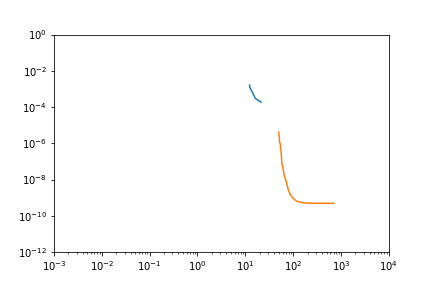

In [53]:
%matplotlib notebook

area_sum = []

idx = np.argsort(sensitivity)
area_sum.append(np.array(area)[idx][0])

for i in range(len(area)-1):
#     idx = np.argsort(sensitivity)
    area_sum.append(np.sum(np.array(area)[idx][:i+2]))

plt.plot(np.array(sensitivity)[idx],1./(1*np.array(area_sum)))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])
plt.show()

In [31]:
print np.array(area)[idx]
for i in range(len(area)-1):
    print np.array(area)[idx][:i+2]

[  241.16382761   510.06159032  1286.17991074   880.32295621  1551.52806398]
[ 241.16382761  510.06159032]
[  241.16382761   510.06159032  1286.17991074]
[  241.16382761   510.06159032  1286.17991074   880.32295621]
[  241.16382761   510.06159032  1286.17991074   880.32295621  1551.52806398]


In [32]:
img_result = pd.DataFrame({"sensitivity":np.array(sensitivity)[idx], "area_sum":area_sum})


In [33]:
previous_result = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")

total_result = pd.concat([img_result,previous_result])
# total_result.to_csv("/home/kuiack/totsensitivity_plot.csv", index=False)

In [205]:
#img_result.to_csv("/home/kuiack/sensitivity_plot.csv", index=False)

In [55]:
ring_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")


In [76]:
image_list = sorted(glob.glob("/data/ASf_201811291400/*S2*fits"))[::100]

<IPython.core.display.Javascript object>


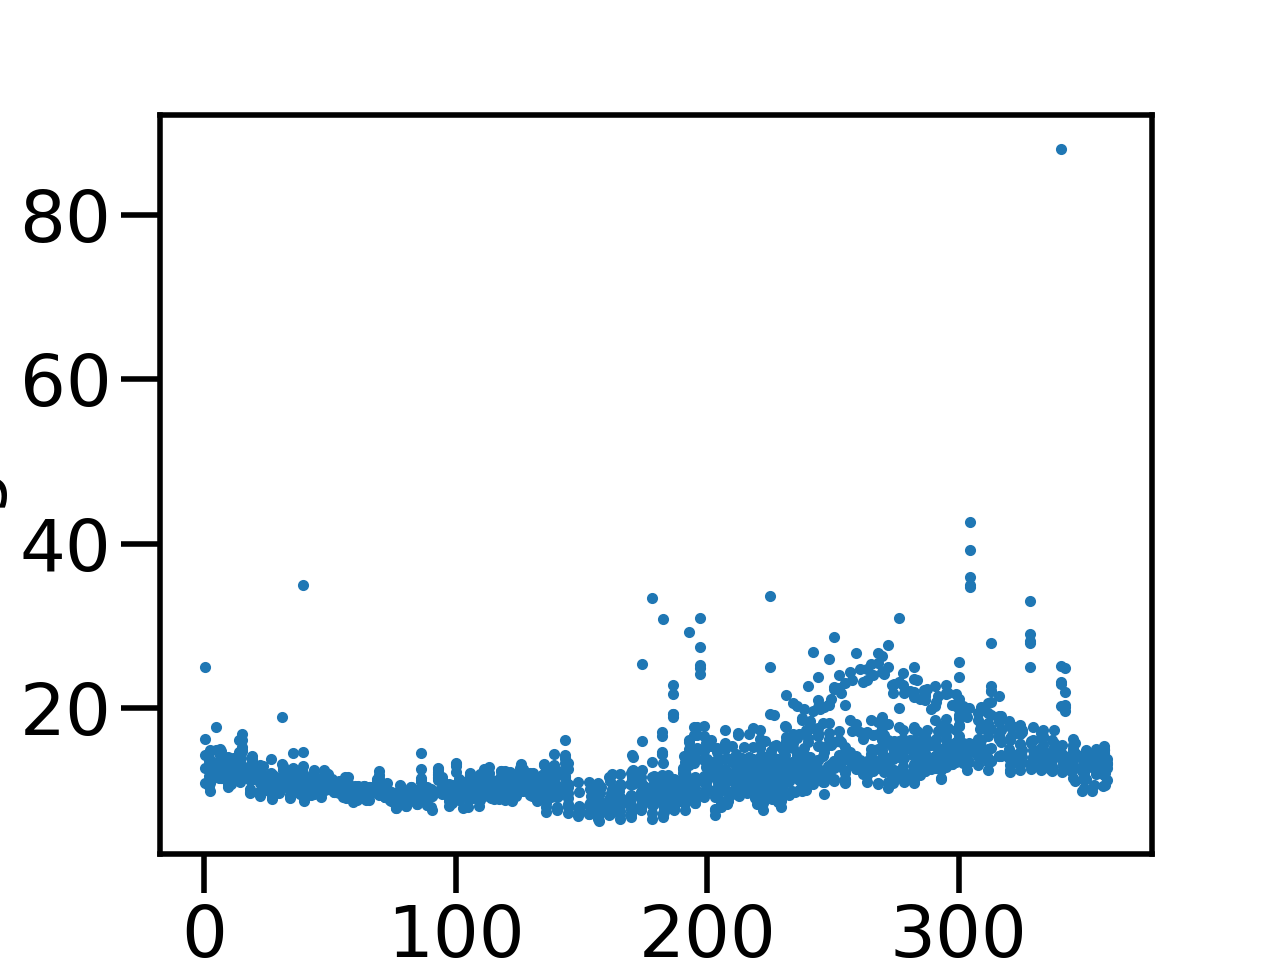

<IPython.core.display.Javascript object>


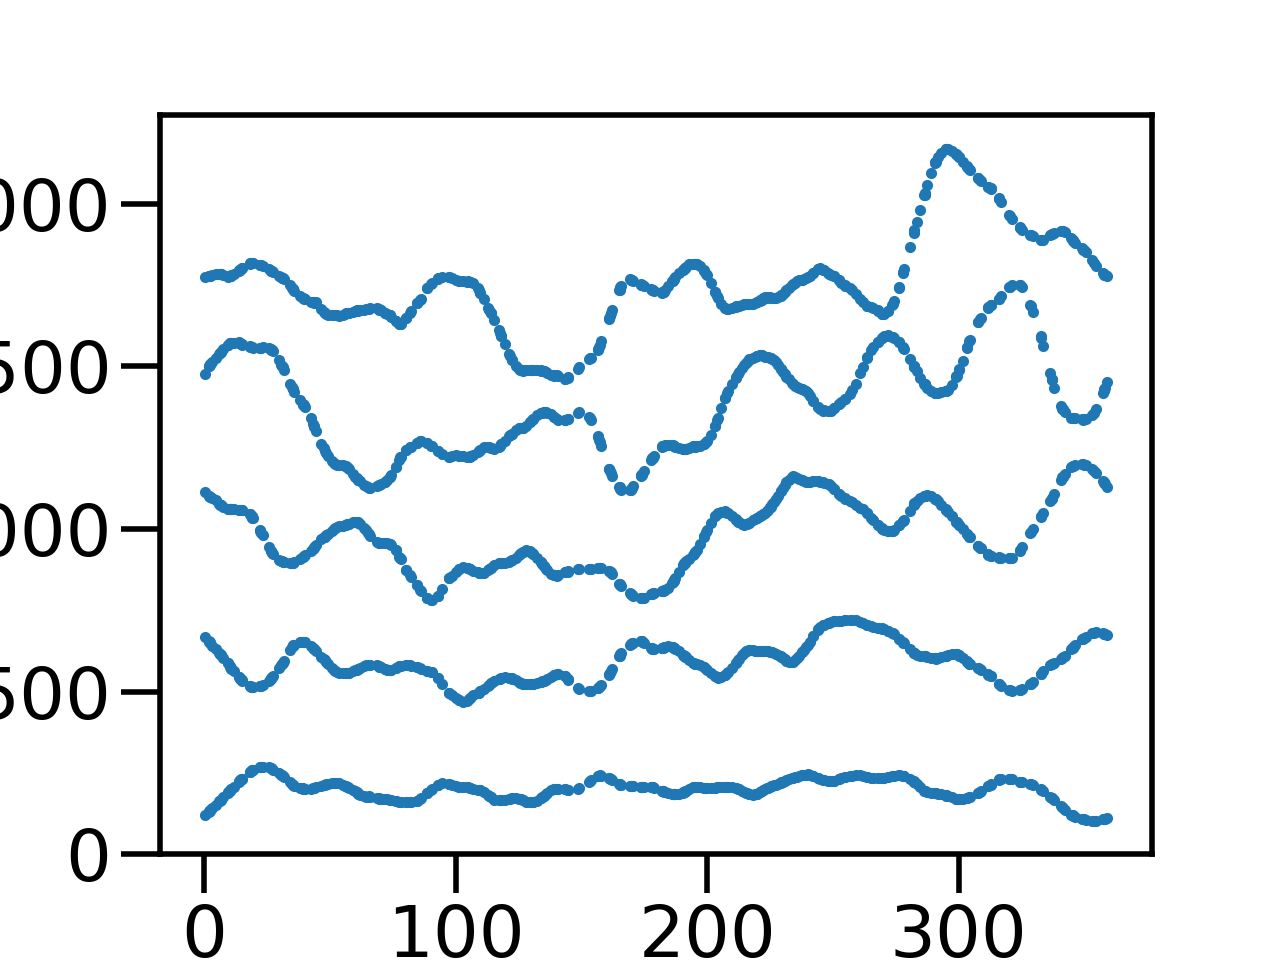

<IPython.core.display.Javascript object>


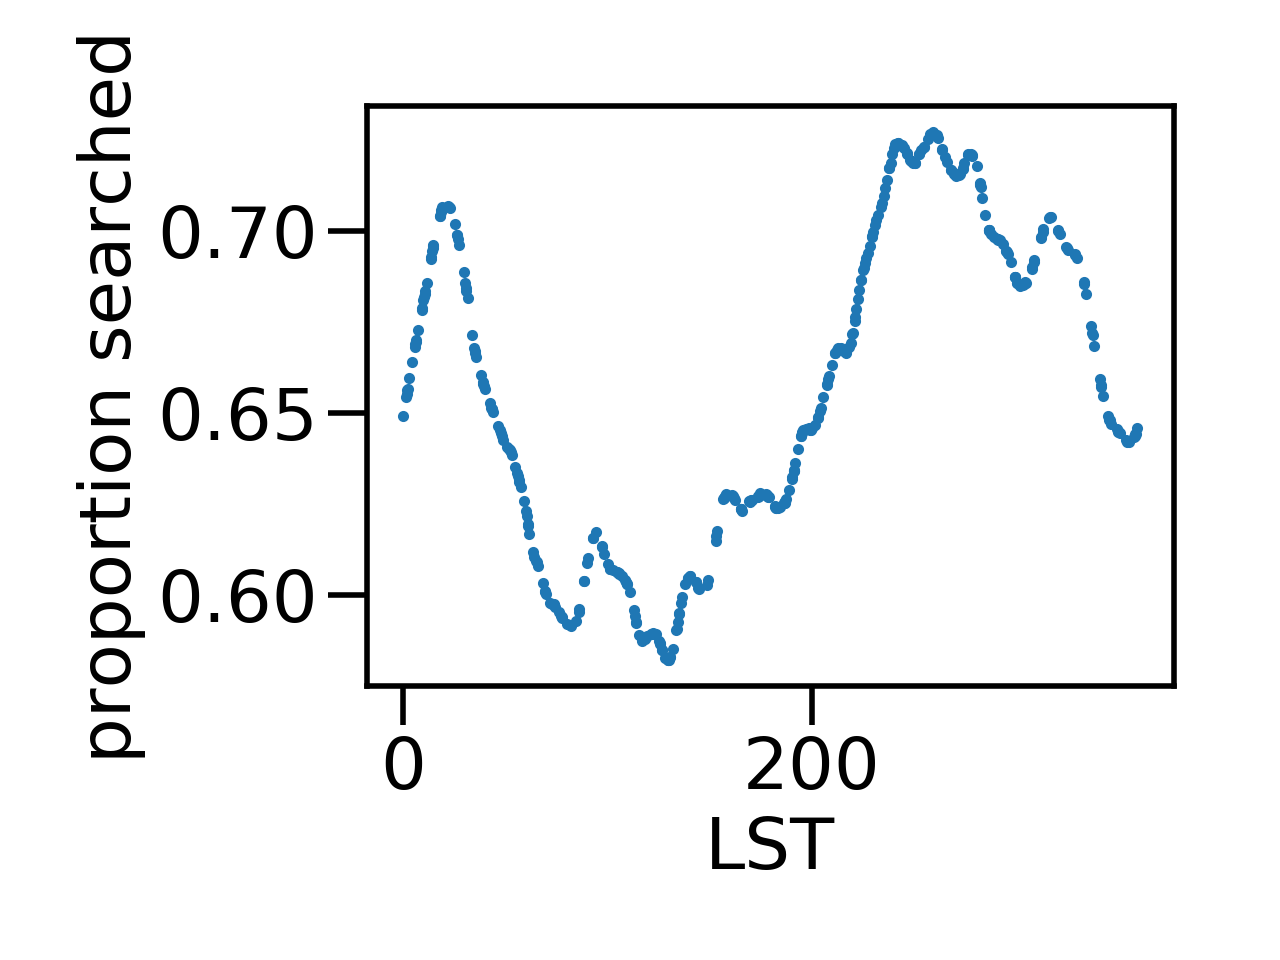

0.655600185952
per image area 4789.2


In [57]:
ring_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")


plt.figure()
plt.plot(ring_survey.LST, ring_survey.sensitivity, ".")
plt.xlabel("LST of image")
plt.ylabel("Average RMS")
plt.show()

plt.figure()
plt.plot(ring_survey.LST, ring_survey.area, ".")
plt.show()

plt.figure()
plt.plot(ring_survey.groupby("LST").mean().area_fraction, ".")
plt.xlabel("LST")
plt.ylabel("proportion searched")
plt.tight_layout()
plt.show()
print np.mean(ring_survey.area_fraction)
print "per image area", 7368*0.65

In [25]:




area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
area_sum.append(tot_survey["area"].iloc[idx].values[0])

for i in range(len(tot_survey["area"])-1):
    area_sum.append(np.sum((tot_survey["area"].iloc[idx]).values[:i+2]))

In [58]:
print tot_survey["area"].iloc[idx].values[0]
i=0
print (tot_survey["area"].iloc[idx]).values[:i+2]
i=1
print (tot_survey["area"].iloc[idx]).values[:i+2]

241.631419795
[ 241.63141979  205.95540002]
[ 241.63141979  205.95540002  241.23965337]


In [59]:
plt.plot(8*tot_survey["sensitivity"].loc[idx], 1./(1000*np.array(area_sum)))
plt.xscale("log")
plt.yscale("log")

In [60]:
sorted_sensitivity = tot_survey["sensitivity"].reshape((len(tot_survey["sensitivity"])/5,5))

In [61]:
idx = np.argsort(tot_survey["sensitivity"])
print idx

0        134
1         84
2        739
3        674
4        639
5        703
6        139
7        714
8        284
9        129
10       737
11       638
12       177
13       179
14       174
15      1539
16       704
17       132
18       738
19      1369
20       637
21       702
22      1538
23       137
24      1559
25       138
26      1536
27        83
28       178
29       164
        ... 
2060     147
2061     995
2062    2040
2063      95
2064    1150
2065    1035
2066     620
2067     625
2068     651
2069     916
2070     605
2071     753
2072     705
2073     752
2074     656
2075     751
2076     937
2077     157
2078     915
2079     600
2080     750
2081     687
2082     587
2083     774
2084     378
2085     773
2086     772
2087     771
2088     770
2089    1697
Name: sensitivity, Length: 2090, dtype: int64


In [64]:
plt.imshow(tot_survey["sensitivity"].reshape((len(tot_survey["sensitivity"])/5,5))[idx], aspect="auto")

IndexError: index 739 is out of bounds for axis 0 with size 418

In [32]:
tot_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")
tot_survey

LST         area  area_fraction  sensitivity
0     333.740830  1890.417269       0.743569    17.285740
1     333.740830  1562.500597       0.757666    15.532810
2     333.740830  1049.395100       0.690621    14.762454
3     333.740830   562.090063       0.604030    15.046334
4     333.740830   193.393599       0.617156    16.559577
5     346.358615  1879.945523       0.739451    15.748649
6     346.358615  1340.881195       0.650201    14.390447
7     346.358615  1196.803443       0.787632    14.237345
8     346.358615   643.366622       0.691371    14.518376
9     346.358615   114.850750       0.366511    11.136854
10      7.391040  1781.639337       0.700783    13.646846
11      7.391040  1554.042429       0.753565    13.437757
12      7.391040  1066.639987       0.701970    13.269742
13      7.391040   604.716900       0.649837    12.401853
14      7.391040   174.550898       0.557025    11.869665
15     11.598361  1784.880592       0.702058    13.911216
16     11.598361  1572.973348       0.762744    13.944210
17     11.598361  1060.873163       0.698175    13.650330
18     11.598361   562.337818       0.604296    11.810279
19     11.598361   207.193887       0.661195    12.402463
20    354.769078  1810.098266       0.711977    14.984999
21    354.769078  1368.823910       0.663751    14.077961
22    354.769078  1173.305375       0.772168    14.275636
23    354.769078   683.555032       0.734558    14.115020
24    354.769078   102.680716       0.327674    11.996726
25    358.976399  1777.596673       0.699193    13.247601
26    358.976399  1453.436355       0.704780    13.165979
27    358.976399  1128.477008       0.742666    13.727827
28    358.976399   674.531547       0.724861    12.635129
29    358.976399   111.956734       0.357275    11.203241
...          ...          ...            ...          ...
2060  294.836291  2167.829489       0.852686    21.794733
2061  294.836291  1424.355633       0.690679    17.151369
2062  294.836291  1060.317325       0.697809    14.321946
2063  294.836291   609.880628       0.655386    15.264378
2064  294.836291   180.490583       0.575980    12.757955
2065  108.651244  1741.925063       0.685162    10.882873
2066  108.651244  1236.215201       0.599448    10.452142
2067  108.651244   867.747112       0.571076    10.097157
2068  108.651244   495.809179       0.532804     9.628521
2069  108.651244   197.816769       0.631271     9.112608
2070  104.879744  1762.993218       0.693449    10.337829
2071  104.879744  1222.159262       0.592632    10.129813
2072  104.879744   880.559188       0.579508     9.840437
2073  104.879744   474.789154       0.510215     8.907148
2074  104.879744   205.538358       0.655912     7.895423
2075  290.628970  2127.117906       0.836672    20.219534
2076  290.628970  1419.342245       0.688248    16.145095
2077  290.628970  1093.417501       0.719592    13.835273
2078  290.628970   602.187195       0.647119    13.909473
2079  290.628970   187.264350       0.597596    12.747367
2080  280.503797  1868.120286       0.734799    22.060238
2081  280.503797  1523.977483       0.738986    16.061763
2082  280.503797  1054.578293       0.694032    15.034312
2083  280.503797   632.348061       0.679530    11.924344
2084  280.503797   232.330127       0.741410    11.432966
2085  263.682870  1686.022324       0.663174    23.351903
2086  263.682870  1530.390313       0.742095    16.900732
2087  263.682870  1048.283424       0.689889    13.582415
2088  263.682870   704.640255       0.757217    12.898268
2089  263.682870   237.675843       0.758469    12.016491

[2090 rows x 4 columns]

<IPython.core.display.Javascript object>


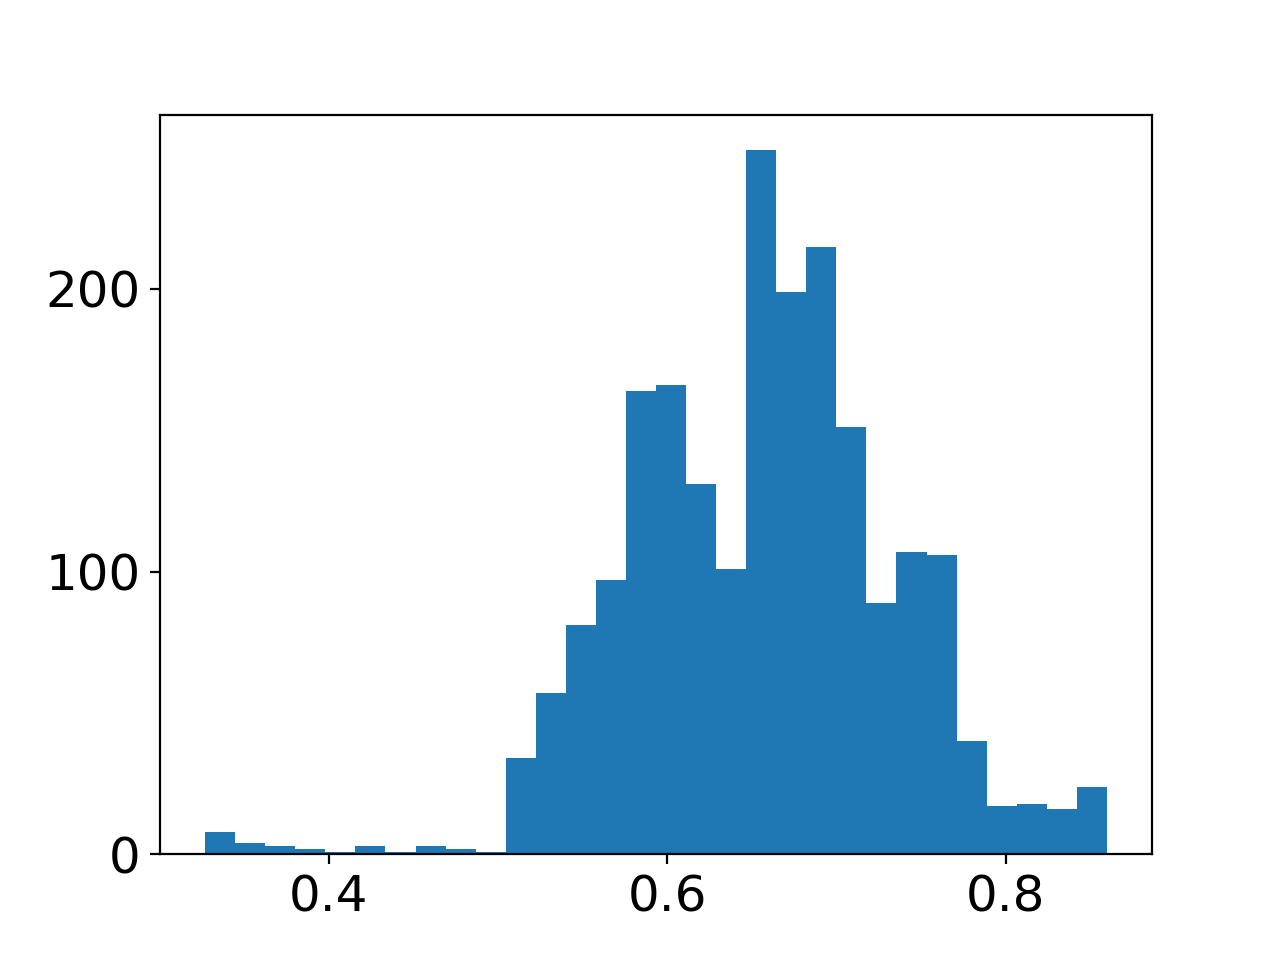

(array([   8.,    4.,    3.,    2.,    1.,    3.,    1.,    3.,    2.,
           1.,   34.,   57.,   81.,   97.,  164.,  166.,  131.,  101.,
         249.,  199.,  215.,  151.,   89.,  107.,  106.,   40.,   17.,
          18.,   16.,   24.]),
 array([ 0.32694789,  0.34470748,  0.36246706,  0.38022665,  0.39798623,
         0.41574582,  0.4335054 ,  0.45126499,  0.46902457,  0.48678416,
         0.50454374,  0.52230333,  0.54006291,  0.5578225 ,  0.57558208,
         0.59334167,  0.61110125,  0.62886084,  0.64662042,  0.66438001,
         0.68213959,  0.69989918,  0.71765876,  0.73541835,  0.75317793,
         0.77093752,  0.7886971 ,  0.80645669,  0.82421627,  0.84197586,
         0.85973544]),
 <a list of 30 Patch objects>)

In [37]:
plt.figure()
plt.hist(tot_survey["area_fraction"], bins=30)


(1e-12, 1.0)

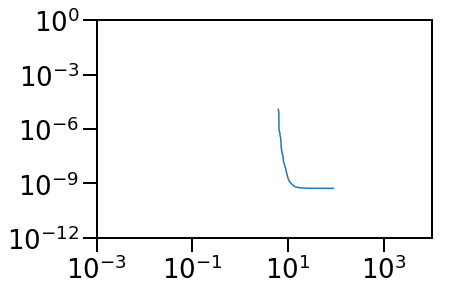

In [192]:
tot_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")


area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
area_sum.append(tot_survey["area"].iloc[idx].values[0])

for i in range(len(tot_survey["area"])-1):
    area_sum.append(np.sum((tot_survey["area"].iloc[idx]).values[:i+2]))
    
tot_survey["area_sum"] = area_sum
tot_area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
tot_area_sum.append(np.array(tot_survey["area_sum"])[idx][0])
plt.figure()
for i in range(len(tot_survey["area_sum"])-1):
#     idx = np.argsort(sensitivity)
    tot_area_sum.append(np.sum(np.array(tot_survey["area_sum"])[idx][:i+2]))

plt.plot(np.array(tot_survey["sensitivity"])[idx], 1./(np.array(tot_area_sum)))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])


In [20]:
std_map = np.std(rolling_window(img, 
                                window=(5,5)),axis=(2,3))
mean_map = np.mean(rolling_window(img, 
                                  window=(5,5)),axis=(2,3))# , vmin=-10,vmax=30, cmap="YlGnBu_r")

In [24]:
np.nanmean(std_map)

8.0213966

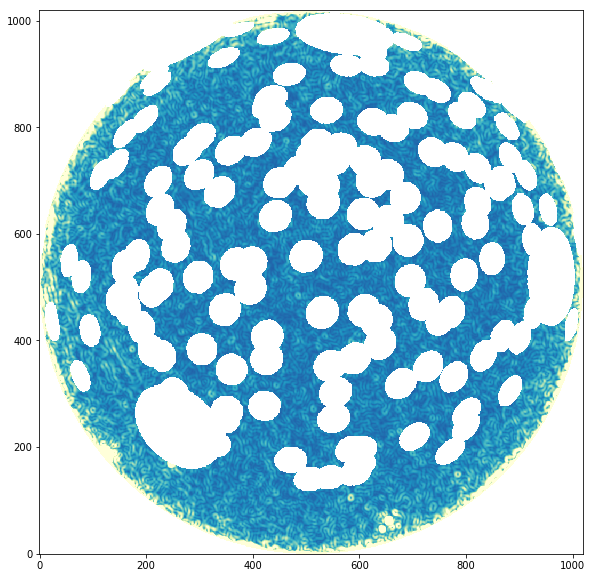

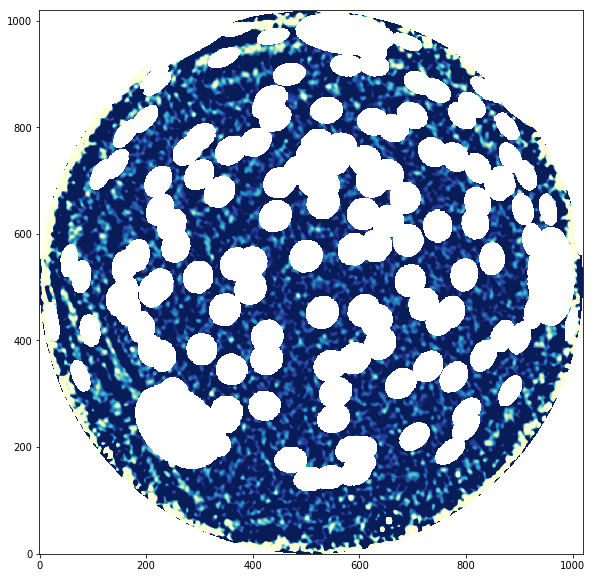

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(std_map, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")
plt.figure(figsize=(10,10))
plt.imshow(mean_map, origin="lower",vmin=-10,vmax=30, cmap="YlGnBu_r")

In [112]:
canvas = np.nan*np.ones((1024,1024))
canvas[np.array(mask, dtype=bool)] = img[np.array(mask, dtype=bool)]
np.nanstd(canvas)

5.2025191652461213

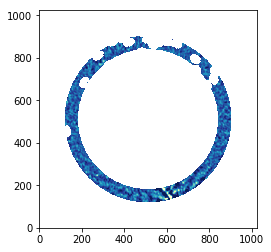

In [111]:
plt.imshow(canvas, origin="lower", vmin=-10,vmax=30, cmap="YlGnBu_r")

In [133]:
# area in square degrees in annulus
angles = [np.radians(90),np.radians(80),np.radians(70),np.radians(60),np.radians(50),np.radians(40)]

for i in range(len(angles)-1):
    print (np.sin(angles[i])-np.sin(angles[i+1]))*2*np.pi * (180/np.pi)**2.

313.362588139
930.566400747
1519.49542416
2062.25534801
2542.35468666


<a id='sensitivityplot'></a>
# Making survey sensitvity plot starts here: 

In [7]:
"""
functions for calculating statistical properties of LOFAR images
"""


def rms(data):
    """Returns the RMS of the data about the median.
    Args:
        data: a numpy array
    """
    data -= numpy.median(data)
    return numpy.sqrt(numpy.power(data, 2).sum()/len(data))


def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    raveled = data.ravel()
    median = numpy.median(raveled)
    std = numpy.std(raveled)
    newdata = raveled[numpy.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


def subregion(data, f=4):
    """Returns the inner region of a image, according to f.
    Resulting area is 4/(f*f) of the original.
    Args:
        data: a numpy array
    """
    x, y = data.shape
    return data[(int(x/2) - int(x/f)):(int(x/2) + int(x/f)), (int(y/2) - int(y/f)):(int(y/2) + int(y/f))]


def rms_with_clipped_subregion(data, sigma=3, f=4):
    """ returns the rms value of a iterative sigma clipped subsection of an image
    Args:
        data: A numpy array
        sigma: sigma value used for clipping
        f: determines size of subsection, result will be 1/fth of the image size
    """
    return rms(clip(subregion(data, f), sigma))

def read_data(hdu, plane):
    """
    Read and store data from our FITS file.
    NOTE: PyFITS reads the data into an array indexed as [y][x]. We
    take the transpose to make this more intuitively reasonable and
    consistent with (eg) ds9 display of the FitsFile. Transpose back
    before viewing the array with RO.DS9, saving to a FITS file,
    etc.
    """
    data = numpy.float64(hdu.data.squeeze())
    if plane is not None and len(data.shape) > 2:
        data = data[plane].squeeze()
    n_dim = len(data.shape)
    if n_dim != 2:
        #logger.warn("Loaded datacube with %s dimensions, assuming Stokes I and taking plane 0" % n_dim)
        data = data[0, :, :]
    data = data.transpose()
    return data

In [8]:
#!/usr/bin/python
#
#
# Author: Antonia Rowlinson
# E-mail: b.a.rowlinson@uva.nl
#


matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 14
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2

def read_datafile(filename):
    info=[]
    data=open(filename,'r')
    for lines in data:
        if not lines.startswith('#'):
            lines=lines.rstrip()
            src_data=lines.split(',')
            info.append(src_data)
    data.close()
    return info


def plotfig_rates2(trans_data, a, b, xlabel, ylabel, plotname,trackAvg):#,sumImgs):
    plt.clf()
    plt.close()
    fig = plt.figure(1,figsize=(40,20))
    matplotlib.rcParams.update({'font.size': 40})
    matplotlib.rcParams.update({'axes.linewidth' : 5})

    #labels=np.unique([x[4] for x in trans_data])
    labels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)',
            'Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)',
            'Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)',
            'Lazio et al. (2010)','Hyman et al. (2009)']

    pltlabels=['AARTFAAC 1s','AARTFAAC 10min','Rowlinson et al. (2016)','Stewart et al. (2016)',
               'Obenberger et al. (2015)','Bell et al. (2014)','Carbone et al. (2014)',
               'Cendes et al. (2014)','Jaeger et al. (2012)','Bannister et al. (2011)',
               'Lazio et al. (2010)','Hyman et al. (2009)']

    
    markers=['o','*','s','D','v','8','^','s','<','*','>','p']
    c=matplotlib.cm.rainbow_r(np.linspace(0,1,12))
    #c=[next(color) for a in range(10)]
    #plt.plot(x,y,c=c)
    
    pylab.subplots_adjust(wspace=0.001)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
    
    for a in range(len(labels)):
        if labels[a] in pltlabels:
            ax2.plot([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4, marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
            ax2.quiver([trans_data[x][0] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)
            ax1.plot([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a]],linewidth=4,marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
            ax1.quiver([trans_data[x][2] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],[trans_data[x][1] for x in range(len(trans_data)) if trans_data[x][4]==labels[a] if trans_data[x][3]=='0'],0,-20)

#plot a -3/2 line from Stewart et al. rate at ~10 min
    xtmp = np.logspace(-3.3,5,50)
    ytmp = [0.000333*(a**(-3./2.)) for a in xtmp]
    ax2.plot(xtmp,ytmp,'k-',linewidth=4)

#    for x in range(len(trans_data)):
#        if trans_data[x][4]=="This Work" and trans_data[x][4] in pltlabels:
#            C=0.162
#            ax2.plot([0.162*np.exp(float(r+2)**2. / 255.38) for r in range(11)],[((12./float(r+2))**2.)*trans_data[x][1] for r in range(11)],'r-',linewidth=4)
#            break
#    v= [a[0] for a in sumImgs]
#    w= [a[1] for a in sumImgs]
#    print(sumImgs)
#    minw= min(w)
#    ax2.plot(max(v),min(w),'b*',markersize=24)
#    ax1.plot(1./(24.*60.*60.),min(w),'b*',markersize=24)
#    ax2.plot(v,w,'b-',linewidth=4)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim([5e-4,1e5])
    ax1.set_xlim([5e-6,3e3])
    ax1.set_ylim([2e-12,1])
    ax2.set_xlabel('Sensitivity (Jy)')
    ax1.set_xlabel('Timescale (days)')
    ax1.set_ylabel(r'Surface density (deg$^{-2}$)')
    yticklabels = ax2.get_yticklabels()
    pylab.setp(yticklabels,visible=False)
    ax1.axvline(x=1.157e-5, linewidth=4, color='k', linestyle='--')
    ax1.text(1.157e-5*1.2,1e-9,'1 second',rotation=90)
    ax1.axvline(x=6.944e-4, linewidth=4, color='k', linestyle='--')
    ax1.text(6.944e-4*1.2,1e-9,'1 minute',rotation=90)
    ax1.axvline(x=0.041667, linewidth=4, color='k', linestyle='--')
    ax1.text(0.041667*1.2,1e-9,'1 hour',rotation=90)
    ax1.axvline(x=1, linewidth=4, color='k', linestyle='--')
    ax1.text(1*1.2,1e-9,'1 day',rotation=90)
    ax1.axvline(x=30, linewidth=4, color='k', linestyle='--')
    ax1.text(30*1.2,1e-9,'1 month',rotation=90)
    ax1.axvline(x=365, linewidth=4, color='k', linestyle='--')
    ax1.text(365*1.2,1e-9,'1 year',rotation=90)
    ax1.tick_params(axis='x', pad=20)
    ax2.tick_params(axis='x', pad=20)
    ax1.tick_params(axis='y', pad=20)
    ax2.tick_params(axis='y', pad=20)
    ax1.legend(bbox_to_anchor=(-0.15, -0.27), loc='lower left', borderaxespad=0.,numpoints=1, fontsize = 'small', ncol=5)
#     plt.savefig(plotname+'.png')
    plt.close(fig)
    matplotlib.rcParams.update({'font.size': 26})
    matplotlib.rcParams.update({'axes.linewidth' : 2})
    plt.show()

def getImageInfo(dataPath,sigmaClip,f):
    imageData=[]
    if not os.path.isfile('rmsData.csv'):
        outfile=open('rmsData.csv','w')
        outfile.write('#file,rms,date\n')
        for filename in sorted(glob.glob(dataPath+'*.fits')):
            hdu=0
            data = getRMS.read_data(pyfits.open(filename)[hdu], plane=None)
            hdulist=pyfits.open(filename)
            prihdr=hdulist[0].header
            obsrms=getRMS.rms_with_clipped_subregion(data, sigmaClip, f)
            date=prihdr['DATE-OBS']
            imageData.append([filename, obsrms,date])
            outfile.write(filename+','+str(obsrms)+','+str(date)+'\n')
        outfile.close()
    else:
        imageData=read_datafile('rmsData.csv')
    return imageData

def scaleBeam(RMS,imgRMS,detectThresh,HWHM,imgRadius):
    # A clever way of using the beam model to figure out how much area is enclosed up to the RMS that we're interested in...
    q = np.log(RMS/imgRMS) #RMS is the array of RMS values, imgRMS is the RMS measured in the small central area of the image, you don't want it to be negative bc that would mean no area
    if q < 0:
        return 0
    else:
        r= HWHM*np.sqrt(2.*q)
        if r > imgRadius:
            r = imgRadius
        areas = 2.*np.pi*r**2.
        return areas

def getAreasEnclosed(RMSrange,imageRMS,detectThresh,HWHM,imgRadius):
    areaVals=[]
    for RMSval in RMSrange:
        areaEnclosed=scaleBeam(RMSval,imageRMS,detectThresh,HWHM,imgRadius)
        areaVals.append([RMSval,areaEnclosed])
    return areaVals

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


In [12]:
import pylab


ratesData = read_datafile('/home/kuiack/AARTFAAC_2018/ratesData2.csv')
TMPdata=[[float(x[0]), float(x[1]), float(x[2]), x[3], x[4]] for x in ratesData]

plotfig_rates2(TMPdata,0,1, 'Limiting Flux Density (Jy)', r'Surface density (deg$^{-2}$)', 'rates_AARTFAAC',False)#,sumImgs2)

plt.show()


(1e-12, 1.0)

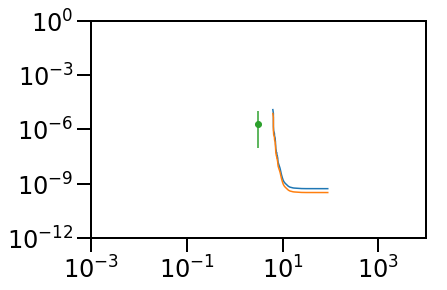

In [9]:
tot_survey = pd.read_csv("/home/kuiack/AARTFAACsurvey_sensitivity_plot.csv")


area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
area_sum.append(tot_survey["area"].iloc[idx].values[0])

for i in range(len(tot_survey["area"])-1):
    area_sum.append(np.sum((tot_survey["area"].iloc[idx]).values[:i+2]))
    
tot_survey["area_sum"] = area_sum
tot_area_sum = []

idx = np.argsort(tot_survey["sensitivity"])
tot_area_sum.append(np.array(tot_survey["area_sum"])[idx][0])
plt.figure()
for i in range(len(tot_survey["area_sum"])-1):
#     idx = np.argsort(sensitivity)
    tot_area_sum.append(np.sum(np.array(tot_survey["area_sum"])[idx][:i+2]))

plt.plot(np.array(tot_survey["sensitivity"])[idx],1./(np.array(tot_area_sum)))
plt.plot(np.array(tot_survey["sensitivity"])[idx],1./(1.6369*np.array(tot_area_sum)))

plt.errorbar(3,  2e-6, yerr=[[1.9e-6],[9e-6]], fmt="o-")

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])


In [11]:
ratesData = read_datafile('/home/kuiack/AARTFAAC_2018/ratesData2.csv')


[u'Rowlinson et al. (2016)', u'Stewart et al. (2016)', u'Obenberger et al. (2015)', u'Bell et al. (2014)', u'Carbone et al. (2016)', u'Jaeger et al. (2012)', u'Bannister et al. (2011)', u'Lazio et al. (2010)', u'Hyman et al. (2009)', u'Transient population\nw/ Euclidean distribution', u'Extreme-fluence pulses\nKuiack et al. (2020)', u'Singular magnifications\nKuiack et al. (2021b)', u'This work', u'A12 survey (proposed)', u'Transient detections', u'Anderson et al. (2019)', u'Varghese et al. (2019)', u'Transient candidate\nKuiack et al. (2021a)']


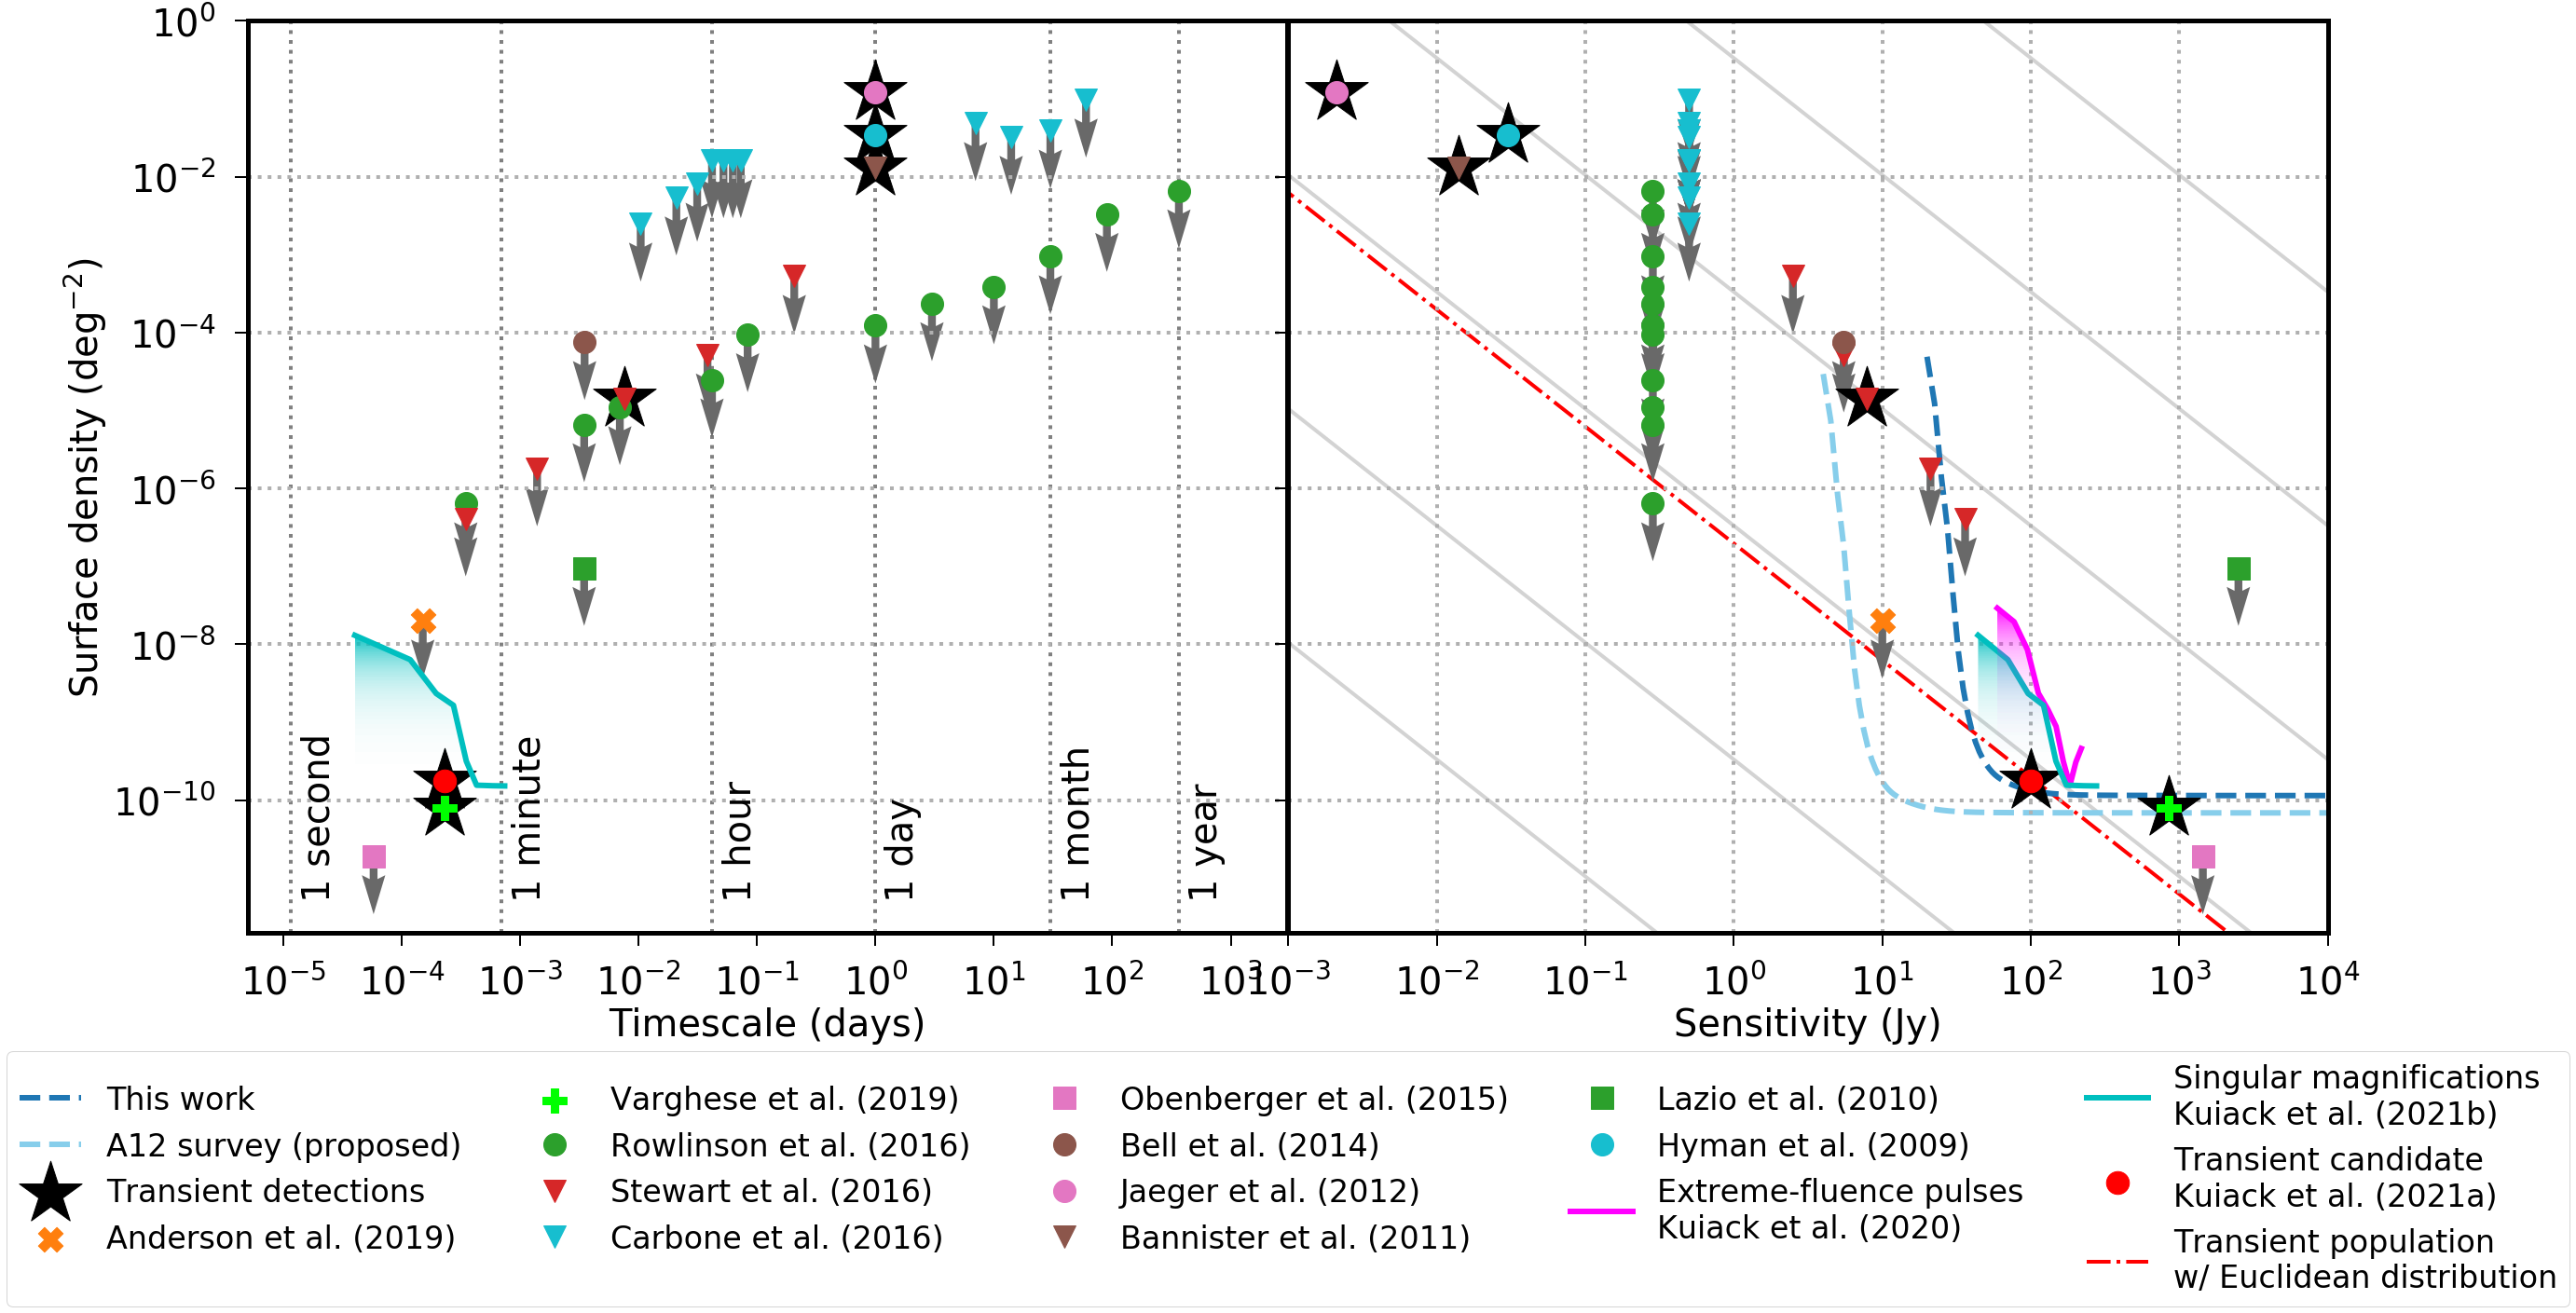

In [39]:
# correction factor 0.76 must be applied to correct image area mistake 
# 600 must be mutliplied because only every 600th image sensitivity was calculated

tot_survey = pd.read_csv("/data/kuiack/survey/sensitivity_plot.csv")\
.groupby("sensitivity")\
.agg({"sensitivity":"mean","area":"sum"})

x_val = 5.*np.cumsum(tot_survey["area"]).index
y_val = 1./(600*np.cumsum(tot_survey["area"]))


ratesData = read_datafile('/home/kuiack/AARTFAAC_2018/ratesData2.csv')
TMPdata=[[float(x[0]), float(x[1]), float(x[2]), x[3], x[4]] for x in ratesData]

single_mags = np.load("/home/kuiack/single_mag_hist.npz")

all_GP = pd.read_csv("~/AS_PSR_all_GP_Jul8.csv")
GP_mags = np.histogram(all_GP.f_int)

trans_data = TMPdata

other_surveys = pd.DataFrame(trans_data, 
                             columns=("sensitivity","surface_density",
                                      "timescale","detection", "citation"))

detect_df = other_surveys[(other_surveys["detection"].astype(int) == 1)]

a = 0
b = 1 
xlabel = 'Limiting Flux Density (Jy)'
ylabel = r'Surface density (deg$^{-2}$)'
plotname = 'rates_AARTFAAC'
trackAvg = False

fig = plt.figure(1,figsize=(40, 20))
matplotlib.rcParams.update({'font.size': 40})
matplotlib.rcParams.update({'axes.linewidth' : 5})

#labels=np.unique([x[4] for x in trans_data])
labels=['Rowlinson et al. (2016)',
        'Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)',
        'Carbone et al. (2016)','Cendes et al. (2014)','Jaeger et al. (2012)',
        'Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']

pltlabels=['Rowlinson et al. (2016)',
           'Stewart et al. (2016)','Obenberger et al. (2015)','Bell et al. (2014)',
           'Carbone et al. (2016)','Cendes et al. (2014)','Jaeger et al. (2012)',
           'Bannister et al. (2011)','Lazio et al. (2010)','Hyman et al. (2009)']

markers= ['o',  'v', 's', 'o', 'v', 's', 'o', 'v', 's', 'o']
c =      ['C2','C3','C6',"C5","C9",'C3','C6',"C5","C2","C9", ]

# c=matplotlib.cm.rainbow_r(np.linspace(0,1,12))

#c=[next(color) for a in range(10)]
#plt.plot(x,y,c=c)

pylab.subplots_adjust(wspace=0.001)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax1)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.15,box.width, box.height * 0.9])

for a in range(len(labels)):

    if labels[a] == 'Cendes et al. (2014)':
        continue 
    if labels[a] in pltlabels:
        ax2.plot([trans_data[x][0] \
                  for x in range(len(trans_data)) \
                  if trans_data[x][4]==labels[a]],[trans_data[x][1] \
                                                   for x in range(len(trans_data)) \
                                                   if trans_data[x][4]==labels[a]],\
                 linewidth=4, marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
        ax2.quiver([trans_data[x][0] \
                    for x in range(len(trans_data)) \
                    if trans_data[x][4]==labels[a] \
                    if trans_data[x][3]=='0'],[trans_data[x][1] \
                                               for x in range(len(trans_data)) \
                                               if trans_data[x][4]==labels[a] \
                                               if trans_data[x][3]=='0'],0,-20, color="dimgrey")
        ax1.plot([trans_data[x][2] \
                  for x in range(len(trans_data)) \
                  if trans_data[x][4]==labels[a]],[trans_data[x][1] \
                                                   for x in range(len(trans_data)) \
                                                   if trans_data[x][4]==labels[a]],linewidth=4,\
                 marker=markers[a],markersize=24,c=c[a],label=labels[a],ls='none')
        ax1.quiver([trans_data[x][2] \
                    for x in range(len(trans_data)) \
                    if trans_data[x][4]==labels[a] \
                    if trans_data[x][3]=='0'],[trans_data[x][1] \
                                               for x in range(len(trans_data)) \
                                               if trans_data[x][4]==labels[a] \
                                               if trans_data[x][3]=='0'],0,-20, color="dimgrey")

        
ax2.scatter(detect_df.sensitivity.astype(float), 
            detect_df.surface_density.astype(float), 
            color="k", zorder=2,
            marker="*", s=5000, label="Transient detections")

ax1.scatter(detect_df.timescale.astype(float), 
            detect_df.surface_density.astype(float), 
            color="k", zorder=2,
            marker="*", s=5000, label="Transient detections")
    
#plot a -3/2 line from Stewart et al. rate at ~10 min
xtmp = np.logspace(-3.3,5,50)
ytmp = np.array([0.000333*(a**(-3./2.)) for a in xtmp])
ax2.plot(xtmp,ytmp,'lightgrey',linewidth=4, zorder=0)
ax2.plot(xtmp,1000*ytmp,'lightgrey',linewidth=4, zorder=0)
ax2.plot(xtmp,1000000*ytmp,'lightgrey',linewidth=4, zorder=0)

ax2.plot(xtmp,.00045*ytmp*(1./0.76), "-.", c='red',linewidth=4, zorder=0, 
         label="Transient population\nw/ Euclidean distribution")

ax2.plot(xtmp,.001*ytmp,'lightgrey',linewidth=4, zorder=0)
ax2.plot(xtmp,.000001*ytmp,'lightgrey',linewidth=4, zorder=0)
ax2.plot(xtmp,.000000001*ytmp,'lightgrey',linewidth=4, zorder=0)


ax2.scatter(10, 2e-8, marker="X", s=700, label="Anderson et al. (2019)", zorder=199, c="C1")
ax2.quiver([10], [2e-8], 0, -20, zorder=189, color="dimgrey")

ax1.scatter(13./86400., 2e-8, marker="X", s=700, label="Anderson et al. (2019)", zorder=199, c="C1")
ax1.quiver(13./86400.,2e-8,0,-20, zorder=189, color="dimgrey")


ax1.scatter(20./86400., 8e-11, marker="P", s=700, label="Varghese et al. (2019)", zorder=199, c="lime")
ax1.scatter(20./86400., 8e-11,
            color="k", zorder=2,
            marker="*", s=5000, label=None)

ax2.scatter(850, 8e-11, marker="P", s=700, label="Varghese et al. (2019)", zorder=199, c="lime")
ax2.scatter(850, 8e-11, 
            color="k", zorder=2,
            marker="*", s=5000, label=None)


# ax2.scatter(single_mags["peak"],
#             single_mags["peak_n"]/(600.*np.sum(tot_survey["area"])), s=300,c="k")


hist_GPs = np.array(GP_mags[0], dtype=float)
hist_GPs[hist_GPs == 0] = np.nan

y_GPs = hist_GPs/np.array([(0.76*600.*np.sum(tot_survey[(5*tot_survey["sensitivity"] < x)]["area"])) \
                                for x in GP_mags[1][1:]])

nans, x = nan_helper(y_GPs)
y_GPs[nans]= np.interp(x(nans), x(~nans), y_GPs[~nans])


gradient_fill(GP_mags[1][1:], y_GPs, fill_color="magenta",
              ax=ax2, zorder=199, lw=6, color="magenta",
              label="Extreme-fluence pulses\nKuiack et al. (2020)")




hist_mags = np.array(single_mags["peak_n"], dtype=float)
hist_mags[hist_mags == 0] = np.nan

y_mags = hist_mags/np.array([(0.76*600.*np.sum(tot_survey[(5*tot_survey["sensitivity"] < x)]["area"])) \
                                for x in single_mags["peak"]])

nans, x = nan_helper(y_mags)
y_mags[nans]= np.interp(x(nans), x(~nans), y_mags[~nans])



gradient_fill(single_mags["peak"], y_mags, fill_color="c",
              ax=ax2, zorder=199, lw=6, color="c",
              label="Singular magnifications\nKuiack et al. (2021b)")






hist_mags = np.array(single_mags["width_n"], dtype=float)
hist_mags[hist_mags == 0] = np.nan

gradient_fill(single_mags["width"]/86400., y_mags, fill_color="c",
              ax=ax1, zorder=199, lw=6, color="c",
              label="Singular magnifications\nKuiack et al. (2021b)")


ax1.scatter(20/86400., 
            1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"])), 
            marker="o",zorder=299, s=600, c="red")

ax1.scatter(20/86400., 
            1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"])), 
            color="k", zorder=2,
            marker="*", s=5000, label=None)

ax2.scatter(100, 
            1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"])), 
            marker="o", s=600, zorder=299, c="red", label="Transient candidate\nKuiack et al. (2021a)")
ax2.scatter(100, 
            1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"])),
            color="k", zorder=2,
            marker="*", s=5000, label=None)


ax2.plot(x_val, 
         y_val,"--", 
         linewidth=6, label="This work", zorder=0)




ax2.plot(np.cumsum(tot_survey["area"]).index, 
             1./(1000*np.cumsum(tot_survey["area"])), "--", color="skyblue",
         linewidth=6, label="A12 survey (proposed)", zorder=0)


ax2.grid(ls=":",lw=4, zorder=1)
ax1.grid(axis='y',ls=":",lw=4, zorder=1)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-3,1e4])
ax1.set_xlim([5e-6,3e3])
ax1.set_ylim([2e-12,1])
ax2.set_xlabel('Sensitivity (Jy)')
ax1.set_xlabel('Timescale (days)')
ax1.set_ylabel(r'Surface density (deg$^{-2}$)')
yticklabels = ax2.get_yticklabels()
pylab.setp(yticklabels,visible=False)
ax1.axvline(x=1.157e-5, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(1.157e-5*1.2,5e-12,'1 second',rotation=90, va="bottom")
ax1.axvline(x=6.944e-4, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(6.944e-4*1.2,5e-12,'1 minute',rotation=90, va="bottom")
ax1.axvline(x=0.041667, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(0.041667*1.2,5e-12,'1 hour',rotation=90, va="bottom")
ax1.axvline(x=1, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(1*1.2,5e-12,'1 day',rotation=90, va="bottom")
ax1.axvline(x=30, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(30*1.2,5e-12,'1 month',rotation=90, va="bottom")
ax1.axvline(x=365, linewidth=4, color='grey', linestyle=':', zorder=0)
ax1.text(365*1.2,5e-12,'1 year',rotation=90, va="bottom")
ax1.tick_params(axis='x', pad=20)
ax2.tick_params(axis='x', pad=20)
ax1.tick_params(axis='y', pad=20)
ax2.tick_params(axis='y', pad=20)


handles, labels = ax2.get_legend_handles_labels()

print labels
new_handles = []
new_labels = []

order = np.array([13,14,15,16,17, 1,2,5,3,4,6,7,8,9, 11,12,0,10,])-1

for i in order:
    new_handles.append(handles[i])
    new_labels.append(labels[i])
    

ax2.legend(new_handles, new_labels, bbox_to_anchor=(-0.00, -0.27), 
           loc='center', borderaxespad=0.0,numpoints=1, fontsize = 'small', ncol=5)
#     plt.savefig(plotname+'.png')

matplotlib.rcParams.update({'font.size': 26})
matplotlib.rcParams.update({'axes.linewidth' : 2})
# plt.savefig("/home/kuiack/surveyfigs/survey_sensitivity.pdf", bbox_inches = 'tight' )
plt.show()

In [38]:
#  desired label order
np.array(labels)[np.array([13,14,15,16,17, 1,2,5,3,4,6,7,8,9, 11,12,0,10,])-1]

array([u'This work', u'A12 survey (proposed)', u'Transient detections',
       u'Anderson et al. (2019)', u'Varghese et al. (2019)',
       u'Rowlinson et al. (2016)', u'Stewart et al. (2016)',
       u'Carbone et al. (2016)', u'Obenberger et al. (2015)',
       u'Bell et al. (2014)', u'Jaeger et al. (2012)',
       u'Bannister et al. (2011)', u'Lazio et al. (2010)',
       u'Hyman et al. (2009)',
       u'Extreme-fluence pulses\nKuiack et al. (2020)',
       u'Singular magnifications\nKuiack et al. (2021b)',
       u'Transient candidate\nKuiack et al. (2021a)',
       u'Transient population\nw/ Euclidean distribution'], 
      dtype='<U46')

In [25]:
# defult label order
labels

[u'Rowlinson et al. (2016)',
 u'Stewart et al. (2016)',
 u'Obenberger et al. (2015)',
 u'Bell et al. (2014)',
 u'Carbone et al. (2016)',
 u'Jaeger et al. (2012)',
 u'Bannister et al. (2011)',
 u'Lazio et al. (2010)',
 u'Hyman et al. (2009)',
 u'Transient population\nw/ Euclidean distribution',
 u'Extreme-fluence pulses\nKuiack et al. (2020)',
 u'Singular magnifications\nKuiack et al. (2021b)',
 u'This work',
 u'A12 survey (proposed)',
 u'Transient detections',
 u'Anderson et al. (2019)',
 u'Varghese et al. (2019)',
 u'Transient candidate\nKuiack et al. (2021a)']

In [14]:
1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"]))

1.7783153774066152e-10

In [22]:
1./(1962910.*4789)



1.063787236876256e-10

In [52]:
# transient surface density compare 
rho = 1./(0.76*600.*np.sum(tot_survey[5*tot_survey["sensitivity"] < 100]["area"]))

print "rho", rho

# surface denisty scaled to antonia sensitivity and timescale
print (1.77*10**(-10)*(0.285/(100*(0.20/0.28)))**(-3/2.), 
       1.77*10**(-10)*(0.285/((100-30)*(0.20/0.28)))**(-3/2.), 
       1.77*10**(-10)*(0.285/((100+30)*(0.20/0.28)))**(-3/2.))


# Antonia expected number transient 
print ((7.)*10**(-7)*(10122)*452, 
       (7.+0.3)*10**(-7)*(10122)*452, 
       (7.-0.3)*10**(-7)*(10122)*452)

# antonia probability of non-detection
print (np.exp(-(7.)*10**(-7)*(10122)*452), 
       np.exp(-(7.-0.3)*10**(-7)*(10122)*452),
       np.exp(-(7.+0.3)*10**(-7)*(10122)*452))
# 0.04^{+0.01}_{-0.01}

# chance signal is split between timesteps = (0.2/0.28)

rho 1.77831537741e-10
(7.022858576093404e-07, 4.113021529833558e-07, 1.0409477991130953e-06)
(7.022858576093402e-07, 4.1130215298335576e-07, 1.0409477991130951e-06)
(3.2026008, 3.33985512, 3.0653464799999997)
(0.04065632737986849, 0.04663768004137836, 0.035442092199965969)


In [72]:
# stewart et al transient
# 3.9+14.7−3.7&10^-4 day-1 deg-1

print ((3.9*10**-4)*(60./20)**(-3/2.)*(545.25/24.)*(4789),
       (3.9*10**-4)*(60./(20+5))**(-3/2.)*(545.25/24.)*(4789),
       (3.9*10**-4)*(60./(20-5))**(-3/2.)*(545.25/24.)*(4789))

print np.exp(-8.166049243874474)
print np.exp(-8.166049243874474)-np.exp(-11.412400760571298)
print np.exp(-8.166049243874474)-np.exp(-5.3040045703125)
# 2.8^{+4.7}_{-2.7}

# FRB
8.84*10**-21 *1962910*4789

(8.166049243874474, 11.412400760571298, 5.3040045703125)
0.000284138363258
0.000273080853675
-0.00468750632556


8.30993237516e-11

In [ ]:
[0u'Rowlinson et al. (2016)', 
 1u'Stewart et al. (2016)', 
 2u'Obenberger et al. (2015)', 
 3u'Bell et al. (2014)', 
 4u'Carbone et al. (2016)', 
 5u'Cendes et al. (2014)', 
 6u'Jaeger et al. (2012)', 
 7u'Bannister et al. (2011)', 
 8u'Lazio et al. (2010)', 
 9u'Hyman et al. (2009)', 
 10u'Candidate isotropic\npopulation distribution', 
 11u'Extreme-fluence pulses\nKuiack et al. (2020a)', 
 12u'Singular magnifications\nKuiack et al. (2020b)', 
 13u'AARTFAAC survey', 
 14u'A12 survey (proposed)', 
 15u'Transient detection', 
 16u'Anderson et al. (2019)', 
 17u'Varghese et al. (2019)', 
 18u'Transient candidate\nKuiack et al. (2020b)']


[13,14,15,16,17, 0,1,4,2,3,5,7,8,9, 11,12,18,10,]

labels = [labels[13],labels[14],labels[0],
           labels[1],labels[4], labels[2],labels[3],
           labels[5],labels[6],
           labels[7], labels[8],labels[9],
           labels[12], labels[10],labels[11], labels[15]]

handles = [handles[13], handles[14], handles[0],
           handles[1],  handles[4], handles[2], handles[3],
           handles[5], handles[6],
           handles[7], handles[8], handles[9],
           handles[12], handles[10], handles[11],  handles[15]]



In [135]:
def FOV_area(theta):
    return 2.*np.pi*(1.- np.cos(np.deg2rad(theta)/2.))*(180/np.pi)**2.



FOV_area(100.)





7368.034447706812

In [467]:
tot_survey = pd.read_csv("/data/survey/sensitivity_plot.csv")\
.groupby("sensitivity")\
.agg({"sensitivity":"mean","area":"sum"})

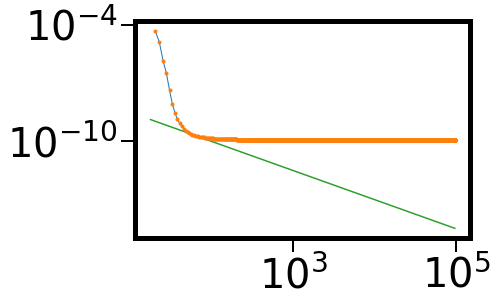

In [24]:
_x = np.logspace(1,6,1000)

plt.figure()

x_val = 5.*np.cumsum(tot_survey["area"]).index
y_val = 1./(600*np.cumsum(tot_survey["area"]))

# plt.plot(tot_survey.area, tot_survey.sensitivity, ".")
plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
         1./(600*np.cumsum(tot_survey["area"])),
         linewidth=1, label="AARTFAAC survey", zorder=99)
plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
         1./(600*np.cumsum(tot_survey["area"])),".",
         linewidth=1, label="AARTFAAC survey", zorder=99)


plt.plot(x_val, 
         a*x_val**(-3./2.))
plt.xscale("log")

plt.yscale("log")
# plt.xlim([-1,100])




2363
1.97659359723e-10 9.18531600164e-08 59.9953804642


(1, 1000)

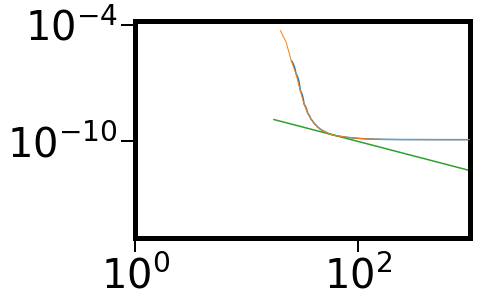

In [15]:
# plt.plot(np.logspace(1,3,2000), 
#          sp.interp(np.logspace(1,3,2000), x_val,y_val))


int_x = np.logspace(1.4,3,10000)
int_y = sp.interp(int_x, x_val, y_val)


plt.figure()
plt.plot(int_x, int_y)

x_min = np.argmax(-np.log(int_y) - 3./2.*np.log(int_x) )
print x_min

a = int_y[x_min] / int_x[x_min]**(-3./2.)
print int_y[x_min], a, int_x[x_min]

_x = np.logspace(1,6,1000)




x_val = 5.*np.cumsum(tot_survey["area"]).index
y_val = 1./(600*np.cumsum(tot_survey["area"]))

# plt.plot(tot_survey.area, tot_survey.sensitivity, ".")
plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
         1./(600*np.cumsum(tot_survey["area"])),
         linewidth=1, label="AARTFAAC survey", zorder=99)
# plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
#          1./(600*np.cumsum(tot_survey["area"])),".",
#          linewidth=1, label="AARTFAAC survey", zorder=99)


plt.plot(x_val,a*x_val**(-3./2.))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1,1000])

[  0.00000000e+00   1.04102036e-04   1.66563257e-03   8.43226488e-03
   2.66501211e-02   6.50637722e-02   1.34916238e-01   2.49948987e-01
   4.26401938e-01   6.83013455e-01   1.04102036e+00   1.52415790e+00
   2.15865981e+00   2.97325824e+00   3.99918380e+00   5.27016555e+00
   6.82243100e+00   8.69470611e+00   1.09282153e+01   1.35666814e+01
   1.66563257e+01   2.02458680e+01   2.43865264e+01   2.91320177e+01
   3.45385570e+01   4.06648576e+01   4.75721318e+01   5.53240899e+01
   6.39869408e+01   7.36293918e+01   1.32796721e+02   1.91964049e+02
   2.51131378e+02   3.10298707e+02   3.69466036e+02   4.28633365e+02
   4.87800694e+02   5.46968022e+02   6.06135351e+02   6.65302680e+02
   7.24470009e+02   7.83637338e+02   8.42804667e+02   9.01971995e+02
   9.61139324e+02   1.02030665e+03   1.07947398e+03   1.13864131e+03
   1.19780864e+03   1.25697597e+03   1.31614330e+03   1.37531063e+03
   1.43447795e+03   1.49364528e+03   1.55281261e+03   1.61197994e+03
   1.67114727e+03   1.73031460e+03

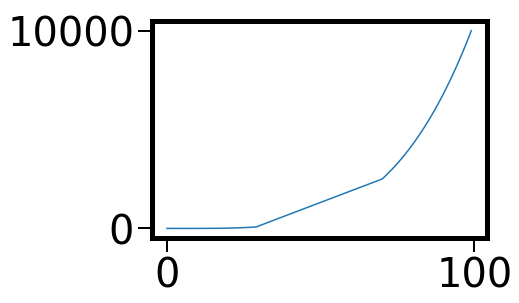

In [16]:
# hist_mags = np.array(GP_mags[0], dtype=float)
# hist_mags[hist_mags == 0] = np.nan

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


y= np.linspace(0,10,100)**4
y[30:70]= np.nan
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])

print y
plt.plot(y)

In [637]:
for x,y in zip(single_mags["peak"], single_mags["peak_n"]/np.array([(600.*np.sum(tot_survey[(8*tot_survey["sensitivity"] < x)]["area"])) \
                                for x in single_mags["peak"]])):
    print x,y

44.154680568 5.41435388061e-06
70.0237591567 1.59883662444e-08
95.8928377455 2.7424119381e-09
121.761916334 1.57582956541e-09
147.630994923 2.80931954818e-10
173.500073512 1.29936844242e-10
199.369152101 0.0
225.238230689 1.2148047919e-10
251.107309278 1.19727269756e-10
276.976387867 1.18397596179e-10


In [630]:
[1./(600.*np.sum(tot_survey[(8*tot_survey["sensitivity"] < x)]["area"])) for x in single_mags["peak"]]

[3.0079743781171449e-07,
 5.5132297394381354e-10,
 2.109547644694473e-10,
 1.5758295654066604e-10,
 1.4046597740916417e-10,
 1.2993684424204414e-10,
 1.2488994342392504e-10,
 1.2148047919015693e-10,
 1.1972726975601889e-10,
 1.1839759617909386e-10]

<a id='trapnoiseimage'></a>

# Image noise from TraP source measurement

The following makes the survey sensitivity plot from TraP source measurements. In this case I'm doing it for a full survey, so iterating though all observations, and then through each 10 minute interval within and observation.

Most of the stuff here is AARTFAAC survey specific, just look in the 10 minute interval for loop for the general method. 


In [116]:
# Valid dbname requred but doesnt matter for this query
dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]
CS002 = EarthLocation.from_geocentric (3826577.1095, 
                                       461022.900196, 
                                       5064892.758, 'm')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

# Open database connection
db.connect()
session = db.Session()

# Define SQL query: Get all survey database names
transients_query = """
    SELECT datname from pg_database
    """
# execute query 
databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

# Close database connection and delete variables. 
# This is required to clear configurations before future queries 
db._configured = False
del db, session


# databases with ASf prefix are flux calibrated
AS_databases = [x for x in databases.datname if (x[:3] == "ASf")]# or x[:3] == "ASr")]

# Empty csv file to append sky bin, RMS value 
pd.DataFrame({"ra":[],
              "decl":[],
              "RMS":[],
              "n":[],
              "n_source":[],
              "time":[]}).to_csv("/home/kuiack/RMSskymap_out_nsource.csv", index=False)

# Iterate over observations
for AS_DB in AS_databases:
    print (AS_DB)
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_DB)

    db.connect()
    session = db.Session()
    # get timesteps in database 
    transients_query = """SELECT  taustart_ts  FROM image"""


    DB_times = pd.DataFrame(run_query(transients_query, AS_DB, dataset, 
                              engine, host, port, user, password))

    unq = np.unique(DB_times["taustart_ts"], return_index=True, return_counts=True)
    DB_times.drop(unq[1][unq[2] !=2], inplace=True)

    # transients = transients[transients.rms_max < 3e2]

    db._configured = False
    del db, session
    
    # make 10 minute spaced interval in observation, these are the 
    # images where sources/sky noise is measured and averaged. It's assumed the 
    # sky does not change significantly on 10 min timescale.
    intervals = np.arange(0, len(np.unique(DB_times)), 600.)


    # Define a grid which bins sky positions in Alt-Az coordinates, 
    # converted to cartesian coordinates. AARTFAAC detection region 
    # extends to roughly 60 degrees from zenith, so these are roughly
    # 2x2 degree bins. 
    xgrid, ygrid = np.meshgrid(np.linspace(-60,60,30), 
                               np.linspace(-60,60,30))

    sensitivity = np.array([])
    area = np.array([])
    LST = np.array([])

    # iterate through 10 minute interval 
    for i in range(len(intervals))[:-1]:
        t1 = np.unique(DB_times)[intervals[i]]
        t2 = np.unique(DB_times)[intervals[i+1]]

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=AS_DB)

        db.connect()
        session = db.Session()
        
        # Get measurements of flux and position during time intervals 
        transients_query = """
            SELECT  im.taustart_ts
                    ,im.freq_eff
                    ,im.rms_min
                    ,im.rms_max
                    ,im.rms_qc
                    ,ex.f_int
                    ,ex.ra
                    ,ex.decl
                    ,ex.det_sigma
            FROM extractedsource ex
                 ,image im
           WHERE ex.image = im.id
               AND ex.extract_type = 0
               AND im.id IN (SELECT im.id 
                                FROM image im 
                                WHERE im.taustart_ts 
                                BETWEEN '{}' AND '{}')""".format(t1, t2)


        
        img_dat = pd.DataFrame(run_query(transients_query, AS_DB, dataset, 
                                  engine, host, port, user, password))
        db._configured = False
        del db, session
        
        if len(img_dat) < 1: # if interval is empty of data
            continue 

        # local RMS is flux / signal to noise. 
        # integrated flux is used because testing indicated it was more
        # consistent and accurate.
        img_rms = img_dat.f_int/img_dat.det_sigma
        
        # n measurement weighted time. 
        mean_time = pd.to_datetime(img_dat.taustart_ts.iloc[0])\
        +(pd.to_datetime(img_dat.taustart_ts.iloc[-1])\
          -pd.to_datetime(img_dat.taustart_ts.iloc[0]))/2.


        # local siderial time 
        LST = Time(mean_time).sidereal_time('apparent', 6.868889).deg
        
        # convert from Ra/Dec to Alt-Az polar to Alt-Az cartesian 
        position = SkyCoord(img_dat.ra.values*u.degree,
                            img_dat.decl.values*u.degree)  
        
        position = position.transform_to(AltAz(obstime=mean_time, location=CS002))

        cart_x, cart_y = pol2cart(np.abs(np.append(90-position.alt.deg,(np.ones(360)*55.))), 
                              np.append(position.az.rad, np.deg2rad(np.arange(0,360))))

        # interpolate RMS between each measured source position, 
        # here the outter band is set as the mean of TraPs max image RMS 
        # and quality control RMS, which is measured in the central region.
        f = sp.interpolate.griddata((cart_x, cart_y),
                                np.append(np.abs(img_rms),
                                          np.mean([img_dat.rms_max.iloc[0], 
                                                   img_dat.rms_qc.iloc[0]])*np.ones(360)),
                            (xgrid, ygrid), method="linear")

    #     reverse f,xgrid,ygrid for sensitivity skymap 
        # (not sure what this means?)
    
        # bin according to RMS now to get the number of sky bins with some RMS
        n = np.histogram(f[np.isfinite(f)], 
                         bins=np.arange(np.floor(np.min(f[np.isfinite(f)])-1.),
                                        np.floor(np.max(f[np.isfinite(f)])+1.), 1 ))


        _lst = Time(mean_time).sidereal_time('apparent', 6.868889).deg

        #     Centre of RMS bins  
        sensitivity = np.append(sensitivity, (n[1][1:] - n[1][:1])/2.+n[1][:1])

        #     Number of pixels in RMS bin 
        area = np.append(area, (6300./float(len(f[np.isfinite(f)])))*n[0])
        LST = np.append(LST, _lst*np.ones(len(n[0])))

        # Convert sky bin positions back to Ra/Dec
        pos_ = np.array([cart2pol(_x, -_y) for  _y, _x in zip(ygrid[np.isfinite(f)], 
                                                              xgrid[np.isfinite(f)])])
        
        strip_loc = SkyCoord(pos_[:,1]*u.rad, (90-pos_[:,0])*u.deg, frame="altaz",
                     obstime=mean_time, location=CS002).transform_to("fk5")

        # Output interval noise measures to file
        pd.DataFrame({"ra":strip_loc.ra.deg,
              "decl":strip_loc.dec.deg,
              "RMS":f[np.isfinite(f)], 
              "n":[600]*len(strip_loc.dec.deg), # 10 min average here
              "n_source":len(img_dat.ra.values), # number of sky bins 
              "time":[mean_time]*len(strip_loc.dec.deg)}) 
        .to_csv("/home/kuiack/RMSskymap_out_nsource.csv", mode="a", header=False, index=False)

        
#         pd.DataFrame({"sensitivity":(n[1][1:] - n[1][:1])/2.+n[1][:1],
#                       "area":(6300./float(len(f[np.isfinite(f)])))*n[0]})\
#         .to_csv("/home/kuiack/sensitivity_plot.csv", mode="a", header=False, index=False)


SyntaxError: invalid syntax (<ipython-input-116-16d6f2292d95>, line 182)

Example noise sky map from TraP source data. The outer ring is defined at the edge of the detection region. The value there is the mean of max image and quality control RMS. 

Text(0.5,1,'1970-01-01T00:00:00')

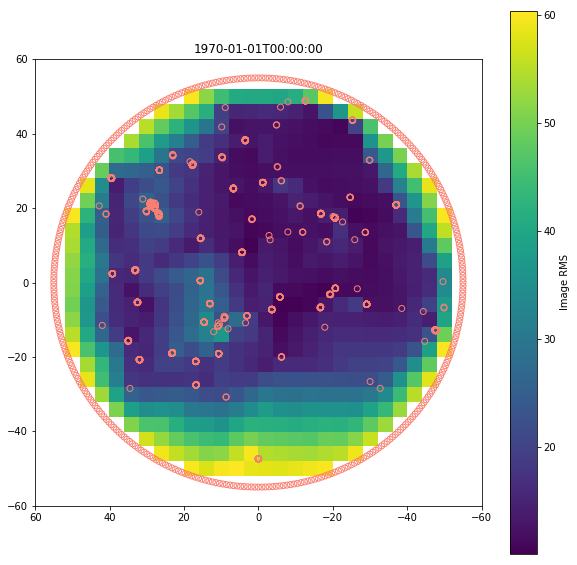

In [130]:
plt.figure(figsize=(10,10))

plt.imshow(f.T[:,::-1],origin="lower", extent=[60,-60,-60,60], aspect="equal")
plt.colorbar(label="Image RMS")
plt.scatter(cart_y,cart_x, facecolor="none",edgecolor="salmon" )

plt.title(pd.to_datetime(i).strftime("%Y-%m-%dT%H:%M:%S"))


#### Below is just plotting the results gathered above in some different ways. 

In [21]:
rms_time = pd.read_csv("/data/kuiack/survey/RMSskymap_out_nsource.csv")#.groupby("time").median()
rms_time["time"] = pd.to_datetime(rms_time.time)


In [33]:
allsurvey = pd.read_csv("/data/kuiack/survey/RMSskymap_out_nsource.csv")#.groupby("time").median()
allsurvey["time"] = pd.to_datetime(rms_time.time)


In [22]:
allsurvey = pd.read_csv("/data/kuiack/survey/RMSskymap_out_nsource.csv")

In [25]:
%%time 
times = Time(list(allsurvey.time.astype(str)), scale="utc", format="iso")

CPU times: user 41.5 s, sys: 384 ms, total: 41.9 s
Wall time: 41.6 s


In [26]:
%%time 

CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')

position = SkyCoord(allsurvey.ra.values*u.degree,
                    allsurvey.decl.values*u.degree, unit=(u.deg, u.deg),
                    location=CS002, frame="fk5")

aart_altaz = position.transform_to(AltAz(obstime=times, location=CS002))



CPU times: user 16min 46s, sys: 6.89 s, total: 16min 53s
Wall time: 16min 53s


In [27]:
# 
allsurvey["scale"] = np.cos(np.deg2rad(90.-aart_altaz.alt.deg))

1.16335032037e-10
1.529176991e-10


(0.001, 10000.0)

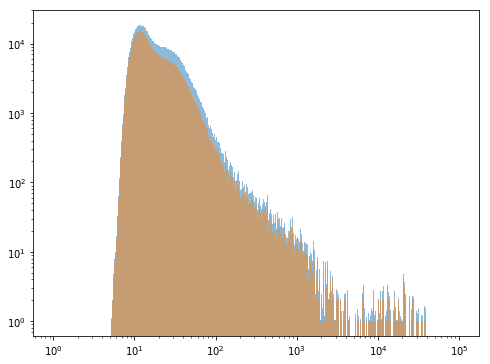

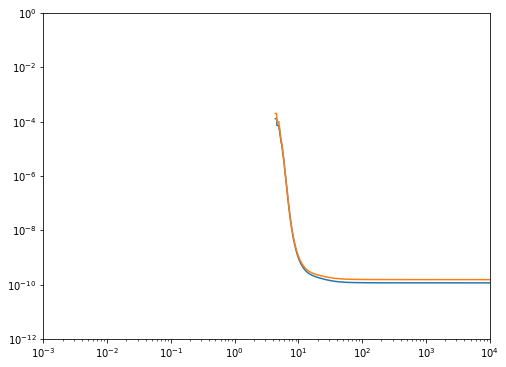

In [28]:

plt.figure(1, figsize=(8,6))
_histout  = plt.hist(allsurvey.RMS, 
             weights=1./allsurvey.scale, bins=np.logspace(0,5,1000), log=True, alpha=0.5)

bins = (_histout[1][1:]-_histout[1][:-1])/2.+_histout[1][:-1]

plt.xscale("log")
plt.figure(2, figsize=(8,6))
plt.plot(bins,1./(600*(4678./556)*np.cumsum(_histout[0])))
print np.min(1./(600*(4678./556)*np.cumsum(_histout[0])))

plt.xscale("log")
plt.yscale("log")

plt.figure(1, figsize=(8,6))
_histout  = plt.hist(allsurvey.RMS, 
             bins=np.logspace(0,5,1000), log=True, alpha=0.5)
bins = (_histout[1][1:]-_histout[1][:-1])/2.+_histout[1][:-1]

plt.figure(2, figsize=(8,6))
plt.plot(bins, 1./(600*(4678./556.)*np.cumsum(_histout[0])))
print np.min(1./(600*(4678./556)*np.cumsum(_histout[0])))
plt.ylim([1e-12, 1e0,])
plt.xlim([1e-3, 1e4])

> 0.00250971245379
2417
3.11434299078e-10 1.93751836985e-07 72.8762905444


(0.001, 10000.0)

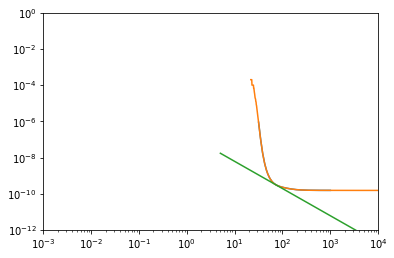

In [29]:
# plt.plot(np.logspace(1,3,2000), 
#          sp.interp(np.logspace(1,3,2000), x_val,y_val))


x_val = 5*bins
y_val =  1./(600*(4678./556.)*np.cumsum(_histout[0]))
print ">", np.log10(min(bins))

int_x = np.logspace(1.5,
                    3,10000)
int_y = sp.interp(int_x, x_val, y_val)


plt.figure()
plt.plot(int_x, int_y)

x_min = np.argmax(-np.log(int_y) - 3./2.*np.log(int_x) )
print x_min

a = int_y[x_min] / int_x[x_min]**(-3./2.)
print int_y[x_min], a, int_x[x_min]

_x = np.logspace(np.log(25),
                    np.log(1000),10000)



plt.plot(x_val,y_val)

# plt.plot(tot_survey.area, tot_survey.sensitivity, ".")
# plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
#          1./(600*np.cumsum(tot_survey["area"])),
#          linewidth=1, label="AARTFAAC survey", zorder=99)
# plt.plot(5.*np.cumsum(tot_survey["area"]).index, 
#          1./(600*np.cumsum(tot_survey["area"])),".",
#          linewidth=1, label="AARTFAAC survey", zorder=99)


plt.plot(x_val,a*x_val**(-3./2.))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1,1000])
plt.ylim([1e-12, 1e0,])
plt.xlim([1e-3, 1e4])

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


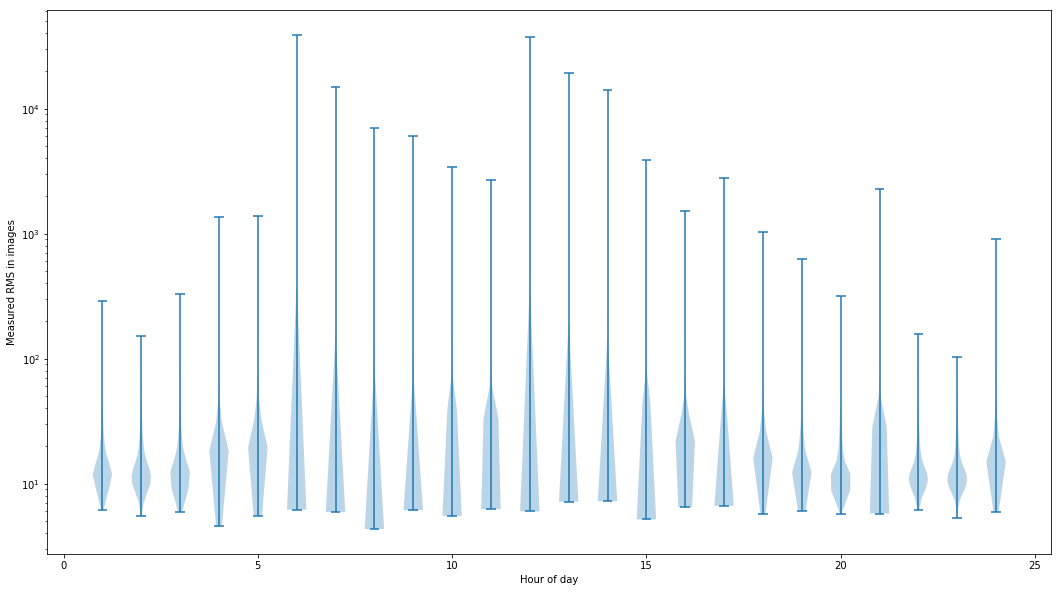

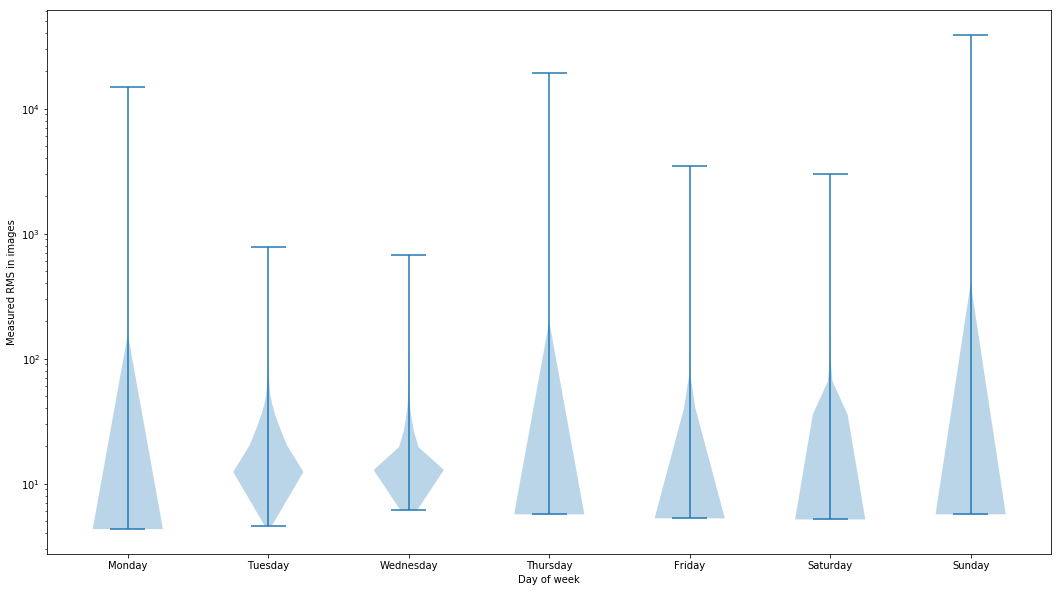

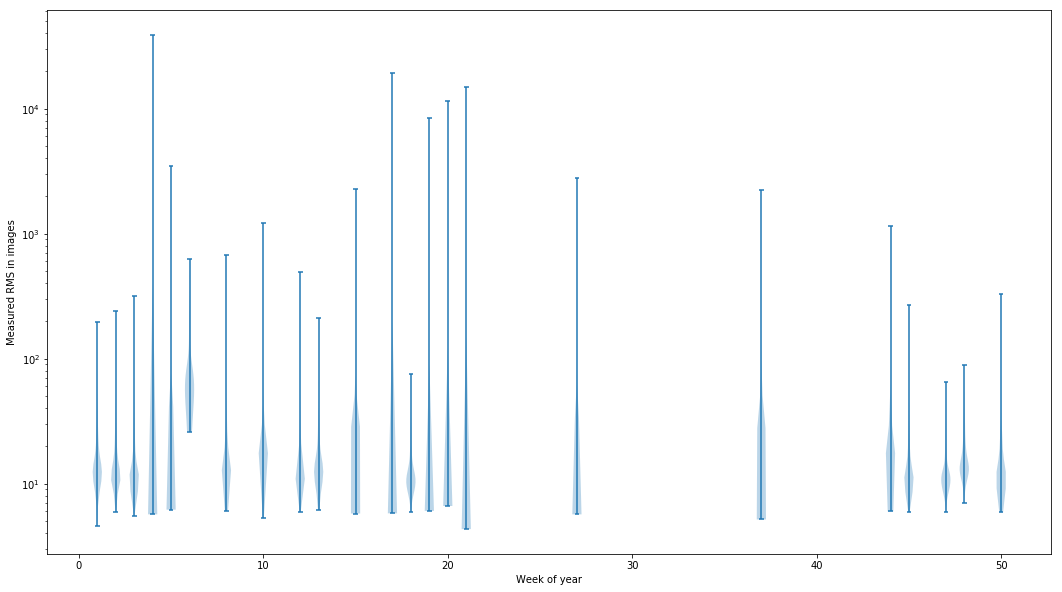

In [30]:

data = [rms_time[rms_time.time.dt.hour == x ].RMS for x in np.unique(rms_time.time.dt.hour)]
plt.figure(figsize=(18,10))
plt.violinplot(data)
plt.yscale("log")
plt.xlabel("Hour of day")
plt.ylabel("Measured RMS in images")
plt.show()

data = [rms_time[rms_time.time.dt.weekday == x ].RMS for x in np.unique(rms_time.time.dt.weekday)]
plt.figure(figsize=(18,10))
plt.violinplot(data)
plt.yscale("log")
plt.xticks( np.arange(1,8), [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday',])
plt.ylabel("Measured RMS in images")
plt.xlabel("Day of week")
plt.show()


data = [rms_time[rms_time.time.dt.weekofyear == x ].RMS for x in np.unique(rms_time.time.dt.weekofyear)]
plt.figure(figsize=(18,10))
plt.violinplot(data, positions=np.unique(rms_time.time.dt.weekofyear))
plt.yscale("log")
plt.xlabel("Week of year")
plt.ylabel("Measured RMS in images")


plt.show()

# plt.figure(figsize=(18,6))
# plt.plot(rms_time.time.dt.hour, rms_time.RMS, ".")
# plt.yscale("log")

array([ 11.79740016])

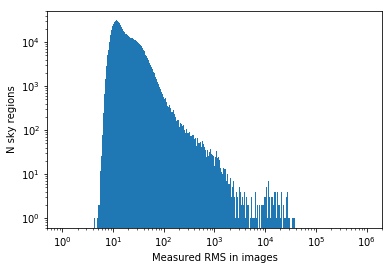

In [32]:
_histout = plt.hist(rms_time.RMS.values, bins=np.logspace(0,6,600), log=True)
plt.xscale("log")
plt.xlabel("Measured RMS in images")
plt.ylabel("N sky regions")

_histout[1][1:][_histout[0] == np.max(_histout[0])]

In [18]:
# Make full sky map of noise data 

import healpy as hp

NSIDE = 32

sensitivity_map = pd.read_csv("/data/kuiack/survey/RMSskymap_out_nsource.csv")

hp_index = np.arange(hp.nside2npix(NSIDE))

sky_map = pd.DataFrame({"RMS":np.zeros(len(hp_index)), 
                        "n":np.zeros(len(hp_index))}, index = hp_index )


pix_index = hp.pixelfunc.ang2pix(NSIDE, sensitivity_map.ra, sensitivity_map.decl, lonlat=True)    

mean_map = pd.DataFrame({"pix_index":pix_index,
                         "pix_rms":sensitivity_map["RMS"],
                         "pix_n":sensitivity_map["n"]}).groupby("pix_index").agg({"pix_rms":"mean", "pix_n":"sum"})

sky_map.at[mean_map.index, "RMS"] = mean_map.pix_rms
# sky_map.at[pix_index, "i"] = sky_map.iloc[pix_index]["i"] + tmp_img[index]
# sky_map.at[pix_index, "w"] = sky_map.iloc[pix_index]["w"] + beam_model[index]
sky_map.at[pix_index, "n"] =  mean_map.pix_n


# hp.write_map("/home/kuiack/A12_map_2.fits", (sky_map["idotw"]/sky_map["w"]))

0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 20 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 20 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 20 deg 0.00'.


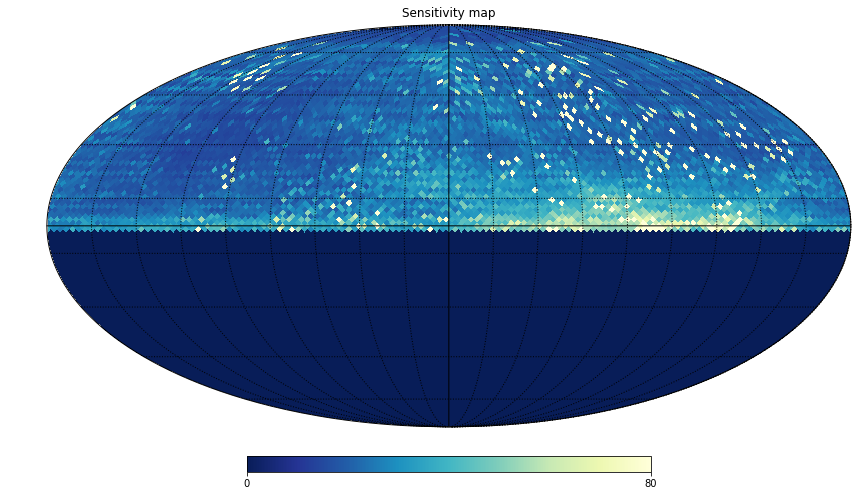

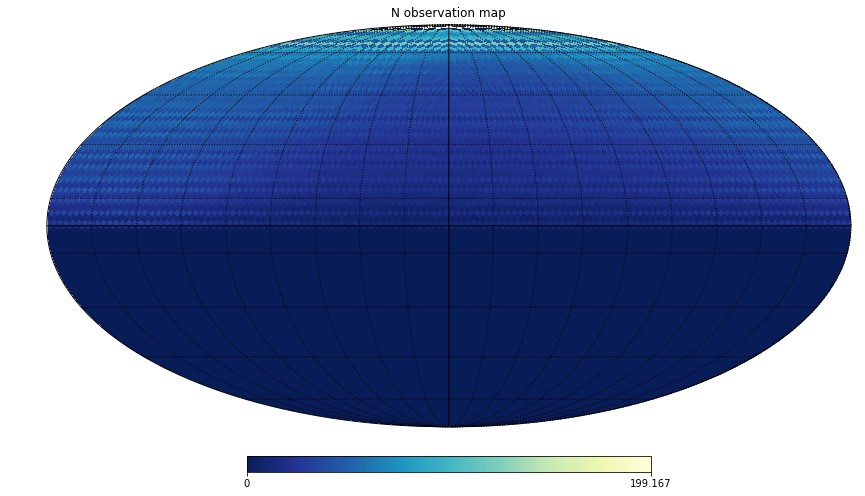

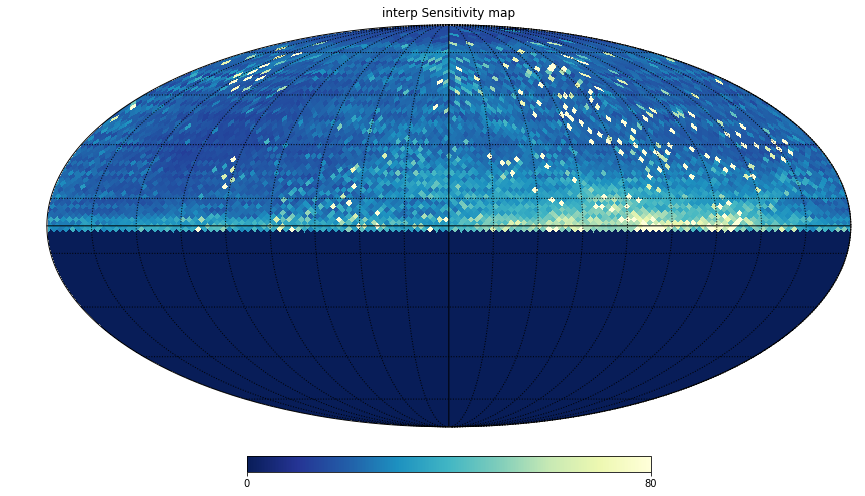

In [20]:
from pylab import arange, show, cm
%matplotlib inline 

m_rms = sky_map["RMS"]#/sky_map["w"])


lat,lon = hp.pix2ang(NSIDE, m_rms.index.values, lonlat=True)
m_interp = hp.get_interp_val(m_rms, lat, lon, lonlat=True)


# for i in  np.arange(0,360,5):
plt.figure(1, figsize=(11.69,8.27))


cmap = cm.YlGnBu_r
cmap.set_under('w')
cmap.set_bad('w')

hp.mollview(m_rms, cmap=cmap, title="Sensitivity map", fig=1,rot=[0,0,0], min = 0, max =80, cbar=True)
hp.graticule(5)


plt.figure(3, figsize=(11.69,8.27))


cmap = cm.YlGnBu_r
cmap.set_under('w')
cmap.set_bad('w')

hp.mollview(m_interp, cmap=cmap, title="interp Sensitivity map", fig=3, rot=[0,0,0], min = 0, max =80, cbar=True)
hp.graticule(5)


m_n = sky_map["n"]#/sky_map["w"])

# for i in  np.arange(0,360,5):
plt.figure(2, figsize=(11.69,8.27))



cmap = cm.YlGnBu_r
cmap.set_under('w')
cmap.set_bad('w')

hp.mollview(m_n/3600, cmap=cmap, title="N observation map", fig=2,rot=[0,0,0], cbar=True)
hp.graticule(5)


# lat, lon = hp.pix2ang(NSIDE, m[np.abs(m) < 1e-2].index.values)

# m_interp = hp.get_interp_val(m,  lat, lon)
# m[np.abs(m) < 1e-2] = m_interp

# hp.mollview(m, cmap=cmap, title="The AARTFAAC-12 sky", fig=2,rot=[0,0,0], cbar=False)
# hp.graticule(5)

In [471]:

m[np.abs(m) < 1e-5] = np.nan

lat, lon = hp.pix2ang(NSIDE, m.index[np.isnan(m)])

# m_interp = hp.get_interp_val(m,  lat, lon)
# m[np.abs(m) < 1e-2] = m_interp


# hp.get_interp_weights?
pix = hp.get_all_neighbours(NSIDE, lat,lon, lonlat=True)



In [481]:
hp.nside2pixarea(64,degrees=True)

0.83929364521116678

In [472]:
for i in range(len(m)):
    
    m[i] = np.nanmean(m[pix[:,i]])


IndexError: index 11732 is out of bounds for axis 1 with size 11732

In [ ]:
hp.mollview(m, cmap=cmap, title="The AARTFAAC-12 sky", fig=3,rot=[0,0,0], cbar=False)
hp.graticule(5)

In [186]:
area_sum = []

output_low = output_low.groupby("sensitivity").agg({"sensitivity":"mean", "area":"sum"})
output_low.to_csv("/home/kuiack/AARTFAAC_surveysensitivity.csv", index=False)

idx = np.argsort(output_low.sensitivity)
area_sum.append(np.array(output_low.area)[idx][0])

for i in range(len(output_low.area)-1):
#     idx = np.argsort(sensitivity)
    area_sum.append(np.sum(np.array(output_low.area)[idx][:i+2]))

plt.figure(1)

plt.plot(8*np.array(output_low.sensitivity)[idx],1./(600*np.array(area_sum)))
plt.plot(np.array(output_low.sensitivity)[idx],1./(600*np.array(area_sum)))

# plt.plot(5*np.array(output.sensitivity)[idx],1./(np.array(area_sum)))


# area_sum = []

# idx = np.argsort(output_hi.sensitivity)
# area_sum.append(np.array(output_hi.area)[idx][0])

# for i in range(len(output_hi.area)-1):
# #     idx = np.argsort(sensitivity)
#     area_sum.append(np.sum(np.array(output_hi.area)[idx][:i+2]))



# plt.plot(8*np.array(output_hi.sensitivity)[idx],2./(np.array(area_sum)))



plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])
plt.show()

SyntaxError: invalid syntax (<ipython-input-186-30a554a31511>, line 1)

In [82]:
%%time


# calculate a histogram of the area/sensitivity for timesteps from the TraP database

CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')

xgrid, ygrid = np.meshgrid(np.linspace(-60,60,30), np.linspace(-60,60,30))

sensitivity = np.array([])
area = np.array([])
LST = np.array([])

for i in np.unique(data.taustart_ts):
    img_dat = data[(data.taustart_ts == i)] #& (data.freq_eff < 60000000)]
    img_rms = img_dat.f_int/img_dat.det_sigma
    LST = Time(pd.to_datetime(i)).sidereal_time('apparent', 6.868889).deg
    
    position = SkyCoord(img_dat.ra.values*u.degree,
                        img_dat.decl.values*u.degree)  
    position = position.transform_to(AltAz(obstime=pd.to_datetime(i), location=CS002))
    
    cart_x, cart_y = pol2cart(np.abs(np.append(90-position.alt.deg,(np.ones(360)*55.))), 
                          np.append(position.az.rad, np.deg2rad(np.arange(0,360))))
    
    f = sp.interpolate.griddata((cart_x, cart_y),
                            np.append(np.abs(img_rms),
                                      np.mean([img_dat.rms_max.iloc[0],img_dat.rms_qc.iloc[0]])*np.ones(360)),
                        (xgrid, ygrid), method="linear")
    
#     plt.figure(1)
#     n = plt.hist(f[np.isfinite(f)], bins=np.arange(np.floor(np.min(f[np.isfinite(f)])-1.), 
#           np.floor(np.max(f[np.isfinite(f)])+1.), 1 ))

    n = np.histogram(f[np.isfinite(f)], 
                     bins=np.arange(np.floor(np.min(f[np.isfinite(f)])-1.),
                                    np.floor(np.max(f[np.isfinite(f)])+1.), 1 ))

    
    
    _lst = Time(pd.to_datetime(i)).sidereal_time('apparent', 6.868889).deg

#     Centre of RMS bins  
    sensitivity = np.append(sensitivity, (n[1][1:] - n[1][:1])/2.+n[1][:1])
#     Number of pixels in RMS bin 
    area = np.append(area, (6300./float(len(f[np.isfinite(f)])))*n[0])
    LST = np.append(LST, _lst*np.ones(len(n[0])))

output_low = pd.DataFrame({"sensitivity":sensitivity, "area":area})
output_low = output_low.groupby("sensitivity").agg({"sensitivity":"mean", "area":"sum"})



AttributeError: 'DataFrame' object has no attribute 'det_sigma'

In [248]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

xgrid,ygrid = np.meshgrid(np.linspace(-60,60,30), np.linspace(-60,60,30))

sensitivity = []

for i in np.unique(DB_times):
    
    img_dat = data[(data.taustart_ts == i)]
    img_rms = img_dat.f_int/img_dat.det_sigma

    position = SkyCoord(img_dat.ra.values*u.degree,
                        img_dat.decl.values*u.degree)

    try:
        position = position.transform_to(AltAz(obstime=pd.to_datetime(i), location=CS002))
    except ValueError:
        print pd.to_datetime(i).strftime("%Y-%m-%dT%H:%M:%S")
        continue

    cart_x, cart_y = pol2cart(np.abs(np.append(90-position.alt.deg,(np.ones(360)*55.))), 
                          np.append(position.az.rad, np.deg2rad(np.arange(0,360))))

    
    f = sp.interpolate.griddata((cart_x, cart_y),
                            np.append(np.abs(img_rms),
                                      np.mean([img_dat.rms_max.iloc[0],img_dat.rms_qc.iloc[0]])*np.ones(360)),
                        (xgrid, ygrid), method="linear")

#     sensitivity.append(f[np.isfinite(f)])

    fields=f[np.isfinite(f)]

    with open(r'/home/kuiack/test.csv', 'a') as f_out:
        writer = csv.writer(f_out)
        writer.writerow(fields)

    f_out.close()

<IPython.core.display.Javascript object>


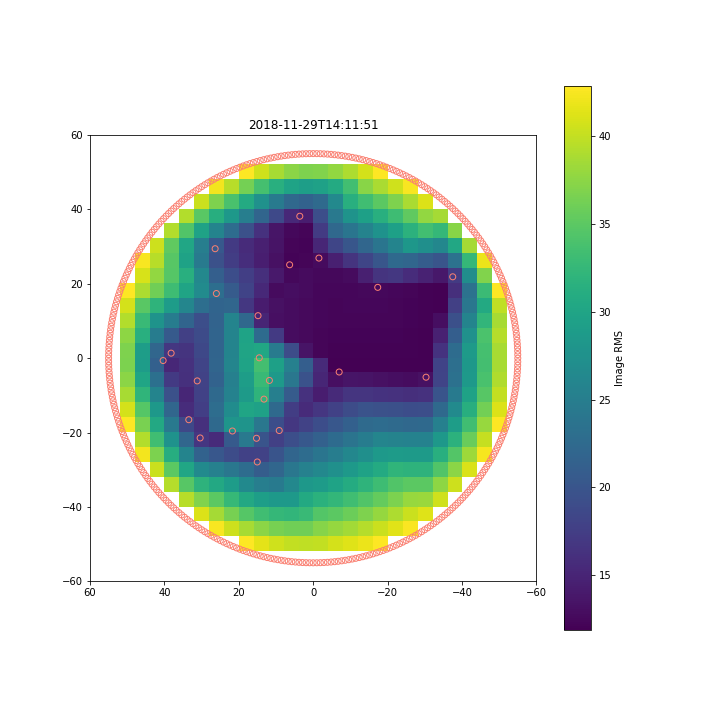

11.8766967367 42.8357794574 25.8392160262
7.82509806911 70.5291930501 15.1752712172


<IPython.core.display.Javascript object>


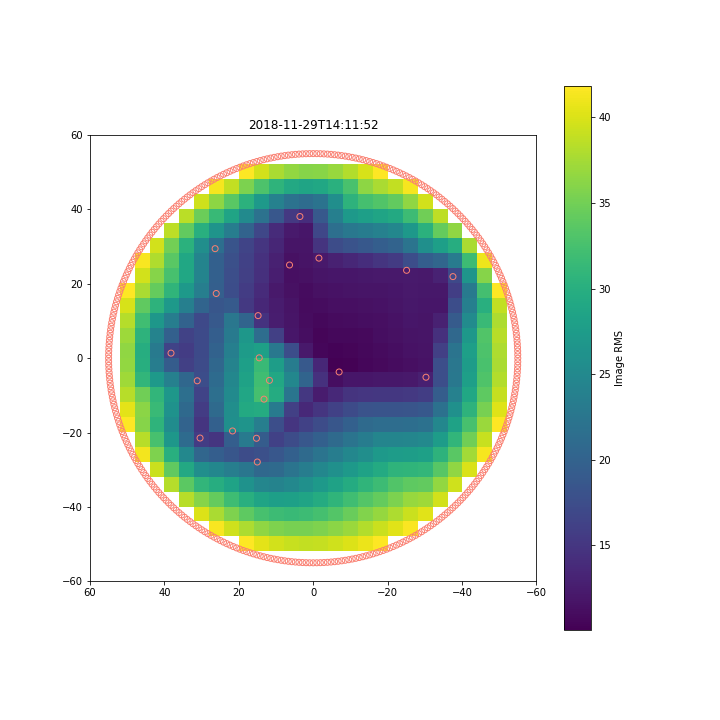

10.0550158085 41.8111162909 24.9015580614
7.83243951127 68.9702426931 14.684204743


<IPython.core.display.Javascript object>


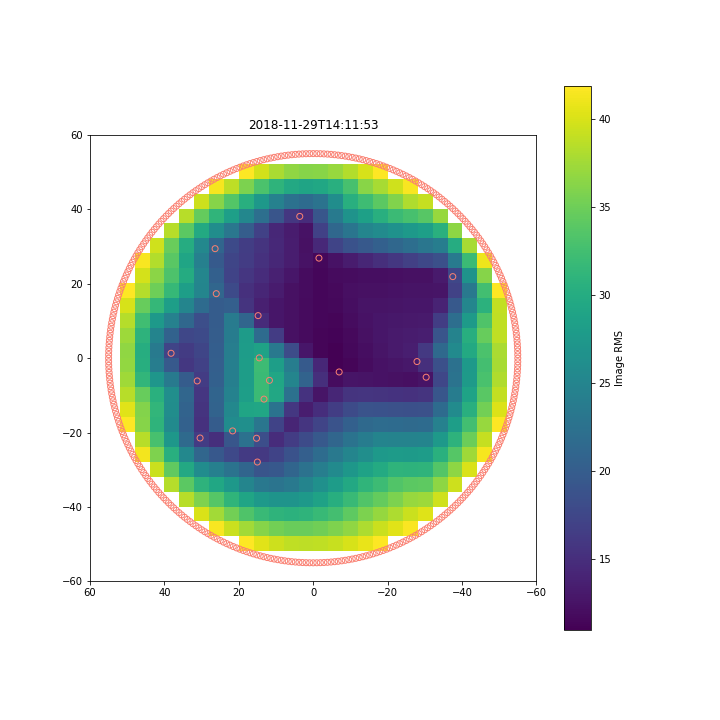

10.9411393154 41.8609823526 25.1312230223
9.35950172755 69.5895534502 14.1637944022


<IPython.core.display.Javascript object>


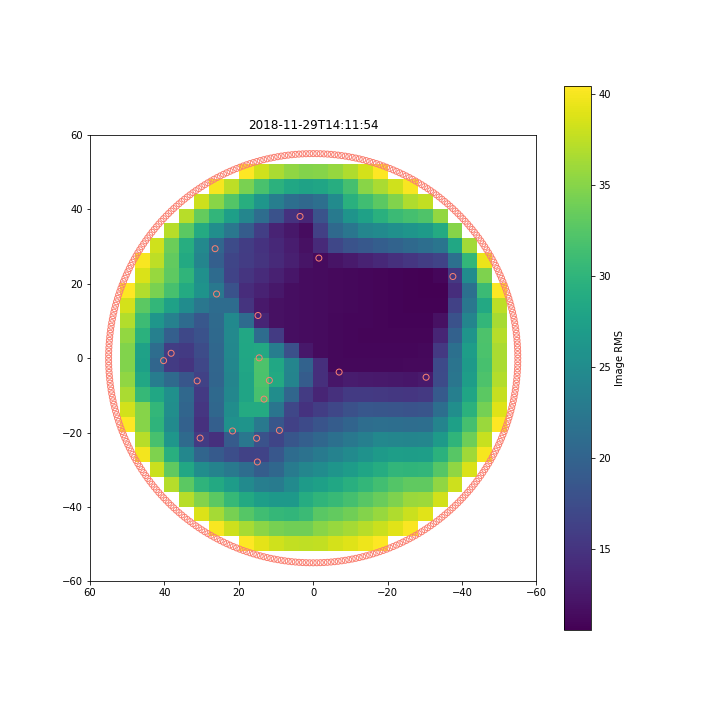

10.5687466323 40.4080332721 24.2992154266
8.28727610421 66.6228410106 14.2237333332


<IPython.core.display.Javascript object>


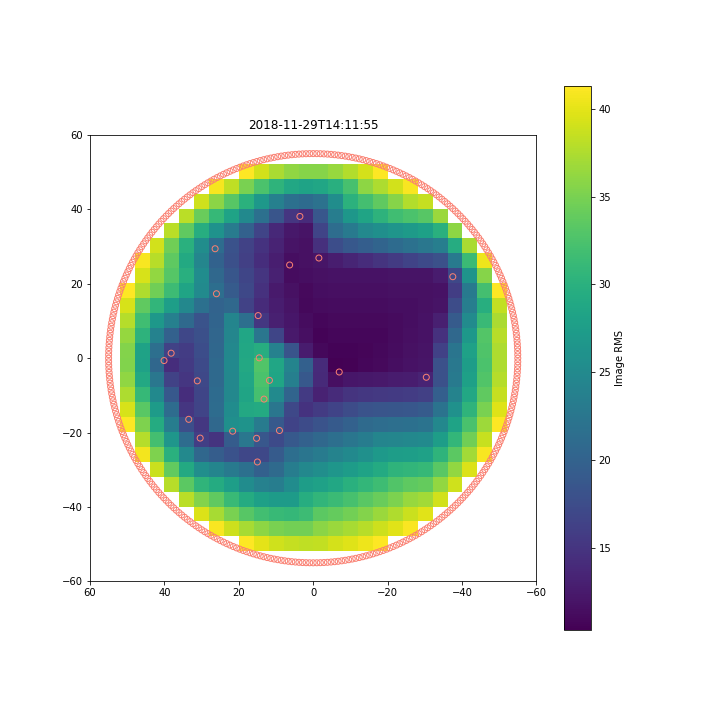

10.3534918791 41.264050765 24.7436714435
5.79920251757 68.0936292077 14.4655814208


<IPython.core.display.Javascript object>


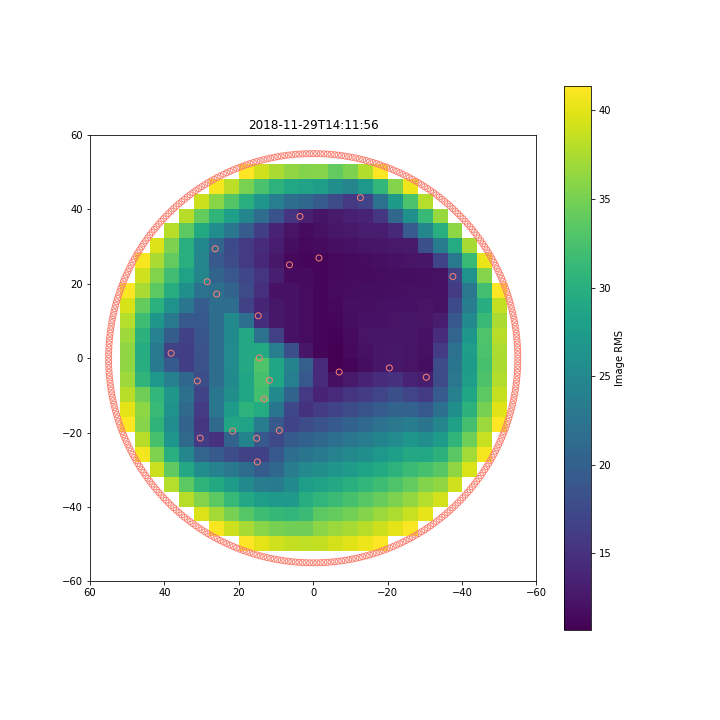

10.6691417539 41.3535941627 24.4430288595
7.52081043822 68.030941165 14.7070631225


<IPython.core.display.Javascript object>


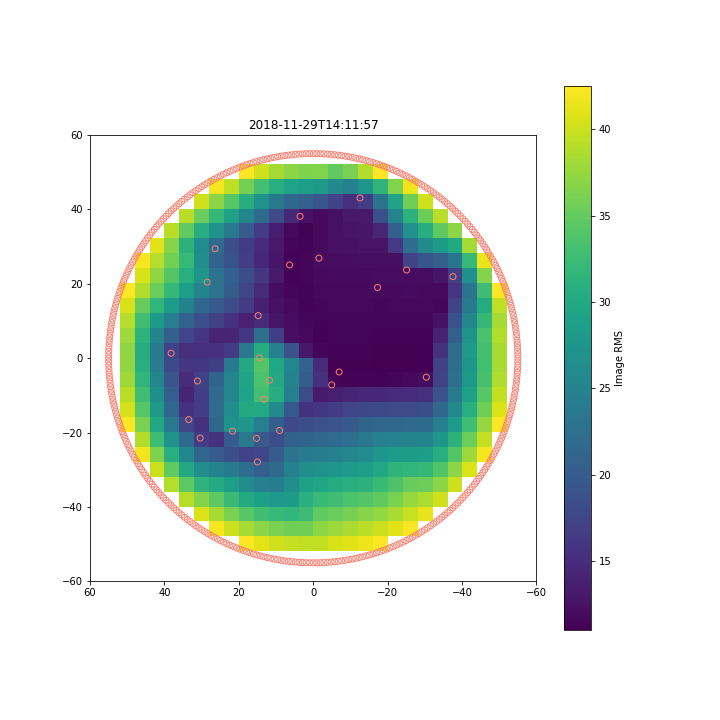

11.0202250209 42.4851981976 24.7606217045
4.79441610561 69.9162330152 15.0846173293


<IPython.core.display.Javascript object>


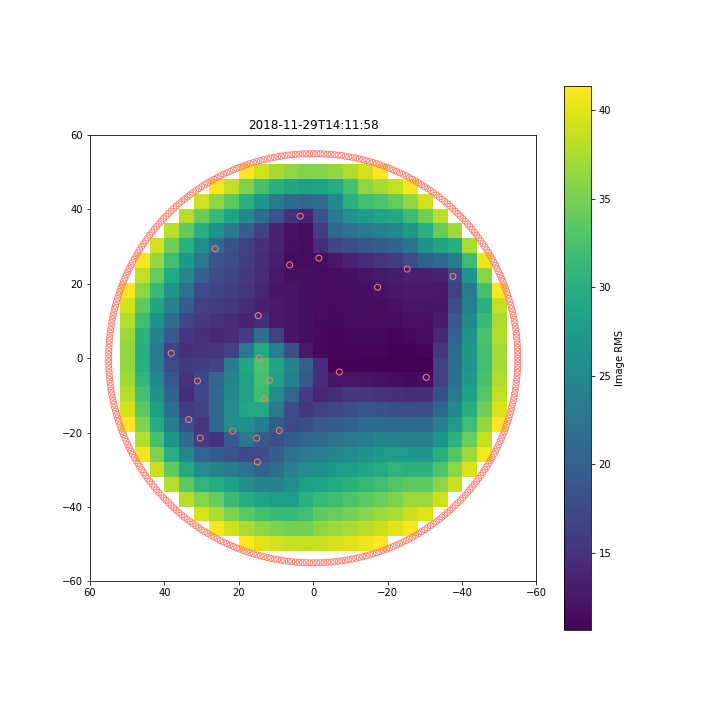

10.6477508817 41.3407926514 24.5215062433
8.07582598555 68.0202708633 14.6913496849


<IPython.core.display.Javascript object>


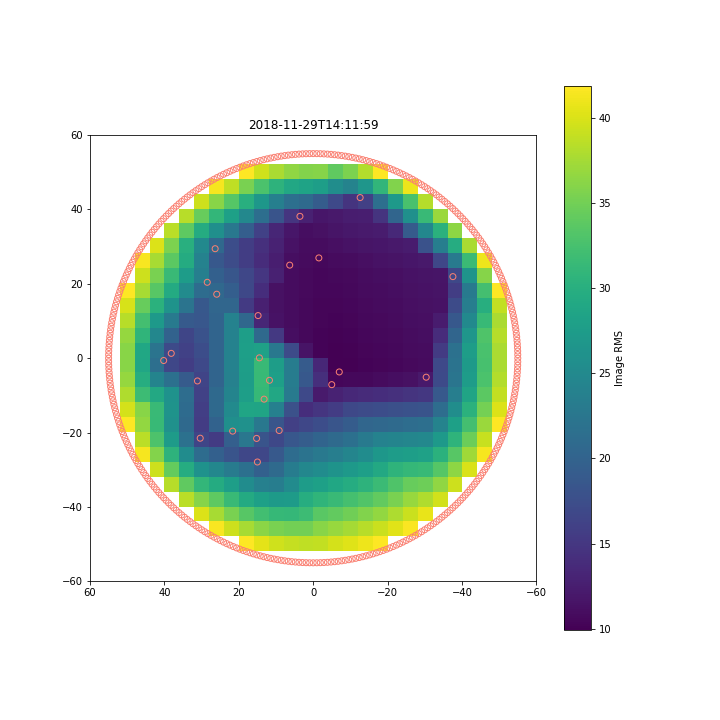

9.92270574489 41.8605857911 24.0142616796
8.88751446873 69.5416989423 14.2120226896


<IPython.core.display.Javascript object>


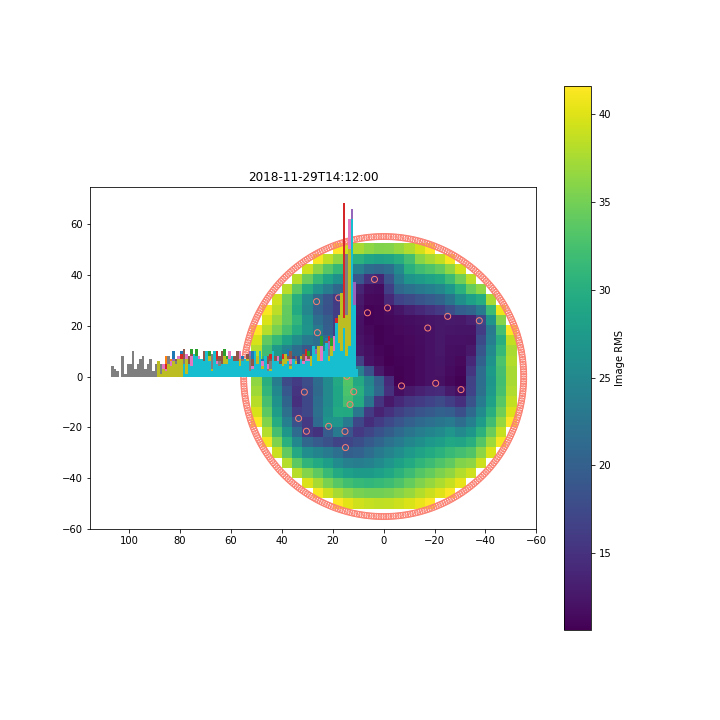

10.6253327299 41.5996304431 24.9534506141
8.58446870767 68.5152488833 14.7153779167


In [135]:
from astropy.coordinates import AltAz, EarthLocation,SkyCoord, get_sun
from astropy.time import Time
from astropy import units as u
import astropy.io.fits as fits
import csv
import scipy as sp

CS002 = EarthLocation.from_geocentric (3826577.109500000, 
                                       461022.900196000, 
                                       5064892.758, 'm')

xgrid, ygrid = np.meshgrid(np.linspace(-60,60,30), 
                           np.linspace(-60,60,30))

sensitivity = []
area = 0

for i in np.unique(data.taustart_ts)[-10:]:
    img_dat = data[(data.taustart_ts == i) & (data.freq_eff > 60000000)]
    img_rms = img_dat.f_int/img_dat.det_sigma

#     scaled_rms = (img_rms - img_rms.min()) / img_rms.ptp()
#     colors = plt.cm.coolwarm(scaled_rms)

    position = SkyCoord(img_dat.ra.values*u.degree,
                        img_dat.decl.values*u.degree)  
    
    position = position.transform_to(AltAz(obstime=pd.to_datetime(i), location=CS002))
    
    cart_x, cart_y = pol2cart(np.abs(np.append(90-position.alt.deg,(np.ones(360)*55.))), 
                          np.append(position.az.rad, np.deg2rad(np.arange(0,360))))
    
    f = sp.interpolate.griddata((cart_x, cart_y),
                            np.append(np.abs(img_rms),
                                      np.mean([img_dat.rms_max.iloc[0],img_dat.rms_qc.iloc[0]])*np.ones(360)),
                        (xgrid, ygrid), method="linear")

    sensitivity.append(f[np.isfinite(f)])
    
    plt.figure(figsize=(10,10))

    plt.imshow(f.T[:,::-1],origin="lower", extent=[60,-60,-60,60], aspect="equal")
    plt.colorbar(label="Image RMS")
    plt.scatter(cart_y,cart_x, facecolor="none",edgecolor="salmon" )
    
    plt.title(pd.to_datetime(i).strftime("%Y-%m-%dT%H:%M:%S"))

    print np.nanmin(np.abs(f)), np.nanmax(f), np.nanmean(f)
    print img_dat.rms_min.iloc[0], img_dat.rms_max.iloc[0], img_dat.rms_qc.iloc[0]
    plt.show()

In [245]:
output = pd.DataFrame({"sensitivity":sensitivity, "area":area})

In [246]:
output = output.groupby("sensitivity").agg({"sensitivity":"mean", "area":"sum"})

In [28]:
# area calculated using ds9, 400 pix from zenith 

# arcsec^2 to degree^2
print (8.1574606*10**10.)*(3282.8/(4.25*10.**10.))

print (7.8827889*10**10.)*(3282.8/(4.25*10.**10.))

6301.01450769
6088.85162375


In [32]:
10313./6300.


1.636984126984127

In [249]:
# import csv

# sensitivity = np.array(sensitivity, dtype=float).ravel()

with open('/home/kuiack/test.csv') as csvfile:
    sensitivity2 = list(csv.reader(csvfile))

sensitivity2 = np.array(sensitivity2, dtype=float).ravel()

In [ ]:
# (8.1574606*10**10.)*(3282.8/(4.25*10.**10.))

<IPython.core.display.Javascript object>


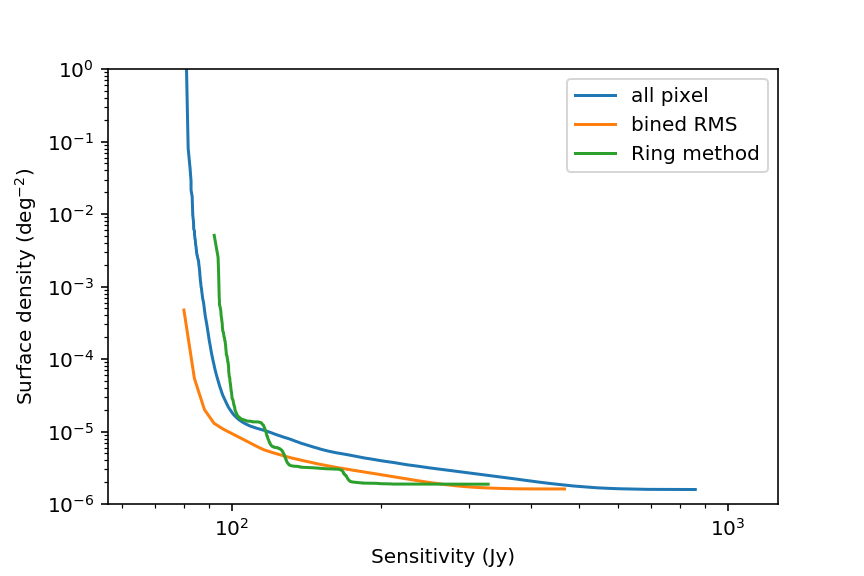

In [256]:
# sensitivity = np.array(sensitivity).ravel()
# idx = np.argsort(sensitivity)

sigma = 8.
area_sum = []

idx = np.argsort(output.sensitivity)
area_sum.append(np.array(output.area)[idx][0])

for i in range(len(output.area)-1):
#     idx = np.argsort(sensitivity)
    area_sum.append(np.sum(np.array(output.area)[idx][:i+2]))




with open('/home/kuiack/test.csv') as csvfile:
    sensitivity2 = list(csv.reader(csvfile))

sensitivity2 = np.array(sensitivity2, dtype=float).ravel()
sensitivity2 = np.array(sensitivity2).ravel()
idx2 = np.argsort(sensitivity2)


plt.figure()

# area normalization might not be right
# plt.plot(8*np.array(sensitivity)[idx],1./((6294./556.)*(np.arange(len(idx))+1)))
plt.plot(sigma*np.array(sensitivity2)[idx2],
         1./((6300./556.)*np.arange(len(idx2))+1), label="all pixel" )

plt.plot(sigma*np.array(output.sensitivity)[idx], 
         1./(np.array(area_sum)), label="bined RMS" )

plt.plot(sigma*np.array(tot_survey["sensitivity"])[survey_idx],
         1./(np.array(tot_area_sum)), label="Ring method")


plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])

plt.xlabel('Sensitivity (Jy)')
plt.ylabel(r'Surface density (deg$^{-2}$)')
plt.legend()
plt.show()

In [ ]:
tot_survey = pd.read_csv("/data/survey/sensitivity_plot.csv")

tot_area_sum = []

survey_idx = np.argsort(tot_survey.index)

tot_area_sum.append(np.array(tot_survey["area"])[survey_idx][0])
plt.figure()
for i in range(len(tot_survey["area"])-1):
#     idx = np.argsort(sensitivity)
    tot_area_sum.append(np.sum(np.array(tot_survey["area"])[survey_idx][:i+2]))

plt.plot(np.array(tot_survey.index)[survey_idx],1./(np.array(tot_area_sum)))
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])

<IPython.core.display.Javascript object>

(1e-12, 1.0)

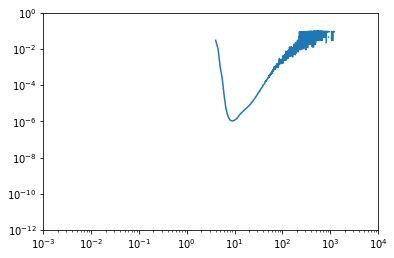

In [557]:

sort_survey = np.argsort(tot_survey.groupby("sensitivity").sum())

plt.plot(tot_survey["sensitivity"], 
         1./tot_survey["area"])

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])

In [ ]:
plt.plot(np.cumsum(tot_survey["area"]).index[::-1], 
         1./(600*np.cumsum(tot_survey["area"])[::-1]))
plt.scatter(100,2e-10)

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-3,1e4])
plt.ylim([1e-12,1e0])

In [ ]:
# pixel and bin method agree, 
# bin method allows for holding less data -> += new bin heights. 

# compare with ring method, (which is 100x slower to compute)

#  money 

In [353]:
len(f[np.isfinite(f)])*(6294./1132.)


6294.000000000001

10.0569935304 33.6707986523
7.84511026397 140.896746459 13.8804005414


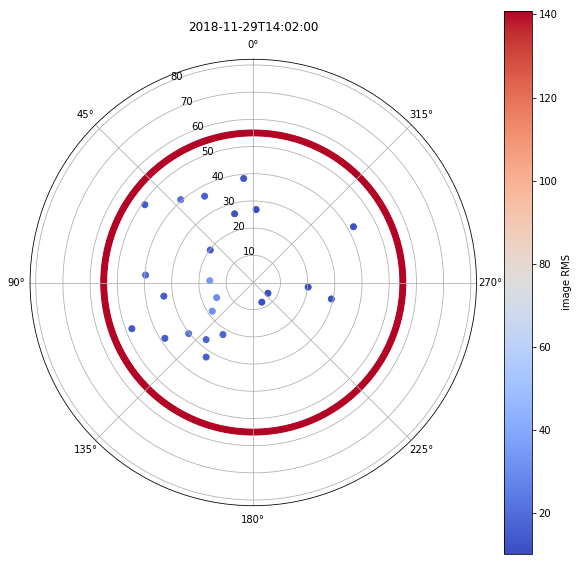

In [178]:
from astropy.coordinates import AltAz, EarthLocation,SkyCoord, get_sun
from astropy.time import Time
from astropy import units as u
import astropy.io.fits as fits


CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')


for i in [np.unique(data.taustart_ts)[0]]:
    img_dat = data[(data.taustart_ts == i) & (data.freq_eff > 60000000)]
    img_rms = img_dat.f_int/img_dat.det_sigma

#     scaled_rms = (img_rms - img_rms.min()) / img_rms.ptp()
#     colors = plt.cm.coolwarm(scaled_rms)

    position = SkyCoord(img_dat.ra.values*u.degree,
                        img_dat.decl.values*u.degree)  
    
    position = position.transform_to(AltAz(obstime=pd.to_datetime(i), location=CS002))
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, projection="polar", adjustable="box")
    ax.set_theta_zero_location("N")
    plt.scatter(np.append(position.az.rad, np.deg2rad(np.arange(0,360)*u.deg)),
                np.append(90-position.alt.deg,(np.ones(360)*55.)*u.deg),
                c=np.append(np.abs(img_rms),img_dat.rms_max.iloc[0]*np.ones(360)), cmap="coolwarm")
#     plt.scatter(np.deg2rad(np.arange(0,360)*u.deg),
#                 (np.ones(360)*55.)*u.deg,
#                 c=img_dat.rms_max.iloc[0]*np.ones(360), cmap="coolwarm")
    
    
#     plt.figure(figsize=(10,6))
    plt.title(pd.to_datetime(i).strftime("%Y-%m-%dT%H:%M:%S"))
#     plt.scatter(img_dat.ra, img_dat.decl, c=img_rms, cmap="coolwarm")
    plt.colorbar(label="image RMS")

    print np.min(np.abs(img_rms)), np.max(img_rms)
    print img_dat.rms_min.iloc[0], img_dat.rms_max.iloc[0], img_dat.rms_qc.iloc[0]
    plt.show()

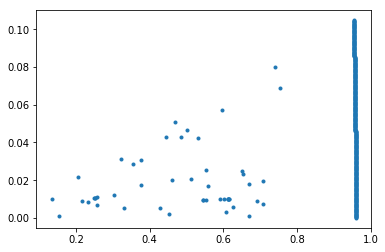

In [126]:
cart_x, cart_y = pol2cart(np.deg2rad(np.append(90-position.alt.deg,(np.ones(360)*55.))),
    np.deg2rad(np.append(position.az.rad, np.deg2rad(np.arange(0,360)))))

plt.plot(cart_x,cart_y,".")

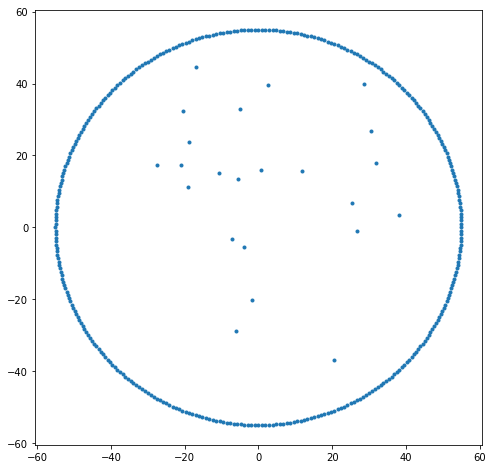

In [179]:
cart_x, cart_y = pol2cart(np.abs(np.append(90-position.alt.deg,(np.ones(360)*55.))), 
                          np.append(position.az.rad, np.deg2rad(np.arange(0,360))))
plt.figure(figsize=(8,8))
plt.plot(cart_x,cart_y,".")


10.0804668373


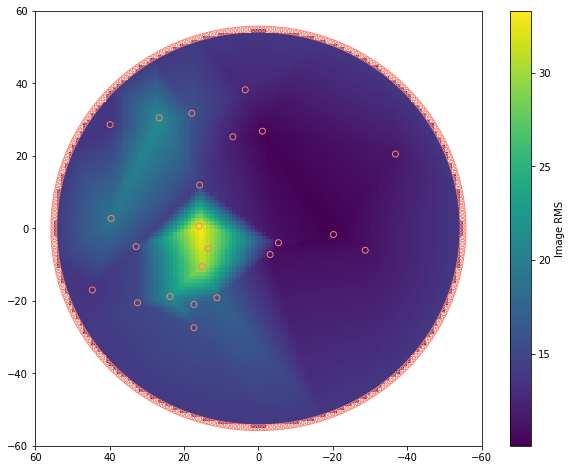

In [228]:


xgrid,ygrid = np.meshgrid(np.linspace(-60,60,120), np.linspace(-60,60,120))

f = sp.interpolate.griddata((cart_x, cart_y),
                            np.append(np.abs(img_rms),img_dat.rms_qc.iloc[0]*np.ones(360)),
                        (xgrid, ygrid), method="linear")


plt.figure(figsize=(10,8))

plt.imshow(f.T[:,::-1],origin="lower", extent=[60,-60,-60,60], aspect="auto")
plt.colorbar(label="Image RMS")
plt.scatter(cart_y,cart_x, facecolor="none",edgecolor="salmon" )
print np.nanmin(f)
# plt.tight_layout()

In [252]:
np.sum(np.isfinite(f))

9364

In [254]:
len(f.ravel())

14400

In [248]:
img_dat.rms_max.iloc[0]

41.465082125670499

In [118]:
position.alt.deg

array([ 58.79483653,  58.757539  ,  62.02938058,  61.16441303,
        75.70275476,  75.60911311,  49.50714349,  54.96059218,
        75.50505915,  54.84277988,  54.83591313,  55.62736127,
        71.38052909,  54.78931311,  49.41254301,  56.1780709 ,
        78.09783116,  55.45956842,  47.35363481,  55.16032887,
        75.23430459,  54.78785566,  65.51128162,  77.65241382,
        81.21563633,  68.37251676,  54.1621171 ,  46.6429683 ,
        59.40872949,  69.64868598,  64.44255785,  82.32096422,
        63.05426684,  51.6581517 ,  64.05124741,  68.41728838,
        76.60592229,  72.61370119,  58.20981171,  71.14222156,
        63.52913307,  75.25376113,  60.68634433,  50.31646   ,
        58.33337145,  52.63531884,  57.99816581,  52.48580793,  51.54770037])

<a id='fluxandposition'></a>

## Flux and position uncertainty 

Get flux and position distribution of all AARTFAAC sources.

In [9]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata

In [11]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


In [12]:
i = 0
ra = aart["ra"].iloc[i]
decl = aart["decl"].iloc[i]

AS_db = "ASf_201803091515"
dataset = 1

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

source_search = """
    SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE
        runningcatalog.wm_ra >= {} AND
        runningcatalog.wm_ra <= {} AND
        runningcatalog.wm_decl >= {} AND
        runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

search_result = pd.DataFrame(run_query(source_search, AS_db, dataset, 
                          engine, host, port, user, password))

db._configured = False
del db, session

print i, len(search_result)

if len(search_result) > 0:

    db = tkp.db.Database(engine=engine, host=host, port=port,
                 user=user, password=password, database=AS_db)
    db.connect()
    session = db.Session()

    source_query = """
        SELECT ex.f_int, ex.f_int_err, ex.f_peak,
            ex.det_sigma, ex.extract_type,
            ex.ra,
            ex.decl,
            im.taustart_ts,
            im.freq_eff
            FROM extractedsource ex, image im
            WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
            AND ex.image = im.id;"""\
    .format(search_result[(search_result.datapoints == np.max(search_result.datapoints))].id.values[0])

    data = pd.DataFrame(run_query(source_query, AS_db, dataset, 
                              engine, host, port, user, password))

    db._configured = False
    del db, session
    
pd.DataFrame({"db":[AS_db],  
              "id": i,
              "freq_band":58.3,
              "rel_f_int": np.mean(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "rel_f_int_err":np.std(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "ra": np.mean(clip(data[(data.freq_eff < 60000000)].ra)), 
              "ra_err": np.std(clip(data[(data.freq_eff < 60000000)].ra)),
              "decl": np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
              "decl_err": np.std(clip(data[(data.freq_eff < 60000000)].decl)),})

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


0 12


db       decl  decl_err  freq_band  id          ra    ra_err  \
0  ASf_201803091515  49.530777  0.058826       58.3   0  176.592643  0.078083   

   rel_f_int  rel_f_int_err  
0    1.42906       0.594523

In [13]:
pd.DataFrame({"db":[AS_db],  
              "id": i,
              "freq_band":58.3,
              "rel_f_int": np.mean(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "rel_f_int_err":np.std(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "ra": np.mean(clip(data[(data.freq_eff < 60000000)].ra)), 
              "ra_err": np.std(clip(data[(data.freq_eff < 60000000)].ra)),
              "decl": np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
              "decl_err": np.std(clip(data[(data.freq_eff < 60000000)].decl)),})

db       decl  decl_err  freq_band  id          ra    ra_err  \
0  ASf_201803091515  49.530777  0.058826       58.3   0  176.592643  0.078083   

   rel_f_int  rel_f_int_err  
0    1.42906       0.594523

1.44218470565 0.766847487435
1.42905974779 0.594522861245
0.0547520110112 0.0269244096478
0.0780831169559 0.0588262575863


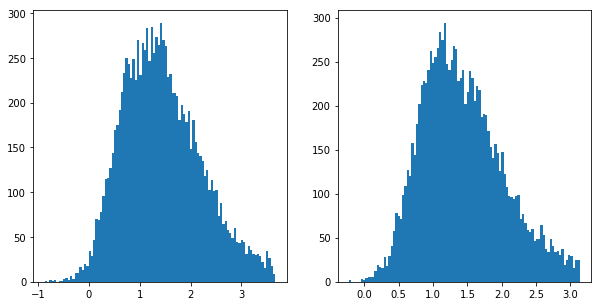

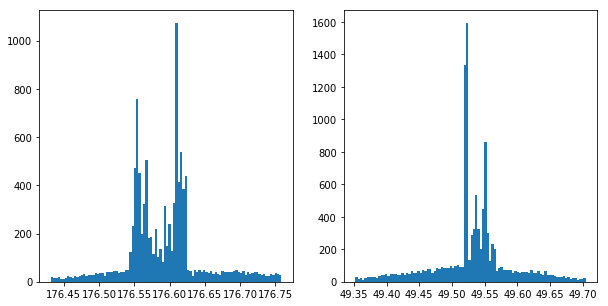

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_x = plt.hist(clip(data[(data.freq_eff > 60000000)].f_int)/aart.iloc[i].f_int, bins=100)
plt.subplot(122)
_x = plt.hist(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int, bins=100)

print np.mean(clip(data[(data.freq_eff > 60000000)].f_int)/aart.iloc[i].f_int), np.std(clip(data[(data.freq_eff > 60000000)].f_int)/aart.iloc[i].f_int)
print np.mean(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int), np.std(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int)

plt.figure(figsize=(10,5))
plt.subplot(121)
_x = plt.hist(clip(data[(data.freq_eff > 60000000)].ra), bins=100)
plt.subplot(122)
_x = plt.hist(clip(data[(data.freq_eff < 60000000)].decl), bins=100)

print np.std(clip(data[(data.freq_eff > 60000000)].ra)), np.std(clip(data[(data.freq_eff > 60000000)].decl))
print np.std(clip(data[(data.freq_eff < 60000000)].ra)), np.std(clip(data[(data.freq_eff < 60000000)].decl))

# _x = plt.hist(clip(data[(data.freq_eff > 60000000)].f_int)/aart.iloc[i].f_int, bins=100)

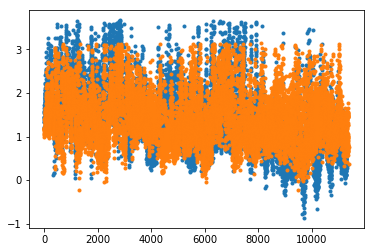

In [17]:
plt.figure()
plt.plot(clip(data[(data.freq_eff > 60000000)].f_int)/aart["f_int"].iloc[i], ".")
plt.plot(clip(data[(data.freq_eff < 60000000)].f_int)/aart["f_int"].iloc[i], ".")

In [18]:
start_time = time.time()
fit_out = fit_lightcurve(clip(data[(data.freq_eff < 60000000)].f_int), draws=100, chains=4, njobs=4)
print time.time() - start_time

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 600/600 [00:28<00:00, 21.22it/s]


86.9029710293


In [19]:
fit_out/aart["f_int"].iloc[i]

array([ 1.190133  ,  0.01088038,  0.90444148,  0.00928309])

In [112]:
fit_out/aart["f_int"].iloc[i]

array([ 1.17569157,  0.01455004,  1.14419648,  0.01279939])

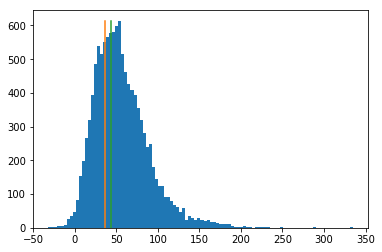

In [20]:
plt.figure()
_x = plt.hist(data[(data.freq_eff > 60000000)].f_int, bins=100)
plt.plot([aart["f_int"].iloc[i],aart["f_int"].iloc[i]],[0,np.max(_x[0])])
plt.plot([fit_out[0],fit_out[0]],[0,np.max(_x[0])])

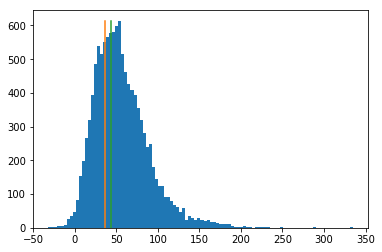

In [113]:
plt.figure()
_x = plt.hist(data[(data.freq_eff > 60000000)].f_int, bins=100)
plt.plot([aart["f_int"].iloc[i],aart["f_int"].iloc[i]],[0,np.max(_x[0])])
plt.plot([fit_out[0],fit_out[0]],[0,np.max(_x[0])])

In [ ]:
pd.DataFrame({"db": , 
              "id": ,
              "freq_eff":, 
              "rel_f_int": ,
              "rel_f_int_err": ,
              "ra": , 
              "ra_err": ,
              "decl": ,
              "decl_err": ,})

In [134]:
aart

N       Name   decl  decl_err   f_int  f_int_err     loc  loc_err  \
0     8194  J1147+496  49.65      0.06   36.86       0.15   31.98     0.12   
1    34840  J0321+416  41.69      0.08  306.40       0.12  295.88     0.19   
2    41894  J0329+553  55.38      0.08   84.62       0.07   78.45     0.11   
3    10737  J0302+508  50.87      0.07   50.00       0.09   45.79     0.15   
4    48715  J0220+625  62.54      0.12  158.57       0.18  142.35     0.16   
5    36406  J0224+430  43.06      0.10   96.47       0.10   88.40     0.09   
6    41604  J0839+651  65.17      0.08   41.06       0.04   37.68     0.08   
7    19722  J0428+769  76.94      0.16   46.53       0.12   41.60     0.07   
8    22018  J0855+139  13.90      0.08   64.32       0.13   56.72     0.17   
9    26647  J0707+633  63.32      0.07   39.24       0.05   35.81     0.09   
10   15903  J0646+213  21.35      0.08   61.08       0.12   55.26     0.17   
11   55924  J0657+542  54.23      0.09   56.75       0.06   51.24     0.11   
12   73615  J1035+581  58.19      0.10   58.04       0.09   50.83     0.24   
13   49055  J1146+315  31.54      0.09   60.55       0.11   52.09     0.16   
14   74465  J0712+748  74.83      0.10   53.18       0.06   47.56     0.10   
15   34053  J1259+278  27.82      0.08   58.63       0.06   59.12     1.54   
16   33194  J0438+297  29.75      0.07  462.85       0.33  438.11     0.49   
17   61784  J1115+405  40.58      0.09   61.78       0.15   50.50     0.09   
18   39290  J1146+195  19.59      0.09   80.30       0.13   69.63     0.15   
19   49824  J0841+578  57.89      0.11   43.48       0.07   37.62     0.10   
20   57674  J0750+558  55.84      0.07   54.34       0.05   50.14     0.13   
21   64167  J0952+731  73.18      0.10   49.90       0.04   47.81     0.41   
22    7804  J1836+326  32.69      0.08   56.65       0.22   50.16     0.15   
23   40369  J1533+239  23.96      0.08   57.89       0.13   49.36     0.10   
24   55956  J0912+377  37.79      0.09   63.12       0.12   54.60     0.08   
25   57615  J1506+259  25.97      0.07  127.36       0.13  112.69     0.11   
26    8597  J1630+442  44.30      0.10   48.80       0.19   42.93     0.18   
27   27047  J0224+401  40.15      0.07   55.38       0.08   49.47     0.06   
28   15365  J0731+246  24.61      0.07   41.16       0.08   37.80     0.12   
29   46342  J2022+403  40.37      0.07  671.39       0.29  644.72     0.43   
..     ...        ...    ...       ...     ...        ...     ...      ...   
137  18542  J0240+593  59.37      0.06   56.82       0.08   52.41     0.09   
138  20126  J0311+171  17.19      0.06   68.23       0.10   62.32     0.16   
139   7650  J0258+062   6.23      0.06   80.23       0.21   74.50     0.59   
140  56715  J2118+608  60.88      0.08   96.04       0.07   89.62     0.13   
141  18931  J1236+212  21.23      0.08   46.24       0.10   40.99     0.11   
142   8780  J1523+076   7.66      0.08   71.86       0.13   66.71     0.23   
143  31019  J1407+341  34.13      0.07   48.77       0.14   41.17     0.15   
144  45160  J1351+643  64.36      0.09   47.26       0.07   42.09     0.15   
145  62202  J1830+487  48.74      0.08  136.75       0.09  127.96     0.19   
146  31047  J1518+070   7.01      0.06  114.72       0.12  117.79     2.38   
147  42515  J1525+543  54.38      0.08   46.64       0.04   47.26     1.18   
148  17491  J2021+297  29.73      0.06  103.62       0.14   97.94     0.43   
149  49609  J1013+463  46.34      0.09   46.28       0.08   39.62     0.07   
150   7457  J0802+614  61.48      0.08   42.35       0.10   38.93     0.14   
151  29749  J1007+347  34.78      0.09   39.54       0.11   34.27     0.06   
152   5008  J1151+127  12.74      0.09   49.69       0.15   44.88     0.19   
153   4537  J1217+534  53.46      0.05   34.14       0.12   31.09     0.13   
154  24996  J1844+455  45.56      0.06   54.96       0.07   49.80     0.07   
155  11854  J1210+436  43.62      0.06   33.98       0.10   30.00     0.09   
156  11552  J1312+273  27.40   

In [133]:
print aart["ra"].iloc[2], aart["decl"].iloc[2]
print zip(aart["ra"], aart["decl"])

52.43 55.38
[(176.84, 49.65), (50.29, 41.69), (52.43, 55.38), (45.65, 50.87), (35.09, 62.54), (36.13, 43.06), (129.99, 65.17), (67.22, 76.94), (133.77, 13.9), (106.85, 63.32), (101.69, 21.35), (104.47, 54.23), (158.84, 58.19), (176.75, 31.54), (108.06, 74.83), (194.97, 27.82), (69.67, 29.75), (168.93, 40.58), (176.6, 19.59), (130.39, 57.89), (117.74, 55.84), (148.11, 73.18), (279.13, 32.69), (233.26, 23.96), (138.09, 37.79), (226.55, 25.97), (247.62, 44.3), (36.19, 40.15), (112.75, 24.61), (305.61, 40.37), (17.59, 13.45), (24.47, 21.08), (152.77, 6.88), (81.79, 32.94), (204.08, 40.93), (74.09, 58.0), (145.38, 35.84), (295.42, 60.71), (144.24, 79.03), (221.46, 76.9), (150.85, 28.72), (253.12, 5.01), (215.61, 41.69), (167.23, 76.86), (206.71, 49.65), (303.94, 23.61), (193.76, 15.64), (38.96, 31.71), (120.73, 14.13), (167.61, 24.96), (155.09, 80.83), (341.79, 39.73), (179.17, 54.76), (134.97, 27.8), (266.6, 80.27), (237.76, 62.65), (147.37, 7.36), (242.77, 65.88), (69.68, 72.62), (321.25,

In [22]:
outfile = "/home/kuiack/complete_survey_catalogue_results.csv"
import csv 
if not os.path.exists(outfile):
    fields = ["db","id","freq_band","rel_f_int","rel_f_int_err","ra","ra_err","decl","decl_err"]
    with open(outfile, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

In [195]:
# Get all AARTFAAC DBs 

dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

# print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """
    SELECT datname from pg_database
    """

databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

AS_databases = [x for x in databases.datname if (x[:3] == "ASf") or (x[:3] == "ASr")]

db._configured = False
del db, session

# print len(AS_databases)
print len(AS_databases)

89


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [199]:
pd.DataFrame({"DBs":AS_databases }).to_csv("/home/kuiack/AS_databases.csv") 

In [62]:
db._configured = False
del db, session

NameError: name 'db' is not defined

In [105]:
# calculate survey time total time

dataset = 1
starttime = time.time()
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)


n_frames = []
all_time = [] 
for AS_db in AS_databases[::-1]:
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """SELECT taustart_ts FROM image"""


    DB_times = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                              engine, host, port, user, password))
    db._configured = False
    del db, session
    
    try:
        unq = np.unique(DB_times["taustart_ts"], 
                        return_index=True, 
                        return_counts=True)
        
        DB_times.drop(unq[1][unq[2] != 2], inplace=True)
        n_frames.append(len(np.unique(DB_times["taustart_ts"])))
        all_time.append(np.unique(DB_times["taustart_ts"]))
    except KeyError:
        print AS_db
        n_frames.append(0)



ASf_201905290920


In [103]:
print pd.DataFrame({"DBs":AS_databases,"nframes":n_frames}).sum().nframes/3600.
print pd.DataFrame({"DBs":AS_databases,"nframes":n_frames}).sum().nframes

545.252777778
1962910


In [118]:
flat_time = pd.to_datetime([y for x in all_time for y in x])

In [131]:
months_out = np.unique([str(x.year)+"-"+str(x.month).zfill(2) for x in flat_time], 
                       return_counts=True)

In [134]:
for mon, n_ in zip(months_out[0],months_out[1]):
    if n_ > 1:
        print mon, round(n_/3600.,1)

2016-08 2.5
2016-09 4.9
2016-11 0.6
2017-02 31.6
2018-03 26.8
2018-04 41.9
2018-07 24.2
2018-09 24.7
2018-10 70.9
2018-11 55.5
2018-12 15.4
2019-01 111.0
2019-02 34.1
2019-03 31.5
2019-05 63.4
2019-09 6.2


In [130]:
np.sum(months_out[1])/3600.

545.25277777777774

In [227]:
runcats = []
for AS_db in AS_databases[:-1]:
# AS_db = "ASf_201803091515"
    

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    source_search = """
        SELECT id FROM runningcatalog ORDER BY id DESC LIMIT 1;"""

    search_result = pd.DataFrame(run_query(source_search, AS_db, dataset, 
                              engine, host, port, user, password))
    print search_result.id.values[0]
    try:
        runcats.append(search_result.id.values[0])
    except AttributeError:
        print AS_db
    db._configured = False
    del db, session



3140
7337
1929
1076
3500
4816
4872
4259
2305
1597
737
2768
5931
3709
2537
4362
2498
796
739
1787
1471
2624
2858
3247
3164
2785
4906
3880
3194
2567
3093
2789
3607
5526
3874
4918
3749
8529
2785
2979
2189
3063
2693
1974
22848
27242
4420
1327
710
1141
5325
4299
7083
1694
10778
4829
1519
1922
1163
4124
3546
25484
4821
5168
2604
2793
2828
1078
2613
4475
3188
1749
10005
6841
7563
5951
6962
7659
7396
4598
2531
8781
3243
2159
2763
1945
2984
2239


In [229]:
np.sum(runcats)

387550

In [201]:
start_time  = time.time()
# ra = aart["ra"].iloc[i]
# decl = aart["decl"].iloc[i]
import csv
outfile = "/home/kuiack/survey_catalogue_results.csv"

if not os.path.exists(outfile):
    fields = ["db","id","freq_band","rel_f_int","rel_f_int_err",
              "ra","ra_err","decl","decl_err"]
    
    with open(outfile, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

dataset = 1
for AS_db in AS_databases:
# AS_db = "ASf_201803091515"
    

    # survey_stats = pd.DataFrame([])
    count = 0
    for ra, decl in zip(aart["ra"], aart["decl"]):

        current_cat_result = pd.read_csv("/home/kuiack/survey_catalogue_results.csv")
        
        if len(current_cat_result[(current_cat_result.id == count) & 
                   (current_cat_result.db == AS_db)]) > 0:
            count += 1
            continue
        
        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=AS_db)

        db.connect()
        session = db.Session()

        source_search = """
            SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE
                runningcatalog.wm_ra >= {} AND
                runningcatalog.wm_ra <= {} AND
                runningcatalog.wm_decl >= {} AND
                runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

        search_result = pd.DataFrame(run_query(source_search, AS_db, dataset, 
                                  engine, host, port, user, password))

        db._configured = False
        del db, session


        if len(search_result) == 0 or np.max(search_result.datapoints) < 3600:
            del search_result
            count += 1
            continue 

        _id = search_result[(search_result.datapoints == np.max(search_result.datapoints))].id.values[0]
        

            
        db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)
        db.connect()
        session = db.Session()

        source_query = """
            SELECT ex.f_int, ex.f_int_err, ex.f_peak,
                ex.det_sigma, ex.extract_type,
                ex.ra,
                ex.decl,
                im.taustart_ts,
                im.freq_eff
                FROM extractedsource ex, image im
                WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                AND ex.image = im.id;""".format(_id)

        data = pd.DataFrame(run_query(source_query, AS_db, dataset, 
                                  engine, host, port, user, password))

        db._configured = False
        del db, session

        fit_out = fit_lightcurve(clip(data[(data.freq_eff > 60000000)].f_int), draws=10, chains=1, njobs=4)

    #     survey_stats  = pd.concat([survey_stats, 
    #         pd.DataFrame({"db": [AS_db], 
    #               "id": count,
    #               "freq_band": 61.8, 
    #               "rel_f_int": fit_out[0]/aart.iloc[count].f_int,
    #               "rel_f_int_err": fit_out[2]/aart.iloc[count].f_int,
    #               "ra": np.mean(clip(data[(data.freq_eff > 60000000)].ra)), 
    #               "ra_err": np.std(clip(data[(data.freq_eff > 60000000)].ra)),
    #               "decl": np.mean(clip(data[(data.freq_eff > 60000000)].decl)),
    #               "decl_err": np.std(clip(data[(data.freq_eff > 60000000)].decl)),}),]) 

        with open(outfile, 'a') as f:
            writer = csv.writer(f)
            writer.writerow([AS_db,
                             count,
                             61.8,
                             fit_out[0]/aart.iloc[count].f_int,
                             fit_out[2]/aart.iloc[count].f_int,
                             np.mean(clip(data[(data.freq_eff > 60000000)].ra)),
                             np.std(clip(data[(data.freq_eff > 60000000)].ra)),
                             np.mean(clip(data[(data.freq_eff > 60000000)].decl)),
                             np.std(clip(data[(data.freq_eff > 60000000)].decl))])

        fit_out = fit_lightcurve(clip(data[(data.freq_eff < 60000000)].f_int), draws=10, chains=1, njobs=4)

    #     survey_stats  = pd.concat([survey_stats, 
    #         pd.DataFrame({"db":[AS_db],  
    #               "id": count,
    #               "freq_band":58.3,
    #               "rel_f_int": fit_out[0]/aart.iloc[count].f_int,
    #               "rel_f_int_err": fit_out[2]/aart.iloc[count].f_int,
    #               "ra": np.mean(clip(data[(data.freq_eff < 60000000)].ra)), 
    #               "ra_err": np.std(clip(data[(data.freq_eff < 60000000)].ra)),
    #               "decl": np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
    #               "decl_err": np.std(clip(data[(data.freq_eff < 60000000)].decl)),}),]) 


        with open(outfile, 'a') as f:
            writer = csv.writer(f)
            writer.writerow([AS_db,
                             count,
                             58.3,
                             fit_out[0]/aart.iloc[count].f_int,
                             fit_out[2]/aart.iloc[count].f_int,
                             np.mean(clip(data[(data.freq_eff < 60000000)].ra)),
                             np.std(clip(data[(data.freq_eff < 60000000)].ra)),
                             np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
                             np.std(clip(data[(data.freq_eff < 60000000)].decl))])


        count += 1    
    
print time.time() - start_time

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104

INFO:pymc3:Sequential sampling (1 chains in 1 job)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 510/510 [00:05<00:00, 101.24it/s]
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (1 chains in 1 job)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 510/510 [00:06<00:00, 83.23it/s] 
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:theano.gof.compilelock:Refreshing lock /afhome/kuiack/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64

KeyboardInterrupt: 

In [199]:
current_cat_result = pd.read_csv("/home/kuiack/survey_catalogue_results.csv")

len(current_cat_result[(current_cat_result.id == count) & 
                   (current_cat_result.db == AS_db)])

1

In [13]:
def process_fluxposition(AS_db):
# AS_db = "ASf_201803091515"
    # survey_stats = pd.DataFrame([])
    count = 0
    for ra, decl in zip(aart["ra"], aart["decl"]):

        current_cat_result = pd.read_csv("/home/kuiack/complete_survey_catalogue_results.csv")

        if len(current_cat_result[(current_cat_result.id == count) & 
                   (current_cat_result.db == AS_db)]) > 0:
            count += 1
            continue

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=AS_db)

        db.connect()
        session = db.Session()

        source_search = """
            SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE
                runningcatalog.wm_ra >= {} AND
                runningcatalog.wm_ra <= {} AND
                runningcatalog.wm_decl >= {} AND
                runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

        search_result = pd.DataFrame(run_query(source_search, AS_db, dataset, 
                                  engine, host, port, user, password))
        db.close()
        db._configured = False
        del db, session


        if len(search_result) == 0 or np.max(search_result.datapoints) < 3600:
            del search_result
            count += 1
            continue 

        _id = search_result[(search_result.datapoints == np.max(search_result.datapoints))].id.values[0]



        db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)
        db.connect()
        session = db.Session()

        source_query = """
            SELECT ex.f_int, ex.f_int_err, ex.f_peak,
                ex.det_sigma, ex.extract_type,
                ex.ra,
                ex.decl,
                im.taustart_ts,
                im.freq_eff
                FROM extractedsource ex, image im
                WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                AND ex.image = im.id;""".format(_id)

        data = pd.DataFrame(run_query(source_query, AS_db, dataset, 
                                  engine, host, port, user, password))
        db.close()
        db._configured = False
        del db, session

        try:
            fit_out = fit_lightcurve(clip(data[(data.freq_eff > 60000000)].f_int), 
                                     draws=100, chains=4, njobs=4)
            with open(outfile, 'a') as f:
                writer = csv.writer(f)
                writer.writerow([AS_db,
                             count,
                             61.8,
                             fit_out[0]/aart.iloc[count].f_int,
                             fit_out[2]/aart.iloc[count].f_int,
                             np.mean(clip(data[(data.freq_eff > 60000000)].ra)),
                             np.std(clip(data[(data.freq_eff > 60000000)].ra)),
                             np.mean(clip(data[(data.freq_eff > 60000000)].decl)),
                             np.std(clip(data[(data.freq_eff > 60000000)].decl))])
        except IndexError:
            print AS_db, count, "61.8 bad?"


        try:
            fit_out = fit_lightcurve(clip(data[(data.freq_eff < 60000000)].f_int), 
                                     draws=100, chains=4, njobs=4)
            with open(outfile, 'a') as f:
                writer = csv.writer(f)
                writer.writerow([AS_db,
                             count,
                             58.3,
                             fit_out[0]/aart.iloc[count].f_int,
                             fit_out[2]/aart.iloc[count].f_int,
                             np.mean(clip(data[(data.freq_eff < 60000000)].ra)),
                             np.std(clip(data[(data.freq_eff < 60000000)].ra)),
                             np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
                             np.std(clip(data[(data.freq_eff < 60000000)].decl))])
        except IndexError:
            print AS_db, count, "58.3 bad?"





        count += 1    
    return 


In [19]:
print "hello"

hello


In [ ]:
from joblib import Parallel, delayed
from subprocess import Popen, PIPE
import csv 

outfile = "/home/kuiack/complete_survey_catalogue_results.csv"

if not os.path.exists(outfile):
    fields = ["db","id","freq_band","rel_f_int","rel_f_int_err","ra","ra_err","decl","decl_err"]
    with open(outfile, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(fields)


# def process_fluxposition(AS_db):
#     process = Popen(['python','/home/kuiack/get_cat_results.py', AS_db])
#     process.wait()

# out = Parallel(n_jobs=3)(delayed(process_fluxposition)(AS_db) for AS_db in AS_databases)

for AS_db in AS_databases:
    t1 = time.time()
    process_fluxposition(AS_db)
    print "####", "time for ", AS_db, time.time()-t1

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...


#### time for  ASf_20181103 5.07231712341


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

#### time for  ASf_20181104 4.51698899269


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...


#### time for  ASf_20181105 4.01365303993


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

#### time for  ASf_20190101 4.31218481064


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181231

#### time for  ASf_20181231 4.81417298317


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190113

#### time for  ASf_20190113 3.05103588104


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190120
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

#### time for  ASf_20190120 4.77674984932


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190119
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

#### time for  ASf_20190119 5.25851511955


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190118
INFO:tkp.db.database:connecting to database...


#### time for  ASf_20190118 4.10362911224


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190117

#### time for  ASf_20190117 3.82918190956


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190110

#### time for  ASf_20190110 5.54232597351


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190129

#### time for  ASf_20190129 3.57374215126


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190126
INFO:tkp.db.database:connecting to database...


#### time for  ASf_20190126 4.10250091553


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201804281040
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkui

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...


#### time for  ASf_201804281040 3.95855593681


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190106

#### time for  ASf_20190106 6.62628102303


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 600/600 [00:18<00:00, 32.13it/s]
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 600/600 [00:22<00:00, 26.32it/s]
INFO:pymc3:The number of effective samples is s

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 600/600 [00:17<00:00, 33.48it/s]
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]
100%|██████████| 600/600 [00:15<00:00, 38.34it/s]


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190109
INFO:tkp.db.database:connecting to database...
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [skew, scale, loc]


In [41]:
db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_databases[0])

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103


In [45]:
db.close()
del db

NameError: name 'db' is not defined

In [26]:
% matplotlib notebook
plt.figure(figsize=(10,5))
plt.hist(survey_stats.rel_f_int, bins=100)


<IPython.core.display.Javascript object>

NameError: name 'survey_stats' is not defined

In [83]:
pd.DataFrame({"db":[AS_db],  
              "id":_id,
              "freq_band":58.3, 
              "rel_f_int": np.mean(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "rel_f_int_err":np.std(clip(data[(data.freq_eff < 60000000)].f_int)/aart.iloc[i].f_int),
              "ra": np.mean(clip(data[(data.freq_eff < 60000000)].ra)), 
              "ra_err": np.std(clip(data[(data.freq_eff < 60000000)].ra)),
              "decl": np.mean(clip(data[(data.freq_eff < 60000000)].decl)),
              "decl_err": np.std(clip(data[(data.freq_eff < 60000000)].decl)),})

db       decl  decl_err  freq_band    id          ra  \
0  ASf_201803091515  49.523496  0.097208       58.3  1655  176.624061   

     ra_err  rel_f_int  rel_f_int_err  
0  0.149679    1.29549       0.364678

In [34]:
db._configured = False
del db, session

In [ ]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")



for ra, decl in zip(aart["ra"],aart["decl"]):
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    source_search = """
        SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
            runningcatalog.wm_ra >= {} AND 
            runningcatalog.wm_ra <= {} AND 
            runningcatalog.wm_decl >= {} AND 
            runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, dec-1.0, dec+1.0)

    search_result = pd.DataFrame(run_query(source_search, AS_db, dataset, 
                              engine, host, port, user, password))

    db._configured = False
    del db, session

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    source_query = """
        SELECT ex.f_int, ex.f_int_err, ex.f_peak, 
            ex.det_sigma, extract_type, 
            ex.ra, 
            ex.decl, 
            im.taustart_ts,
            im.freq_eff,
            FROM extractedsource ex, image im 
            WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {}) 
            AND ex.image = im.id ;"""\
    .format(search_result[(search_result.datapoints == np.max(search_result.datapoints))].id.values)

    data = pd.DataFrame(run_query(source_query, AS_db, dataset, 
                              engine, host, port, user, password))

    db._configured = False
    del db, session

In [ ]:
# AS_db = "ASr_201609051647"
dataset = 1
starttime = time.time()
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

# for t1, t2 in zip(time_intervals[:-1],time_intervals[1:]):
t1 = '2018-11-29 14:02:00'
t2 = '2018-11-29 14:12:00'

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    SELECT  im.taustart_ts
            ,im.freq_eff
            ,im.band
            ,im.rms_min
            ,im.rms_max
            ,im.rms_qc
            ,ex.f_int
            ,ex.f_int_err
            ,ex.f_peak
            ,ex.f_peak_err
            ,ex.ra
            ,ex.decl
            ,ex.ra_err
            ,ex.decl_err
            ,ex.det_sigma
    FROM extractedsource ex
         ,image im
   WHERE ex.image = im.id
       AND ex.extract_type = 0
       AND im.id IN (SELECT im.id 
                        FROM image im 
                        WHERE im.taustart_ts 
                        BETWEEN '{}' AND '{}')""".format(t1, t2)

db._configured = False
del db, session


data = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                          engine, host, port, user, password))

# transients = transients[transients.rms_max < 3e2]

db._configured = False
del db, session

print time.time() - starttime


In [5]:

survey_out = pd.read_csv("/data/kuiack/survey/survey_catalogue_results.csv")
# survey_out = pd.read_csv("/data/kuiack/survey/complete_survey_catalogue_results.csv")

NameError: name 'pd' is not defined

In [28]:
survey_out

db   id  freq_band  rel_f_int  rel_f_int_err          ra  \
0         ASf_20181103    6       61.8   1.177380       0.239530  129.983738   
1         ASf_20181103    6       58.3   1.084711       0.254762  129.956085   
2         ASf_20181103    7       61.8   1.334474       0.203495   67.420660   
3         ASf_20181103    7       58.3   1.389502       0.335062   67.311026   
4         ASf_20181103   11       61.8   1.011125       0.165004  104.553574   
5         ASf_20181103   11       58.3   1.009515       0.150118  104.567805   
6         ASf_20181103   12       61.8   1.080593       0.219583  158.790677   
7         ASf_20181103   12       58.3   1.142019       0.189055  158.799865   
8         ASf_20181103   13       61.8   1.323848       0.357123  176.651225   
9         ASf_20181103   13       58.3   1.224352       0.242889  176.657948   
10        ASf_20181103   14       61.8   1.007125       0.367234  108.408024   
11        ASf_20181103   14       58.3   0.957011       0.236579  108.392660   
12        ASf_20181103   15       61.8   1.111138       0.218438  194.890961   
13        ASf_20181103   15       58.3   1.112835       0.210736  194.854961   
14        ASf_20181103   17       61.8   1.171497       0.224992  168.854851   
15        ASf_20181103   17       58.3   1.266290       0.221375  168.864664   
16        ASf_20181103   18       61.8   1.160102       0.271812  176.501310   
17        ASf_20181103   18       58.3   1.104150       0.164506  176.484188   
18        ASf_20181103   19       61.8   1.120154       0.224458  130.345554   
19        ASf_20181103   19       58.3   1.087795       0.239288  130.382226   
20        ASf_20181103   20       61.8   1.004746       0.186485  117.772648   
21        ASf_20181103   20       58.3   1.008603       0.172857  117.770572   
22        ASf_20181103   21       61.8   1.122858       0.187095  148.111045   
23        ASf_20181103   21       58.3   1.149902       0.193279  148.127874   
24        ASf_20181103   22       61.8   1.462142       0.266711  278.975473   
25        ASf_20181103   22       58.3   1.265279       0.166632  279.018910   
26        ASf_20181103   23       61.8   1.518613       0.327186  233.145502   
27        ASf_20181103   23       58.3   1.320256       0.245895  233.133321   
28        ASf_20181103   24       61.8   1.007458       0.179044  138.022524   
29        ASf_20181103   24       58.3   1.098292       0.234349  138.024244   
...                ...  ...        ...        ...            ...         ...   
9078  ASf_201909141110  151       58.3   1.306320       0.279313  151.899903   
9079  ASf_201909141110  154       61.8   1.274082       0.444154  280.987289   
9080  ASf_201909141110  154       58.3   1.427793       0.282791  280.987449   
9081  ASf_201905111110  149       58.3   1.247914       0.278259  153.263512   
9082  ASf_201909141110  155       61.8   1.557806       0.294982  182.637226   
9083  ASf_201905111110  151       61.8   1.742211       0.353671  151.805037   
9084  ASf_201909141110  155       58.3   1.494460       0.306336  182.617791   
9085  ASf_201905111110  151       58.3   1.436461       0.198583  151.808080   
9086  ASf_201909141110  156       61.8   1.378288       0.325704  197.979300   
9087  ASf_201905111110  155       61.8   1.965103       0.482714  182.513750   
9088  ASf_201905111110  155       58.3   1.531400       0.268043  182.546512   
9089  ASf_201909141110  156       58.3   1.387326       0.248372  197.980925   
9090  ASf_201905111110  157       61.8   1.063124       0.086408   65.031606   
9091  ASf_201909141110  159       61.8   1.511340       0.340398  185.472544   
9092  ASf_201905111110  157       58.3   1.095116       0.107260   65.025116   
9093  ASf_201909141110  159       58.3   1.434868       0.402831  185.457200   
9094  ASf_201909141110  161       61.8   1.354184       0.286648  208.469350   
9095  ASf_201905111110  158       61.8   0.994216       0.160963   63.758542   
9096  ASf_2019091411

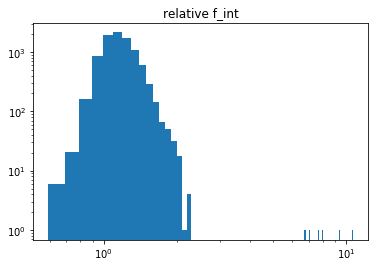

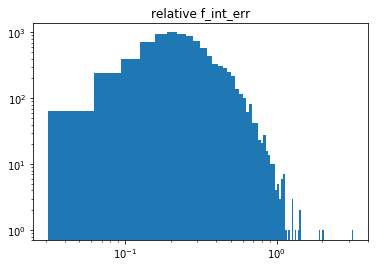

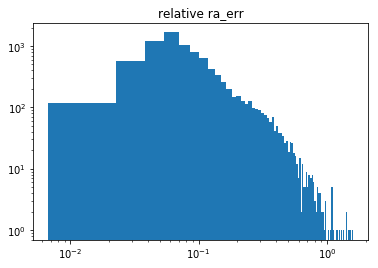

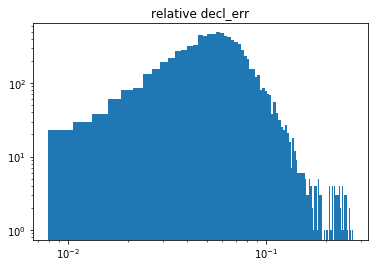

In [8]:
plt.figure()
plt.title("relative f_int")
_x = plt.hist(survey_out.rel_f_int, bins = 100, log=True)
plt.xscale("log")

plt.figure()
plt.title("relative f_int_err")
_x = plt.hist(survey_out.rel_f_int_err, bins = 100, log=True)
plt.xscale("log")


plt.figure()
plt.title("relative ra_err")
_x = plt.hist(survey_out.ra_err, bins = 100, log=True)
plt.xscale("log")

plt.figure()
plt.title("relative decl_err")
_x = plt.hist(survey_out.decl_err, bins = 100, log=True)
plt.xscale("log")

In [191]:
for ra, decl in zip(aart["ra"],aart["decl"])[10:20]:
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=DB)

    db.connect()
    session = db.Session()

    source_search = """
        SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
            runningcatalog.wm_ra >= {} AND 
            runningcatalog.wm_ra <= {} AND 
            runningcatalog.wm_decl >= {} AND 
            runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

    search_result = pd.DataFrame(run_query(source_search, DB, dataset, 
                              engine, host, port, user, password))
    db._configured = False
    del db, session
    
    try:
        runcat = int(search_result.sort_values("datapoints").iloc[0].id)
    except KeyError:
        break
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=DB)
    
    db.connect()
    session = db.Session()

    transients_query = """
        (SELECT   im.taustart_ts
                FROM extractedsource ex, image im
                WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                AND ex.image = im.id ORDER BY im.taustart_ts ASC LIMIT 10) UNION ALL (SELECT   im.taustart_ts
                FROM extractedsource ex, image im
                WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                AND ex.image = im.id ORDER BY im.taustart_ts DESC LIMIT 10);""".format(runcat,runcat )


    times = pd.DataFrame(run_query(transients_query, DB, dataset, 
                              engine, host, port, user, password))
    db._configured = False
    del db, session
    
    starttime = times[:10]
    endtime = times[10:]
    

 
    

KeyboardInterrupt: 

In [374]:

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

dataset = 1
DB = "ASf_20181104"

aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


# pd.DataFrame({"db":[],"id":[], 
#               "ra":[], "decl":[], "taustart_ts":[]}).to_csv("/home/kuiack/aart0_positions.csv", index=False)


# for DB in survey_out["db"]:
#     print DB
count = 0 

for ra, decl in zip(aart["ra"], aart["decl"]):
    
    pd.DataFrame({"db":[],"id":[], 
                  "ra":[], "decl":[], 
                  "taustart_ts":[]})\
    .to_csv("/home/kuiack/aart-{}-positions.csv".format(count), index=False)
    
    print count, "/", len(aart["ra"])
    
    for DB in AS_databases:
#         print DB
    # for ra, decl in zip(aart["ra"], aart["decl"]):

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=DB)

        db.connect()
        session = db.Session()

        source_search = """
            SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
                runningcatalog.wm_ra >= {} AND 
                runningcatalog.wm_ra <= {} AND 
                runningcatalog.wm_decl >= {} AND 
                runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

        search_result = pd.DataFrame(run_query(source_search, DB, dataset, 
                                  engine, host, port, user, password))
        db._configured = False
        del db, session

        try:
            runcat = int(search_result.sort_values("datapoints").iloc[0].id)
        except KeyError:
            continue 

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=DB)

        db.connect()
        session = db.Session()

        transients_query = """
            SELECT   im.taustart_ts, ex.ra, ex,decl
                    FROM extractedsource ex, image im
                    WHERE ex.id IN (select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                    AND ex.image = im.id 
                    AND ex.extract_type = 0 
                    AND im.band = 24 ;""".format(runcat)


        output = pd.DataFrame(run_query(transients_query, DB, dataset, 
                                  engine, host, port, user, password))[::60]
        db._configured = False
        del db, session
        
        if len(output) < 10:
            continue 


        pd.DataFrame({"db":[DB]*len(output),
                      "id":[count]*len(output), 
                      "ra":output.ra,
                      "decl":output.decl, 
                     "taustart_ts":[x.strftime("%Y-%m-%d %H:%M:%S") for x in output.taustart_ts]})\
        .to_csv("/home/kuiack/aart-{}-positions.csv".format(count), mode="a", header=False, index=False)
    
    count += 1
    

0 / 167
1 / 167
2 / 167
3 / 167
4 / 167
5 / 167
6 / 167
7 / 167
8 / 167
9 / 167
10 / 167
11 / 167
12 / 167
13 / 167
14 / 167
15 / 167
16 / 167
17 / 167
18 / 167
19 / 167
20 / 167
21 / 167
22 / 167
23 / 167
24 / 167
25 / 167
26 / 167
27 / 167
28 / 167
29 / 167
30 / 167
31 / 167
32 / 167
33 / 167
34 / 167
35 / 167
36 / 167
37 / 167
38 / 167
39 / 167
40 / 167
41 / 167
42 / 167
43 / 167
44 / 167
45 / 167
46 / 167
47 / 167
48 / 167
49 / 167
50 / 167
51 / 167
52 / 167
53 / 167
54 / 167
55 / 167
56 / 167
57 / 167
58 / 167
59 / 167
60 / 167
61 / 167
62 / 167
63 / 167
64 / 167
65 / 167
66 / 167
67 / 167
68 / 167
69 / 167
70 / 167
71 / 167
72 / 167
73 / 167
74 / 167
75 / 167
76 / 167
77 / 167
78 / 167
79 / 167
80 / 167
81 / 167
82 / 167
83 / 167
84 / 167
85 / 167
86 / 167
87 / 167
88 / 167
89 / 167
90 / 167
91 / 167
92 / 167
93 / 167
94 / 167
95 / 167
96 / 167
97 / 167
98 / 167
99 / 167
100 / 167
101 / 167
102 / 167
103 / 167
104 / 167
105 / 167
106 / 167
107 / 167
108 / 167
109 / 167
110 / 167


In [159]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


dataset = 1 
# start_times = [] 
# end_times  = []

pd.DataFrame({"db":[],"id":[], "starttime":[],"endtime":[]}).to_csv("/home/kuiack/positions.csv", index=False)

for DB in AS_databases:
    print DB
    for ra, decl in zip(aart["ra"], aart["decl"])[10:20]:

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=DB)

        db.connect()
        session = db.Session()

        source_search = """
            SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
                runningcatalog.wm_ra >= {} AND 
                runningcatalog.wm_ra <= {} AND 
                runningcatalog.wm_decl >= {} AND 
                runningcatalog.wm_decl <= {} ;""".format(ra-1.0, ra+1.0, decl-1.0, decl+1.0)

        search_result = pd.DataFrame(run_query(source_search, DB, dataset, 
                                  engine, host, port, user, password))
        db._configured = False
        del db, session

        try:
            runcat = int(search_result.sort_values("datapoints").iloc[0].id)
        except KeyError:
            break

        db = tkp.db.Database(engine=engine, host=host, port=port,
                             user=user, password=password, database=DB)

        db.connect()
        session = db.Session()

        transients_query = """
            (SELECT   im.taustart_ts
                    FROM extractedsource ex, image im
                    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                    AND ex.image = im.id ORDER BY im.taustart_ts ASC LIMIT 10) 
                        UNION ALL (SELECT   im.taustart_ts
                    FROM extractedsource ex, image im
                    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  {})
                    AND ex.image = im.id ORDER BY im.taustart_ts DESC LIMIT 10);""".format(runcat,runcat )


        times = pd.DataFrame(run_query(transients_query, DB, dataset, 
                                  engine, host, port, user, password))
        db._configured = False
        del db, session

        starttime = times[:10]
        endtime = times[10:]
        
        pd.DataFrame({"db":[DB],
                      "id":[runcat], 
                      "starttime":[pd.to_datetime(starttime.astype(np.int64).median())[0]
                                   .strftime("%Y-%m-%d %H:%M:%S")],
                      "endtime":[pd.to_datetime(endtime.astype(np.int64).median())[0]
                                 .strftime("%Y-%m-%d %H:%M:%S")]})\
        .to_csv("/home/kuiack/positions.csv", mode="a", header=False, index=False)
        
        

ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103
ASf_20181103

IndexError: index out of bounds

In [156]:
np.arange(0,20)[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [427]:
survey_out = pd.read_csv("/data/survey/complete_survey_catalogue_results.csv")

<IPython.core.display.Javascript object>


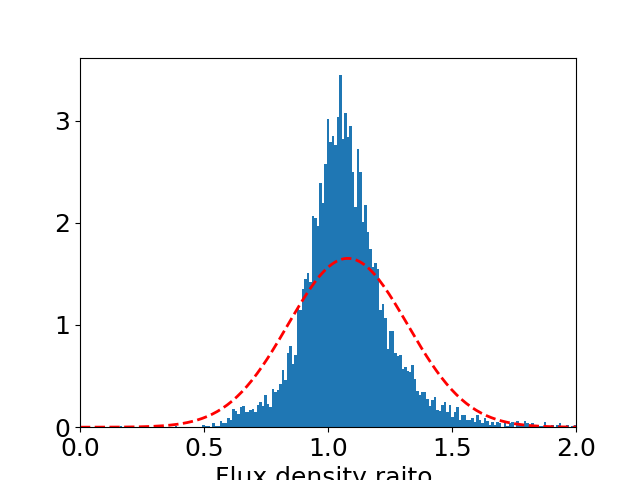

1.07977884801 0.241507697904


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


(1.0797788480098924, 1.061891486239481, 0.24150769790389881)

In [453]:
(mu, sigma) = norm.fit(survey_out.rel_f_int)


plt.figure()
_x = plt.hist(survey_out[survey_out.rel_f_int < 100.].rel_f_int, bins=np.linspace(0,2,200), normed=True)
y = mlab.normpdf( _x[1], mu, sigma)

l = plt.plot(_x[1],y,'r--', linewidth=2)
plt.xlabel("Flux density raito ")
plt.xlim([0,2])
plt.show()

print mu, sigma
np.mean(survey_out.rel_f_int), np.median(survey_out.rel_f_int), np.std(survey_out.rel_f_int)

In [166]:
aart

N       Name   decl  decl_err   f_int  f_int_err     loc  loc_err  \
0     8194  J1147+496  49.65      0.06   36.86       0.15   31.98     0.12   
1    34840  J0321+416  41.69      0.08  306.40       0.12  295.88     0.19   
2    41894  J0329+553  55.38      0.08   84.62       0.07   78.45     0.11   
3    10737  J0302+508  50.87      0.07   50.00       0.09   45.79     0.15   
4    48715  J0220+625  62.54      0.12  158.57       0.18  142.35     0.16   
5    36406  J0224+430  43.06      0.10   96.47       0.10   88.40     0.09   
6    41604  J0839+651  65.17      0.08   41.06       0.04   37.68     0.08   
7    19722  J0428+769  76.94      0.16   46.53       0.12   41.60     0.07   
8    22018  J0855+139  13.90      0.08   64.32       0.13   56.72     0.17   
9    26647  J0707+633  63.32      0.07   39.24       0.05   35.81     0.09   
10   15903  J0646+213  21.35      0.08   61.08       0.12   55.26     0.17   
11   55924  J0657+542  54.23      0.09   56.75       0.06   51.24     0.11   
12   73615  J1035+581  58.19      0.10   58.04       0.09   50.83     0.24   
13   49055  J1146+315  31.54      0.09   60.55       0.11   52.09     0.16   
14   74465  J0712+748  74.83      0.10   53.18       0.06   47.56     0.10   
15   34053  J1259+278  27.82      0.08   58.63       0.06   59.12     1.54   
16   33194  J0438+297  29.75      0.07  462.85       0.33  438.11     0.49   
17   61784  J1115+405  40.58      0.09   61.78       0.15   50.50     0.09   
18   39290  J1146+195  19.59      0.09   80.30       0.13   69.63     0.15   
19   49824  J0841+578  57.89      0.11   43.48       0.07   37.62     0.10   
20   57674  J0750+558  55.84      0.07   54.34       0.05   50.14     0.13   
21   64167  J0952+731  73.18      0.10   49.90       0.04   47.81     0.41   
22    7804  J1836+326  32.69      0.08   56.65       0.22   50.16     0.15   
23   40369  J1533+239  23.96      0.08   57.89       0.13   49.36     0.10   
24   55956  J0912+377  37.79      0.09   63.12       0.12   54.60     0.08   
25   57615  J1506+259  25.97      0.07  127.36       0.13  112.69     0.11   
26    8597  J1630+442  44.30      0.10   48.80       0.19   42.93     0.18   
27   27047  J0224+401  40.15      0.07   55.38       0.08   49.47     0.06   
28   15365  J0731+246  24.61      0.07   41.16       0.08   37.80     0.12   
29   46342  J2022+403  40.37      0.07  671.39       0.29  644.72     0.43   
..     ...        ...    ...       ...     ...        ...     ...      ...   
137  18542  J0240+593  59.37      0.06   56.82       0.08   52.41     0.09   
138  20126  J0311+171  17.19      0.06   68.23       0.10   62.32     0.16   
139   7650  J0258+062   6.23      0.06   80.23       0.21   74.50     0.59   
140  56715  J2118+608  60.88      0.08   96.04       0.07   89.62     0.13   
141  18931  J1236+212  21.23      0.08   46.24       0.10   40.99     0.11   
142   8780  J1523+076   7.66      0.08   71.86       0.13   66.71     0.23   
143  31019  J1407+341  34.13      0.07   48.77       0.14   41.17     0.15   
144  45160  J1351+643  64.36      0.09   47.26       0.07   42.09     0.15   
145  62202  J1830+487  48.74      0.08  136.75       0.09  127.96     0.19   
146  31047  J1518+070   7.01      0.06  114.72       0.12  117.79     2.38   
147  42515  J1525+543  54.38      0.08   46.64       0.04   47.26     1.18   
148  17491  J2021+297  29.73      0.06  103.62       0.14   97.94     0.43   
149  49609  J1013+463  46.34      0.09   46.28       0.08   39.62     0.07   
150   7457  J0802+614  61.48      0.08   42.35       0.10   38.93     0.14   
151  29749  J1007+347  34.78      0.09   39.54       0.11   34.27     0.06   
152   5008  J1151+127  12.74      0.09   49.69       0.15   44.88     0.19   
153   4537  J1217+534  53.46      0.05   34.14       0.12   31.09     0.13   
154  24996  J1844+455  45.56      0.06   54.96       0.07   49.80     0.07   
155  11854  J1210+436  43.62      0.06   33.98       0.10   30.00     0.09   
156  11552  J1312+273  27.40   

(0, 3)

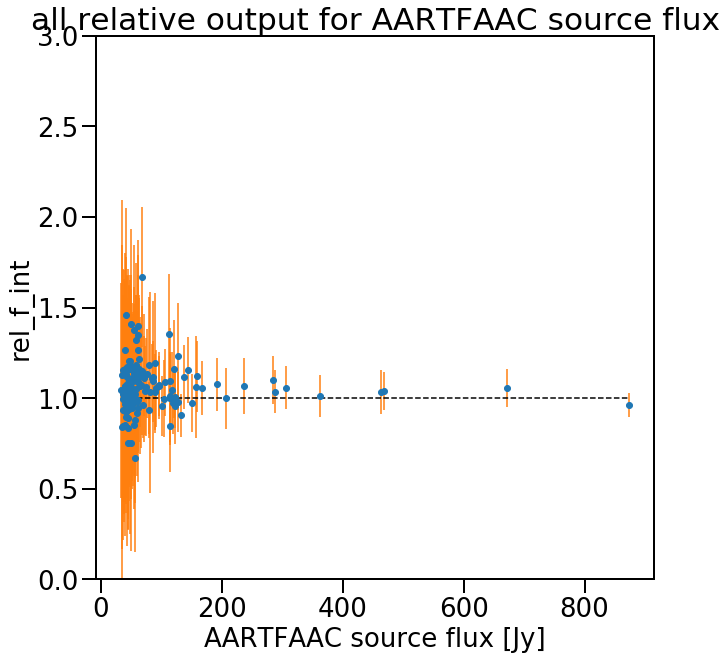

In [76]:
plt.figure(figsize=(10,10))
plt.title("all relative output for AARTFAAC source flux")
# plt.plot(aart.iloc[survey_out.groupby("id").mean().index].f_int, 
#          survey_out.groupby("id").mean().rel_f_int, ".")

plt.errorbar(aart.iloc[survey_out.groupby("id").mean().index].f_int,
             survey_out.groupby("id").mean().rel_f_int, 
             yerr=survey_out.groupby("id").mean().rel_f_int_err, ecolor="C1", fmt="o")

plt.plot([np.min(aart.f_int),np.max(aart.f_int)], [1,1], "--", c="k" )
plt.xlabel("AARTFAAC source flux [Jy]")
plt.ylabel("rel_f_int")
plt.ylim([0,3])

(0, 3)

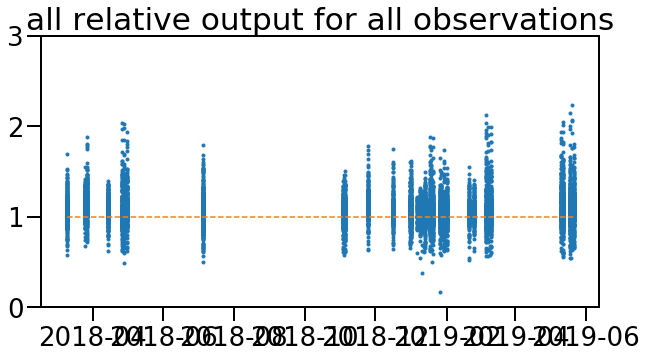

In [77]:
survey_out["dates"] = pd.to_datetime([x.split("_")[1] for x in survey_out.db])

plt.figure(figsize=(10,5))
plt.title("all relative output for all observations")
plt.plot(survey_out.dates, survey_out.rel_f_int, ".")
plt.plot([np.min(survey_out.dates),np.max(survey_out.dates)], [1,1], "--", c="C1" )
plt.ylim([0,3])


In [15]:
np.unique(survey_out["dates"])

array(['2018-03-09T15:15:00.000000000+0000',
       '2018-03-25T18:30:00.000000000+0000',
       '2018-03-26T18:42:00.000000000+0000',
       '2018-04-14T17:30:00.000000000+0000',
       '2018-04-26T12:45:00.000000000+0000',
       '2018-04-28T10:40:00.000000000+0000',
       '2018-04-30T15:10:00.000000000+0000',
       '2018-07-05T10:14:00.000000000+0000',
       '2018-07-05T18:11:00.000000000+0000',
       '2018-11-03T00:00:00.000000000+0000',
       '2018-11-04T00:00:00.000000000+0000',
       '2018-11-05T00:00:00.000000000+0000',
       '2018-11-25T02:17:00.000000000+0000',
       '2018-12-16T02:30:00.000000000+0000',
       '2018-12-31T00:00:00.000000000+0000',
       '2019-01-01T00:00:00.000000000+0000',
       '2019-01-06T00:00:00.000000000+0000',
       '2019-01-09T00:00:00.000000000+0000',
       '2019-01-10T00:00:00.000000000+0000',
       '2019-01-12T00:00:00.000000000+0000',
       '2019-01-13T00:00:00.000000000+0000',
       '2019-01-17T00:00:00.000000000+0000',
       '20

In [16]:
print np.mean(survey_out.ra_err), np.std(survey_out.ra_err)
print np.mean(survey_out.decl_err), np.std(survey_out.decl_err)

0.103387966229 0.121299582989
0.0454460379594 0.0269080215617


In [9]:
survey_out

db       decl  id          ra          taustart_ts
0        ASf_20181104  49.389406   0  175.863674  2018-11-04 06:49:42
1        ASf_20181104  49.469721   0  176.476745  2018-11-04 06:49:43
2        ASf_20181104  49.526077   0  176.728062  2018-11-04 06:49:43
3        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:44
4        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:44
5        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:45
6        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:45
7        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:46
8        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:46
9        ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:47
10       ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:47
11       ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:48
12       ASf_20181104  49.456021   0  176.323796  2018-11-04 06:49:48
13       ASf_20181104  49.512901   0  176.625050  2018-11-04 06:49:57
14       ASf_20181104  49.469423   0  176.394775  2018-11-04 06:49:57
15       ASf_20181104  49.432604   0  176.463262  2018-11-04 06:49:58
16       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:49:58
17       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:49:59
18       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:49:59
19       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:50:00
20       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:50:00
21       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:50:01
22       ASf_20181104  49.462603   0  176.407461  2018-11-04 06:50:01
23       ASf_20181104  49.453774   0  176.277621  2018-11-04 06:50:02
24       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:02
25       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:03
26       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:03
27       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:04
28       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:04
29       ASf_20181104  49.461120   0  176.385658  2018-11-04 06:50:05
...               ...        ...  ..         ...                  ...
1563597  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:20
1563598  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:20
1563599  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:21
1563600  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:21
1563601  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:22
1563602  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:22
1563603  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:23
1563604  ASf_20181104  82.354917   0  246.931660  2018-11-04 15:39:23
1563605  ASf_20181104  82.382007   0  247.207959  2018-11-04 15:40:19
1563606  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:20
1563607  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:20
1563608  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:21
1563609  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:21
1563610  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:22
1563611  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:22
1563612  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:23
1563613  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:23
1563614  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:24
1563615  ASf_20181104  82.354994   0  246.932446  2018-11-04 15:40:24
1563616  ASf_20181104  82.261041   0  247.002683  2018-11-04 15:43:26
1563617  ASf_20181104  82.354713   0  246.932656  2018-11-04 15:43:27
1563618  ASf_20181104  82.354713   0  246.932656  2018-11-04 15:43:27
1563619  ASf_20181104  82.354713   0  246.932656  2018-11-04 15:43:28
1563620  ASf_20181104  82.354713   0  246.932656  2018-11-04 15:43:28
1563621  ASf_20181104  82.354713   0  246.932656  2018-11-04 15:43:29
1563622  ASf_20181104  82.354

In [15]:
# _ID = 1

# All catalogue sources position and flux across the survey 
for _ID in aart.index:
    plt.figure(figsize=(10,5))
    plt.suptitle(_ID)
    plt.subplot(121)
    plt.plot(survey_out[survey_out.id == _ID].ra, 
             survey_out[survey_out.id == _ID].decl, ".") 

    plt.subplot(122)
    plt.plot(survey_out[survey_out.id == _ID].dates, 
             survey_out[survey_out.id == _ID].rel_f_int.values*aart[aart.index == _ID].f_int.values, ".") 
    plt.xticks(rotation=60)

NameError: name 'aart' is not defined

In [10]:
vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", delimiter="\t",comment="#")
vlssr = vlssr[(vlssr.Sp > 20)]



In [ ]:
survey_out = pd.read_csv("/home/kuiack/positions.csv")



In [1]:

%matplotlib notebook

# plt.figure(figsize=(10,8))


# source position tracks, position dither due to ionosphere
for _ID in aart.index:

    _index  = (pd.to_datetime(survey_out.taustart_ts).diff(periods= -1).astype('timedelta64[s]') < 10) & (survey_out.id == _ID)

    vlsr_index = (vlssr._RAJ2000 > survey_out[_index].ra.median() - 2 ) &\
        (vlssr._RAJ2000 < survey_out[_index].ra.median() + 2 ) &\
        (vlssr._DEJ2000 > survey_out[_index].decl.median() - 2 ) &\
        (vlssr._DEJ2000 < survey_out[_index].decl.median() + 2 )
    
    
    if np.sum(_index) < 10 or np.sum(vlsr_index) < 1 :
       
        continue

    plt.figure(_ID, figsize=(6,6))
    
    plt.scatter(survey_out[_index].ra.rolling(60).mean(),
                survey_out[_index].decl.rolling(60).mean(),
                c=pd.to_datetime(survey_out[_index].taustart_ts).astype(np.int64).rolling(60).mean())


    
    plt.scatter(vlssr[vlsr_index]._RAJ2000, 
                    vlssr[vlsr_index]._DEJ2000, marker="+")

    plt.tight_layout()
    plt.show()




#     plt.subplot(122)
#     plt.plot(survey_out[survey_out.id == _ID].dates, 
#              survey_out[survey_out.id == _ID].rel_f_int.values*aart[aart.index == _ID].f_int.values, ".") 
#     plt.xticks(rotation=60)

NameError: name 'aart' is not defined

In [2]:

%matplotlib notebook

# plt.figure(figsize=(10,8))

survey_out = pd.read_csv("/home/kuiack/aart0_positions.csv")

_ID = 0
count = 0

for _DB in np.unique(survey_out.db):

    _index  = (pd.to_datetime(survey_out.taustart_ts).diff(periods= -1).astype('timedelta64[s]') < 10) \
    & (survey_out.db == _DB)

    vlsr_index = (vlssr._RAJ2000 > survey_out[_index].ra.median() - 2 ) &\
        (vlssr._RAJ2000 < survey_out[_index].ra.median() + 2 ) &\
        (vlssr._DEJ2000 > survey_out[_index].decl.median() - 2 ) &\
        (vlssr._DEJ2000 < survey_out[_index].decl.median() + 2 )
    
    
    if np.sum(_index) < 10 or np.sum(vlsr_index) < 1 :
        count += 1
        continue

    plt.figure(count, figsize=(6,6))
    count +=1
    
    plt.title(_DB)
    plt.scatter(survey_out[_index].ra.rolling(60).mean(),
                survey_out[_index].decl.rolling(60).mean(),
                c=pd.to_datetime(survey_out[_index].taustart_ts).astype(np.int64).rolling(60).mean())


    
    plt.scatter(vlssr[vlsr_index]._RAJ2000, 
                    vlssr[vlsr_index]._DEJ2000, marker="+")

    plt.tight_layout()
    plt.show()



NameError: name 'pd' is not defined

<IPython.core.display.Javascript object>


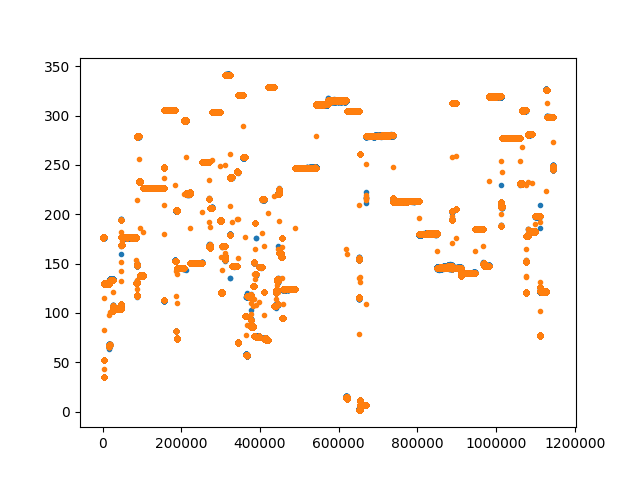

In [295]:
plt.figure()
plt.plot(survey_out.ra, ".")
plt.plot(survey_out.ra.rolling(10).median(), ".")

### Source position analysis across the survey. 

Measuring the difference between the VLSSr position and the AARTFAAC fit positions 

In [14]:

survey_out = pd.read_csv("/home/kuiack/ASf_20181104_positions.csv")
# survey_out = pd.read_csv("/home/kuiack/aart0_positions.csv")


vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", 
                    delimiter="\t", comment="#")

vlssr = vlssr[(vlssr.Sp > 20)]
print len(aart), len(vlssr[(vlssr.Sp > 20)])

# calculate a histogram of the area/sensitivity for timesteps from the TraP database
CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')

skip = 2000
roll = 120

position = SkyCoord(survey_out.ra.rolling(roll).median().values[::skip]*u.degree,
                    survey_out.decl.rolling(roll).median().values[::skip]*u.degree)

vlssr_coord = SkyCoord(vlssr._RAJ2000.values*u.degree,
                       vlssr._DEJ2000.values*u.degree)

print len(position), len(vlssr_coord)


IOError: File /home/kuiack/ASf_20181104_positions.csv does not exist

<IPython.core.display.Javascript object>


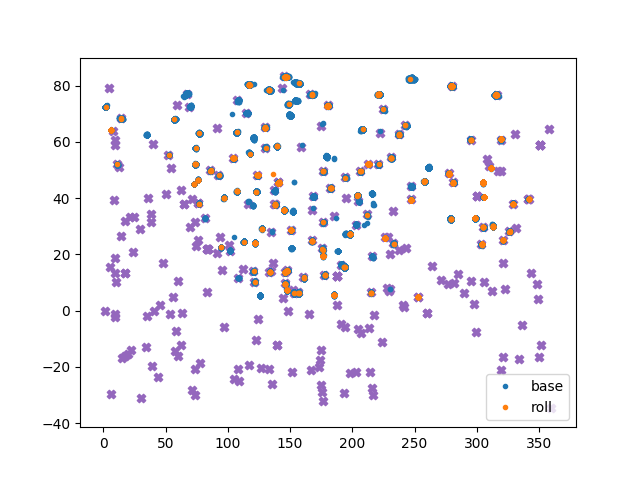

In [298]:
plt.figure()

plt.plot(survey_out.ra,survey_out.decl, ".", c="C0", label="base")
plt.plot(survey_out.ra.rolling(roll).median().values[::skip],
         survey_out.decl.rolling(roll).median().values[::skip], ".", c="C1", label="roll")

# plt.plot(survey_out.ra.values[::skip],survey_out.decl.values[::skip], ".", c="C2", label="skip")


plt.scatter(vlssr._RAJ2000.values, 
            vlssr._DEJ2000.values, marker="X", c="C4")
plt.legend()

In [336]:
# catalogue matching 
idxc, idxcatalog, d2d, d3d = position.search_around_sky(vlssr_coord, 1*u.deg)
AART_pos =  position[idxcatalog]
vlssr_pos = vlssr_coord[idxc]

# idxc, idxcatalog, d2d, d3d = vlssr_coord.search_around_sky(position, 1*u.deg)
# AART_pos =  position[idxc]
# vlssr_pos = vlssr_coord[idxcatalog]





obstime = survey_out.taustart_ts.rolling(roll).median().values[::skip][idxcatalog]

In [337]:
len(AART_pos), len(vlssr_pos), len(obstime)

(454, 454, 454)

<IPython.core.display.Javascript object>


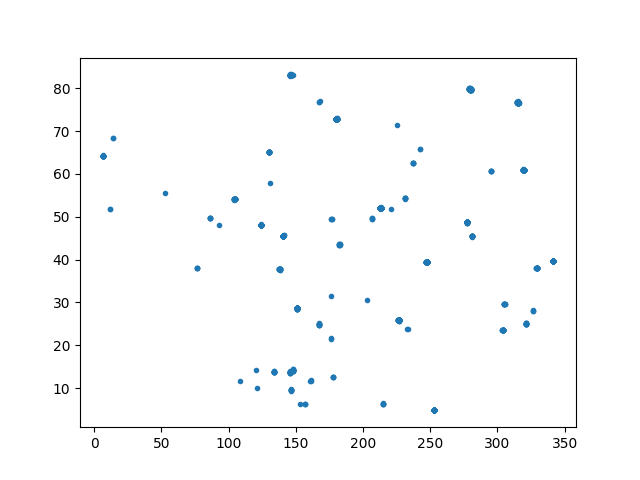

In [308]:
plt.figure()
plt.plot(AART_pos.ra.deg, 
         AART_pos.dec.deg, ".")

In [338]:
%%time

aart_altaz = [AART_pos[i].transform_to(AltAz(obstime=obstime[i], location=CS002)) \
            for i in range(len(obstime))]

vlssr_altaz = [vlssr_pos[i].transform_to(AltAz(obstime=obstime[i], location=CS002)) \
            for i in range(len(obstime))]

CPU times: user 46.6 s, sys: 328 ms, total: 46.9 s
Wall time: 46.8 s


In [339]:
sr_y, sr_x = pol2cart(np.abs(90 - np.array([pos.alt.deg for pos in aart_altaz ])),
                      [pos.az.rad for pos in aart_altaz ])

vlssr_sr_y, vlssr_sr_x = pol2cart(np.abs(90 - np.array([pos.alt.deg for pos in vlssr_altaz])),
                      [pos.az.rad for pos in vlssr_altaz])


<IPython.core.display.Javascript object>


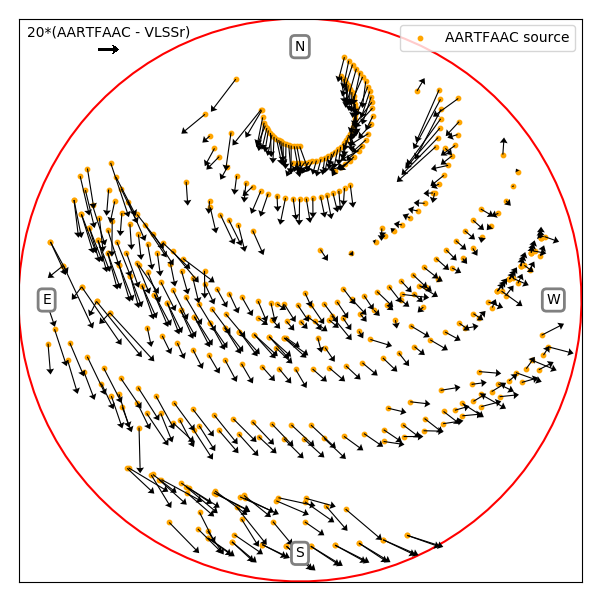

In [355]:
%matplotlib notebook

plt.figure(figsize=(6,6))

plt.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r",zorder=0)


plt.scatter(sr_x, sr_y,  s=10, c="orange", label="AARTFAAC source" )

#             c=pd.to_datetime(obstime), label="AARTFAAC source" )

Q = plt.quiver(sr_x, sr_y,
           sr_x-vlssr_sr_x.ravel(), sr_y-vlssr_sr_y.ravel(), headwidth=7,
               angles='xy', scale_units='xy', scale=0.05, width=0.002)

plt.quiverkey(Q,  0.16 , 0.945, 1, label="20*(AARTFAAC - VLSSr)")




bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)

plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    
    

# plt.colorbar()
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.savefig("/home/kuiack/mag_figs/scintel_mag_v_vlssr.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.savefig("/home/kuiack/surveyfigs/position_offset.pdf", bbox_inches = 'tight' )



In [78]:
survey_out[survey_out.id == _ID]

db   id  freq_band  rel_f_int  rel_f_int_err          ra  \
0         ASf_20181103    6       61.8   0.645682       0.512911  129.978494   
1         ASf_20181103    6       58.3   0.963414       0.292584  129.967885   
2         ASf_20181103    7       61.8   1.317933       0.426260   67.594842   
3         ASf_20181103    7       58.3   1.297004       0.348513   67.494632   
4         ASf_20181103   11       61.8   1.015319       0.166376  104.546665   
5         ASf_20181103   11       58.3   1.002061       0.153208  104.565623   
6         ASf_20181103   12       61.8   1.099352       0.447157  158.784998   
7         ASf_20181103   12       58.3   1.159074       0.389650  158.793984   
8         ASf_20181103   13       61.8   1.337801       0.602084  176.647989   
9         ASf_20181103   13       58.3   1.246717       0.344442  176.655904   
10        ASf_20181103   14       61.8   0.934896       0.443674  108.381568   
11        ASf_20181103   14       58.3   0.954757       0.241491  108.385532   
12        ASf_20181103   15       61.8   1.008299       0.407097  194.865073   
13        ASf_20181103   15       58.3   1.070207       0.212304  194.851188   
14        ASf_20181103   17       61.8   1.193177       0.369847  168.851050   
15        ASf_20181103   17       58.3   1.261332       0.229048  168.864024   
16        ASf_20181103   18       61.8   1.161091       0.273101  176.501282   
17        ASf_20181103   18       58.3   1.102391       0.157449  176.484199   
18        ASf_20181103   19       61.8   0.948037       0.352084  130.343065   
19        ASf_20181103   19       58.3   1.003941       0.270794  130.355051   
20        ASf_20181103   20       61.8   1.018136       0.364434  117.774194   
21        ASf_20181103   20       58.3   1.017123       0.163125  117.771166   
22        ASf_20181103   21       61.8   1.007391       0.373882  148.116114   
23        ASf_20181103   21       58.3   1.121387       0.363422  148.123171   
24        ASf_20181103   22       61.8   0.609675       0.522529  278.990889   
25        ASf_20181103   22       58.3   1.202185       0.305202  279.005794   
26        ASf_20181103   23       61.8   1.251609       0.432927  233.139128   
27        ASf_20181103   23       58.3   1.296405       0.380761  233.134513   
28        ASf_20181103   24       61.8   1.017749       0.236669  138.023811   
29        ASf_20181103   24       58.3   1.105459       0.226532  138.024856   
...                ...  ...        ...        ...            ...         ...   
8161  ASf_201905180305  111       58.3   1.125224       0.422063   29.515403   
8162  ASf_201905180305  112       61.8   1.320855       0.226978   11.014048   
8163  ASf_201905180305  112       58.3   1.246105       0.226617   11.024647   
8164  ASf_201905180305  113       61.8   1.173197       0.886857   24.687724   
8165  ASf_201905180305  113       58.3   0.935492       0.807287   24.680944   
8166  ASf_201905180305  114       61.8   1.144414       0.157458    6.635004   
8167  ASf_201905180305  114       58.3   1.090673       0.092107    6.636388   
8168  ASf_201905180305  115       61.8   1.246068       0.316341   17.399477   
8169  ASf_201905180305  115       58.3   1.230311       0.338971   17.413444   
8170  ASf_201905180305  119       61.8   1.065911       0.157741  280.667551   
8171  ASf_201905180305  119       58.3   1.038038       0.153110  280.658866   
8172  ASf_201905180305  122       61.8   0.936947       0.176498  213.169289   
8173  ASf_201905180305  122       58.3   1.101755       0.156629  213.153190   
8174  ASf_201905180305  123       61.8   1.056074       0.134335   35.671112   
8175  ASf_201905180305  123       58.3   0.949831       0.171415   35.648394   
8176  ASf_201905180305  128       61.8   0.970005       0.150347  312.772528   
8177  ASf_201905180305  128       58.3   0.981657       0.138140  312.771556   
8178  ASf_201905180305  135       61.8   1.468686       0.519550   38.348648   
8179  ASf_2019051803

<IPython.core.display.Javascript object>


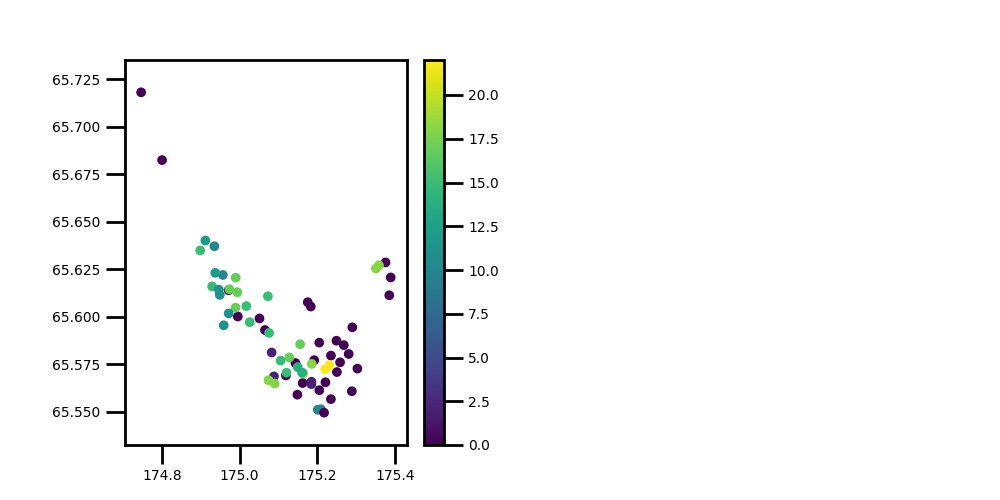

In [99]:

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(survey_out[survey_out.id == _ID].ra, 
         survey_out[survey_out.id == _ID].decl, 
            c=[x.hour for x in survey_out[survey_out.id == _ID].dates])
plt.colorbar()

# plt.subplot(122)
# plt.quiver(-sr_x, sr_y,
#            survey_out[survey_out.id == _ID].ra - np.mean(survey_out[survey_out.id == _ID].ra),
#            survey_out[survey_out.id == _ID].decl - np.mean(survey_out[survey_out.id == _ID].decl), 
#            width=0.005)

# plt.xlim([-70,70])
# plt.ylim([-70,70])



In [18]:
glob.glob("/data/kuiack/survey/aart*-positions.csv")

[]

In [19]:
skip = 10
roll = 1

#here 
survey_out = pd.DataFrame([])
for i in glob.glob("/data/kuiack/survey/positions/aart*-positions.csv"):
    survey_out = pd.concat([survey_out, 
                            pd.read_csv(i) ], ignore_index=True)

survey_out = survey_out[::skip]

vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", 
                    delimiter="\t", comment="#")

vlssr = vlssr[(vlssr.Sp > 30)]

# calculate a histogram of the area/sensitivity for timesteps from the TraP database
CS002 = EarthLocation.from_geocentric (3826577.1095, 461022.900196, 5064892.758, 'm')


position = SkyCoord(survey_out.ra.values*u.degree,
                    survey_out.decl.values*u.degree, unit=(u.deg, u.deg),
#                     obstime=[Time(i,scale='utc') for i in survey_out.taustart_ts],
                    location=CS002, frame="fk5")

vlssr_coord = SkyCoord(vlssr._RAJ2000.values*u.degree,
                       vlssr._DEJ2000.values*u.degree)

print len(position), len(vlssr_coord)


48325 129


In [20]:
# catalogue matching 
idxc, idxcatalog, d2d, d3d = position.search_around_sky(vlssr_coord, 1.*u.deg)
AART_pos =  position[idxcatalog]
vlssr_pos = vlssr_coord[idxc]

print len(idxcatalog), len(idxc)
# idxc, idxcatalog, d2d, d3d = vlssr_coord.search_around_sky(position, 1*u.deg)
# AART_pos =  position[idxc]
# vlssr_pos = vlssr_coord[idxcatalog]


obstime = survey_out.iloc[idxcatalog].taustart_ts


print len(AART_pos), len(vlssr_pos), len(obstime)

24341 24341
24341 24341 24341


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/units/quantity.py:1013: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__ne__(other)


0.249576811797 0.254940940792


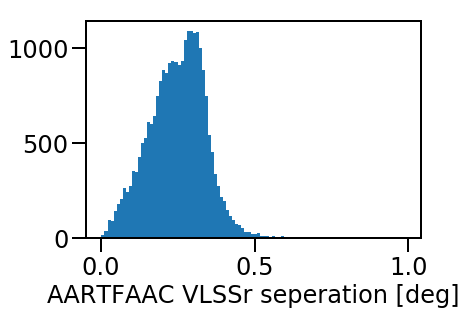

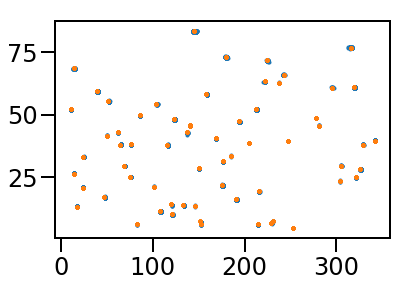

In [21]:
plt.figure()
plt.hist( d2d.deg, bins=100)
plt.xlabel("AARTFAAC VLSSr seperation [deg]")

print np.mean(d2d.deg), np.median(d2d.deg)

plt.figure()
plt.plot(AART_pos.ra.deg, 
         AART_pos.dec.deg, ".")

plt.plot(vlssr_pos.ra.deg, 
         vlssr_pos.dec.deg, ".")

In [22]:
%%time

aart_altaz = AART_pos.transform_to(AltAz(obstime=[Time(x, scale="utc", format="iso")\
                                                  for x in obstime ],
                                         location=CS002))

vlssr_altaz = vlssr_pos.transform_to(AltAz(obstime=[Time(x, scale="utc", format="iso")\
                                                    for x in obstime ],
                                           location=CS002))

CPU times: user 54.1 s, sys: 452 ms, total: 54.5 s
Wall time: 54.5 s


In [23]:
def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


sr_y, sr_x = pol2cart(np.abs(90.-np.array(aart_altaz.alt.deg)), aart_altaz.az.rad)
vlssr_sr_y, vlssr_sr_x = pol2cart(np.abs(90 - vlssr_altaz.alt.deg),vlssr_altaz.az.rad)


<IPython.core.display.Javascript object>


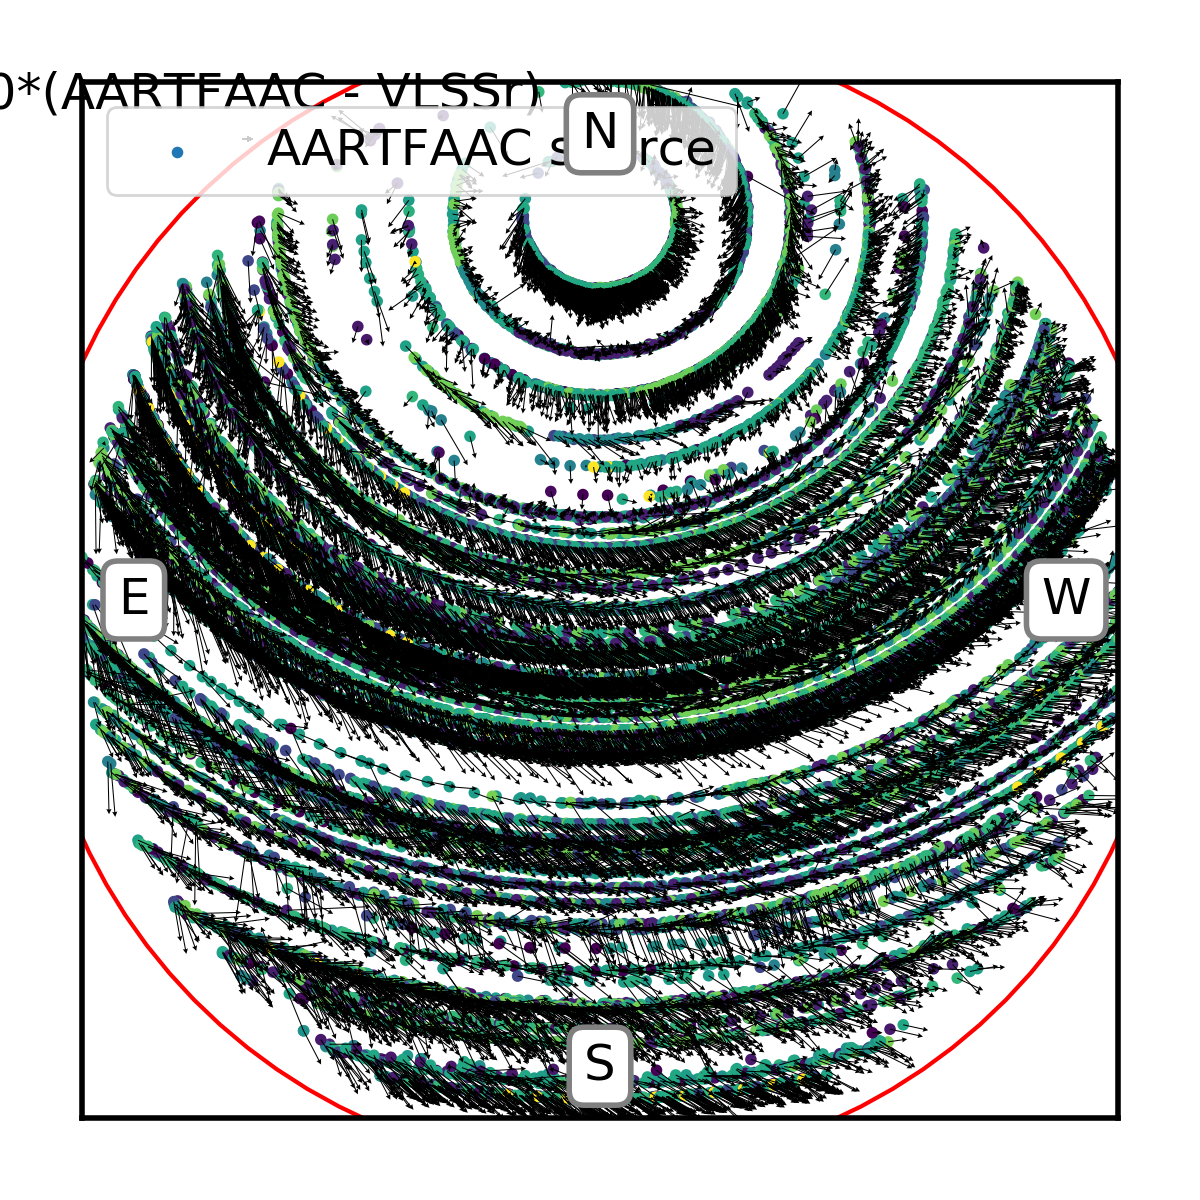

In [109]:
%matplotlib notebook

plt.figure(figsize=(6,6))

plt.plot(-pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((90-35*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r",zorder=0)


plt.scatter(sr_x, sr_y,  s=10, label="AARTFAAC source",
            c=pd.to_datetime(obstime))#,c="orange",  )

Q = plt.quiver(sr_x, sr_y,
           sr_x-vlssr_sr_x.ravel(), sr_y-vlssr_sr_y.ravel(), headwidth=5,
               angles='xy', scale_units='xy', scale=0.1, width=0.001)

plt.quiverkey(Q,  0.16 , 0.945, 1, label="20*(AARTFAAC - VLSSr)")




bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)

plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    


# plt.colorbar()
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.savefig("/home/kuiack/mag_figs/scintel_mag_v_vlssr.pdf", bbox_inches = 'tight', pad_inches = 0)

# plt.savefig("/home/kuiack/surveyfigs/position_offset_large.pdf", bbox_inches = 'tight' )



In [25]:

from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[-50:50:45j, -50:50:45j]

points = zip(sr_x, sr_y)

U_values = sr_x-vlssr_sr_x
V_values = sr_y-vlssr_sr_y

grid_zU = griddata(points, U_values, (grid_x, grid_y), method='linear')
grid_zV = griddata(points, V_values, (grid_x, grid_y), method='linear')

# from scipy.interpolate import griddata
# grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
# grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [78]:
TR_loc = SkyCoord(163.37,33.73,unit="deg",
                  frame='barycentrictrueecliptic').transform_to(AltAz(obstime="2017-02-25T03:21:00", location=CS002))
TR_loc_x = -pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[1]
TR_loc_y = pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[0]
# TR_loc_x, TR_loc_y = TR_loc_x[(np.sqrt(TR_loc_x**2. + TR_loc_y**2.) < 55)], TR_loc_y[(np.sqrt(TR_loc_x**2. + TR_loc_y**2.) < 55)]  


In [79]:
TR_U = griddata(points, U_values, (TR_loc_x, TR_loc_y), method='linear')
TR_V = griddata(points, V_values, (TR_loc_x, TR_loc_y), method='linear')


In [107]:
def locate_corrected(cor_pos):

    loc1 = SkyCoord(163.37,33.73,unit="deg",
                      frame='barycentrictrueecliptic').transform_to(AltAz(obstime="2017-02-25T03:21:00", location=CS002))
    loc1_x = -pol2cart((90-loc1.alt.deg), loc1.az.rad,)[1]
    loc1_y = pol2cart((90-loc1.alt.deg), loc1.az.rad,)[0]

    loc1_U = griddata(points, U_values, (loc1_x, loc1_y), method='linear')
    loc1_V = griddata(points, V_values, (loc1_x, loc1_y), method='linear')
    
#     print loc1_x+loc1_U, loc1_y+loc1_V


    TR_loc = SkyCoord(cor_pos[0], cor_pos[1],unit="deg",
                      frame='barycentrictrueecliptic').transform_to(AltAz(obstime="2017-02-25T03:21:00", location=CS002))
    TR_loc_x = -pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[1]
    TR_loc_y = pol2cart((90-TR_loc.alt.deg), TR_loc.az.rad,)[0]

    return np.sqrt((loc1_x+loc1_U - TR_loc_x)**2. + (loc1_y+loc1_V - TR_loc_y)**2.)

In [108]:
# from scipy.optimize import minimize
from scipy.optimize import fmin

# minimize(locate_corrected,x0=[162.87,32.73])
print fmin(locate_corrected,[162.87,32.73])

Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 35
         Function evaluations: 70
[ 163.24301041   33.43064895]


<IPython.core.display.Javascript object>


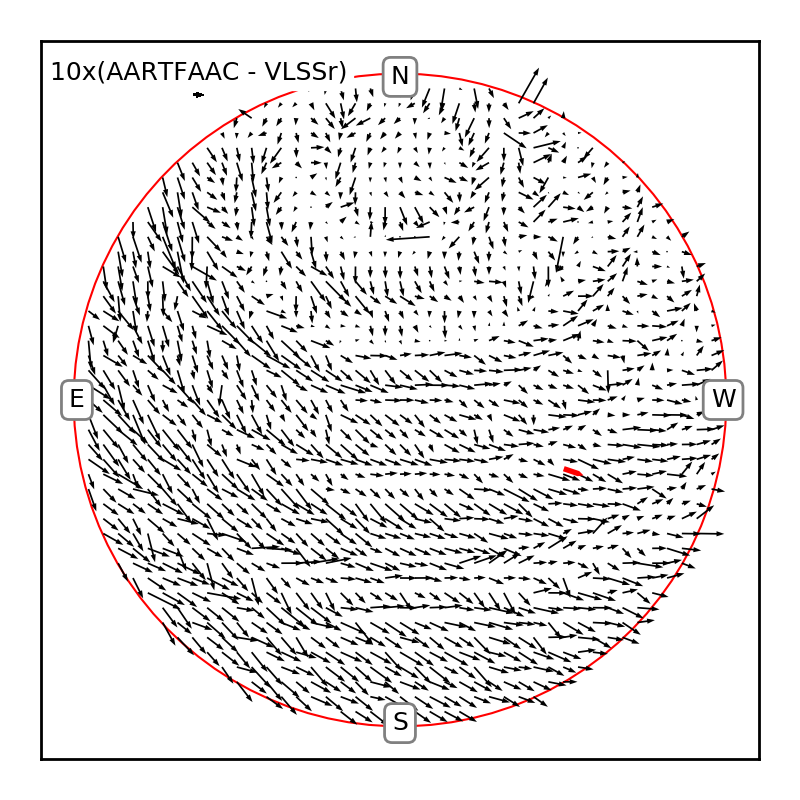

In [76]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,8))

plt.plot(-pol2cart((50*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[1],
        pol2cart((50*np.ones(100)), np.deg2rad(np.linspace(0,360,100)),)[0],"r",zorder=0)



# plt.scatter(TR_loc_x,TR_loc_y,marker="x",c="r",zorder=0)

# plt.scatter(sr_x, sr_y,  s=30, label="AARTFAAC source",
#             c="lightgrey",  )


_ind = [(np.sqrt(grid_x**2.+grid_y**2.) < 50)]

scale = 0.1
Q = plt.quiver(grid_x[_ind], grid_y[_ind], grid_zU[_ind], grid_zV[_ind], headwidth=3,headlength=4.5, #width=0.0015,
               angles='xy', scale_units='xy', scale=scale)
Qk = plt.quiverkey(Q,  0.22 , 0.925, 1, 
              label="{}x(AARTFAAC - VLSSr)".format(int(1./scale)))


Qtr = plt.quiver(TR_loc_x, TR_loc_y, TR_U, TR_V, headwidth=1,headlength=.,
               angles='xy', scale_units='xy', scale=scale, color="red")
# Qktr = plt.quiverkey(Qtr,  0.22 , 0.925, 1, 
#               label="{}xTransient".format(int(1./scale)))

Qk.text.set_backgroundcolor('w')

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2)

plt.annotate("S", (0.0,0.3), xytext=(0.5,0.05), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("N", (0.0,0.3), xytext=(0.5,0.95),  zorder=99,
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   

plt.annotate("W", (0.0,0.3), xytext=(0.95,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")   
plt.annotate("E", (0.0,0.3), xytext=(0.05,0.5), 
             xycoords='axes fraction',bbox=bbox_props, va="center", ha="center")    

plt.xlim([-55,55])
plt.ylim([-55,55])
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("/home/kuiack/surveyfigs/position_offset_interp.pdf", bbox_inches = 'tight' )


In [394]:
skip = 1
roll = 1

#here 
survey_out = pd.DataFrame([])
for i in glob.glob("/data/survey/aart*-positions.csv"):
    survey_out = pd.concat([survey_out, 
                            pd.read_csv(i) ], ignore_index=True)


survey_out = survey_out[::skip]


print len(position), len(vlssr_coord)


48325 129


In [395]:
_n = []
_ra_std = []
_dec_std = []
_dec = []
_ra = []

for _ID in np.unique(survey_out.id):
    _ra.append(survey_out[survey_out.id == _ID].ra.mean())
    _dec.append(survey_out[survey_out.id == _ID].decl.mean())
    _n.append(len(survey_out[survey_out.id == _ID]))
    _ra_std.append(survey_out[survey_out.id == _ID].ra.std()),
    _dec_std.append(survey_out[survey_out.id == _ID].decl.std())
    
    
    
    

<IPython.core.display.Javascript object>


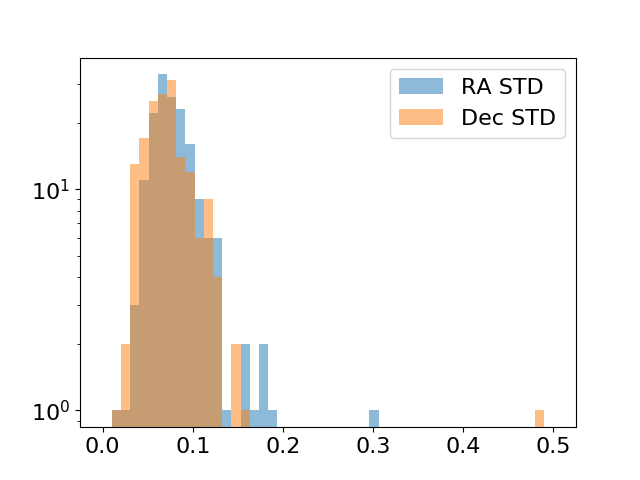

0.0751220996027
0.0704669621261


In [425]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16
       }
matplotlib.rc('font', **font)


plt.figure()
plt.hist(_ra_std*np.cos(np.deg2rad(_dec)), bins=np.linspace(0,0.5,50), log=True, alpha=0.5, label="RA STD")
print np.median(_ra_std*np.cos(np.deg2rad(_dec)))
plt.hist(_dec_std, bins=np.linspace(0,0.5,50), log=True, alpha=0.5, label="Dec STD")
print np.median(_dec_std)
plt.legend()

In [200]:
harvest = pd.read_csv("/data/survey/ASrerun2_survey_stats.csv")

In [202]:
harvest[50:70]

dbname  tot_time  tot_candidate  tot_filtered  \
50  ASr_201609070340     21528           7043           174   
51  ASr_201611120632     28727           2737            89   
52  ASr_201611132000     10668           2581            52   
53  ASr_201611140501     14327           1296            71   
54  ASr_201702241630      6529            187             6   
55  ASr_201702250130     13128          34397          3898   
56  ASr_201702250800     21527          23594           706   
57  ASr_201702251405     14928          20733           605   
58  ASr_201702260116     10728          11766           473   
59  ASr_201702260800     21527           7405           157   
60  ASr_201702261405     18528           3862           111   
61  ASr_201702270350      4428            235             2   
62  ASr_201702280900      3528            637             5   
63  ASr_201809212320      5868            162             4   
64  ASr_201809220111      9528           1458            35   
65  ASr_201809220609      8326           3694           196   
66  ASr_201809221701      9949           6299            91   
67  ASr_201809230412     17146          17503           974   
68  ASr_201809280900     24560          28513          1062   
69  ASr_201809281701      8028           1432            13   

                     starttime                     endtime  
50         2016-09-07 03:40:10         2016-09-07 09:38:57  
51  2016-11-12 06:32:11.557000  2016-11-12 14:30:57.843000  
52  2016-11-13 20:00:10.543000  2016-11-13 22:57:57.832000  
53  2016-11-14 05:01:10.562000  2016-11-14 08:59:56.962000  
54         2017-02-24 16:30:10         2017-02-24 18:18:58  
55         2017-02-25 01:30:10         2017-02-25 05:08:57  
56         2017-02-25 08:00:10         2017-02-25 13:58:56  
57         2017-02-25 14:05:10         2017-02-25 18:13:57  
58         2017-02-26 01:16:10         2017-02-26 04:14:57  
59         2017-02-26 08:00:10         2017-02-26 13:58:56  
60         2017-02-26 14:05:10         2017-02-26 19:13:57  
61         2017-02-27 03:50:10         2017-02-27 05:03:57  
62         2017-02-28 09:00:10         2017-02-28 09:58:57  
63         2018-09-21 23:20:10         2018-09-22 00:57:57  
64         2018-09-22 01:11:10         2018-09-22 03:49:57  
65         2018-09-22 06:09:11         2018-09-22 08:27:56  
66         2018-09-22 17:01:10         2018-09-22 19:46:58  
67         2018-09-23 04:12:11         2018-09-23 08:57:56  
68         2018-09-28 09:18:54         2018-09-28 16:08:13  
69         2018-09-28 17:01:10         2018-09-28 19:14:57

In [457]:
harvest.sum()

dbname           ASf_201803091515ASf_201803251830ASf_2018032618...
tot_time                                                   2354857
tot_candidate                                              2036591
tot_filtered                                                 93739
starttime        2018-03-09 15:15:132018-03-25 18:30:102018-03-...
endtime          2018-03-10 05:28:582018-03-26 04:43:582018-03-...
dtype: object

In [458]:
2354857./3600.

654.1269444444445

In [459]:
total sources: 2036591.
After filtering: 93739. < this is not the number of sources but total data points 
    the number of sources is ls /mnt/ads001/rerun_2/*/*png | wc -l
After filtering: 9061
Single peak: 76


21.726186539220603

9061
